### For this assignment, we investigated methods and concepts from academic literature, Kaggle, and Python resources, incorporating innovative techniques and new Python packages. The following lists only the code sources; for literature citations, please refer to the assignment report.

    - Hyperparameter Tuning: Optuna (An open source hyperparameter optimization framework to automate hyperparameter search. Code Source: https://optuna.org/)

    - Loss Function: Focal Loss (Good at dealing with class imbalance: focus on hard-to-classify examples by down-weighting the loss for well-classified examples. Code source: https://paperswithcode.com/method/focal-loss, https://github.com/clcarwin/focal_loss_pytorch/blob/e11e75bad957aecf641db6998a1016204722c1bb/focalloss.py#L6)

    - Resize Images: Lambda Function (Resize an image to a specific target size during data preprocessing. Code source: https://stackoverflow.com/questions/42260265/resizing-an-input-image-in-a-keras-lambda-layer#:~:text=If%20you%20are%20using%20tensorflow%20backend%20then)

    - Resize Images: ZeroPadding (The layer can add rows and columns of zeros at the top, bottom, left and right side of an image tensor. Code source: https://keras.io/api/layers/reshaping_layers/zero_padding2d/#:~:text=Zero-padding%20layer%20for%202D%20input%20(e.g.))

    - VGG16: (Code source: https://keras.io/api/applications/vgg/, https://keras.io/guides/transfer_learning/)

    - ResNet50: (Code source: https://keras.io/api/applications/, https://keras.io/api/applications/resnet/#resnet50-function)

    - DenseNet121: (Code source: https://keras.io/api/keras_cv/models/tasks/image_classifier/, https://keras.io/api/applications/densenet/#densenet121-function)

    - GLCM ( Gray Level Co-occurrence Matrix) Energy: a texture feature that measures the uniformity or repetition of pixel pairs in an image, indicating how similar pixel patterns are across the image. (Code source: https://www.kaggle.com/code/ssagar012/glcm-lbp-filters-for-brain-tumor-detection, https://www.kaggle.com/code/alexandrelemercier/all-best-tabular-classifiers-comparative-study)

    - SMOTE: oversampling to deal with class imbalance. (Code source: https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTE.html)

# This file consists of two parts:
- Part1: Best tuned model and VGG16 transfer learning
- Part2: Other attempts)

# Part1: Best tuned model and VGG16 transfer learning

This code is represented by the flow chart below.

<img src="Group9-part1_within report.png" alt="Simple while-loop" style="width:800px;"><br>
<div align="center">Figure 1: Code for best tuned model and VGG16 transfer learning.</div>

### **1.1 Baseline Model**

In [ ]:
# Import necessary libraries
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import zipfile
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image
from tqdm import tqdm
import cv2
import glob
import imutils
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import LeakyReLU, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Input, concatenate
import optuna
tf.random.set_seed(42)
import warnings
warnings.filterwarnings("ignore")
random.seed(42)

In [ ]:
# Path to the zip file on your local computer
zip_file_path = 'D:\\Master\\Deep Learning\\GroupAssignment\\archive.zip'

# Extract location directory (adjust path as needed)
extract_dir = 'D:\Master\Deep Learning\GroupAssignment'

# Ensure the extraction directory exists
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Unzipping completed.")

Unzipping completed.


In [ ]:
# Set the paths based on your local directory
data_dir = 'D:\Master\Deep Learning\GroupAssignment'
train_images_dir = os.path.join(data_dir, 'Training')
test_images_dir = os.path.join(data_dir, 'Testing')

print(f"Data directory: {data_dir}")
print(f"Training directory: {train_images_dir}")
print(f"Testing directory: {test_images_dir}")

Data directory: D:\Master\Deep Learning\GroupAssignment
Training directory: D:\Master\Deep Learning\GroupAssignment\Training
Testing directory: D:\Master\Deep Learning\GroupAssignment\Testing


In [ ]:
## IMPORTANT: please remember that you are not allowed to change the
## loading and preprocessing code to improve model performance for this assignment.

# Load and preprocess the data
np.random.seed(seed=42)
def add_noise(img):
  std_coeff = 70*np.random.random()
  noise = np.random.normal(0, std_coeff, img.shape)
  img += noise
  np.clip(img, 0., 255.)
  return img

image_res = 30
def get_images(train_dir: str, test_dir: str):
  datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=add_noise)

  img_height, img_width = image_res, image_res
  batch_size = 32

  # Load training data
  train_data = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    color_mode='grayscale'
  )

  # Load test data
  test_data = datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    color_mode='grayscale'
  )

  return train_data, test_data

# Load the training and test data
try:
  train_data, test_data = get_images(train_images_dir, test_images_dir)
  print("Data loading completed successfully.")
  print(f"Number of training samples: {train_data.samples}")
  print(f"Number of test samples: {test_data.samples}")
  print(f"Class names: {train_data.class_indices}")
except Exception as e:
  print(f"Error loading data: {e}")

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Data loading completed successfully.
Number of training samples: 5712
Number of test samples: 1311
Class names: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

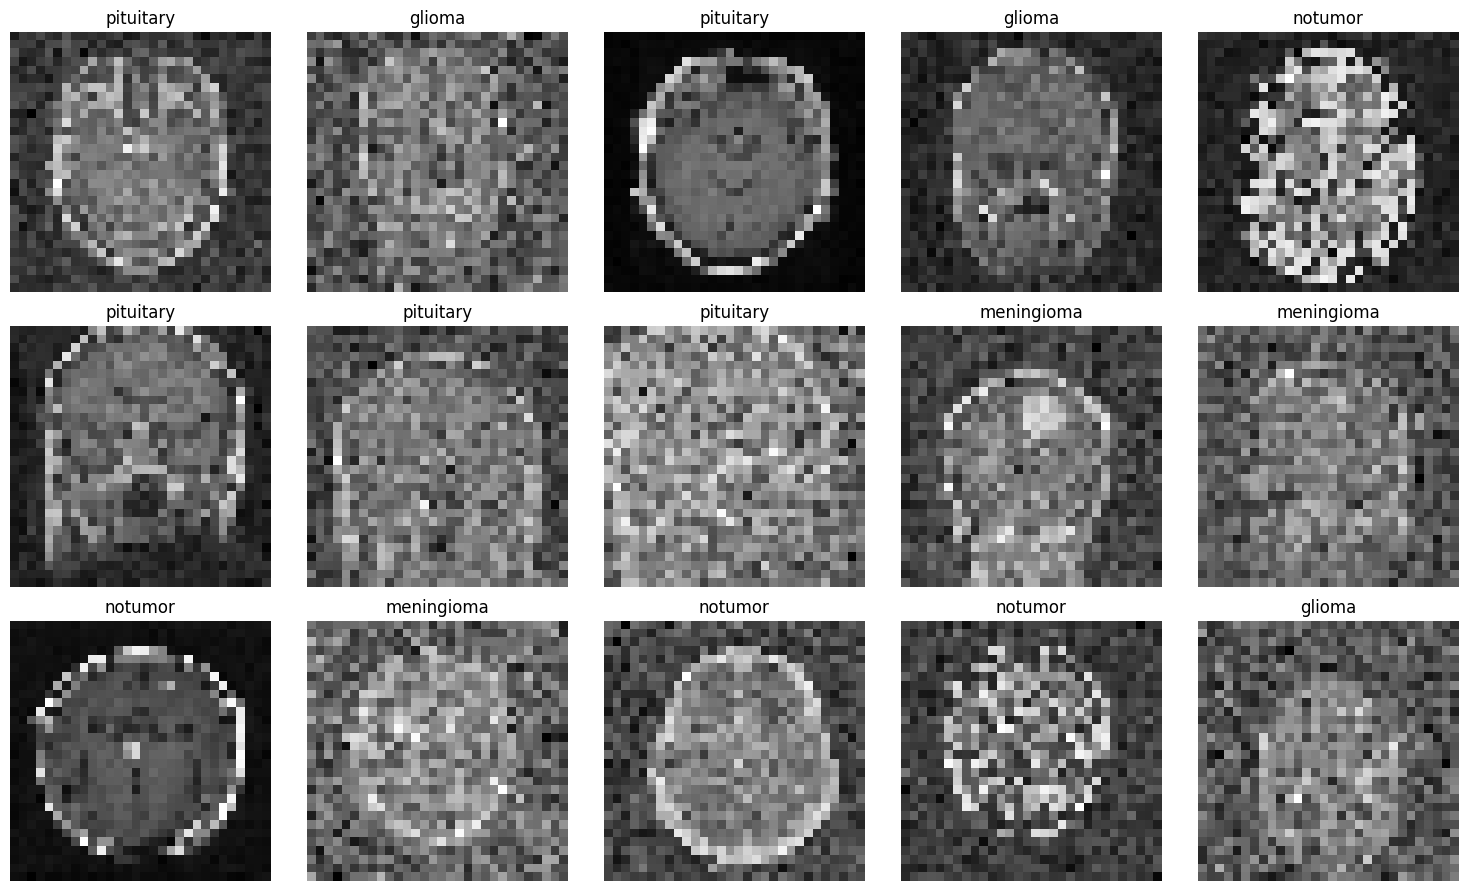

In [ ]:
# Display 15 random images with class names as titles

def display_random_images(train_data, num_images=15, save_path="random_images_grid.png"):
    # Get the total number of samples in the training data
    total_samples = train_data.samples

    # Randomly select 15 image indices
    random_indices = random.sample(range(total_samples), num_images)

    # Initialize empty lists to store selected images and labels
    selected_images = []
    selected_labels = []

    # Loop through the dataset and extract images corresponding to the randomly selected indices
    for batch_images, batch_labels in train_data:
        for i in range(len(batch_images)):
            if len(selected_images) >= num_images:
                break
            global_index = (train_data.batch_index - 1) * len(batch_images) + i
            if global_index in random_indices:
                selected_images.append(batch_images[i])
                selected_labels.append(batch_labels[i])
        if len(selected_images) >= num_images:
            break

    # Plot the selected images with their corresponding class names
    plt.figure(figsize=(15, 9))

    for i in range(num_images):
        # Convert one-hot label to class index
        class_index = np.argmax(selected_labels[i])

        # Get the class name from the class_indices mapping
        class_name = list(train_data.class_indices.keys())[class_index]

        # Display the image
        plt.subplot(3, 5, i + 1)
        plt.imshow(np.squeeze(selected_images[i]), cmap='gray')
        plt.title(class_name, fontsize=12)
        plt.axis('off')

    # Adjust the layout and show the plot
    plt.tight_layout()

    # Save the plot as an image file
    plt.savefig(save_path, format='png', bbox_inches='tight')  # Save the figure with a tight bounding box

    plt.show()

# Call the function to display 15 random images from train_data
display_random_images(train_data, save_path="random_images_grid.png")

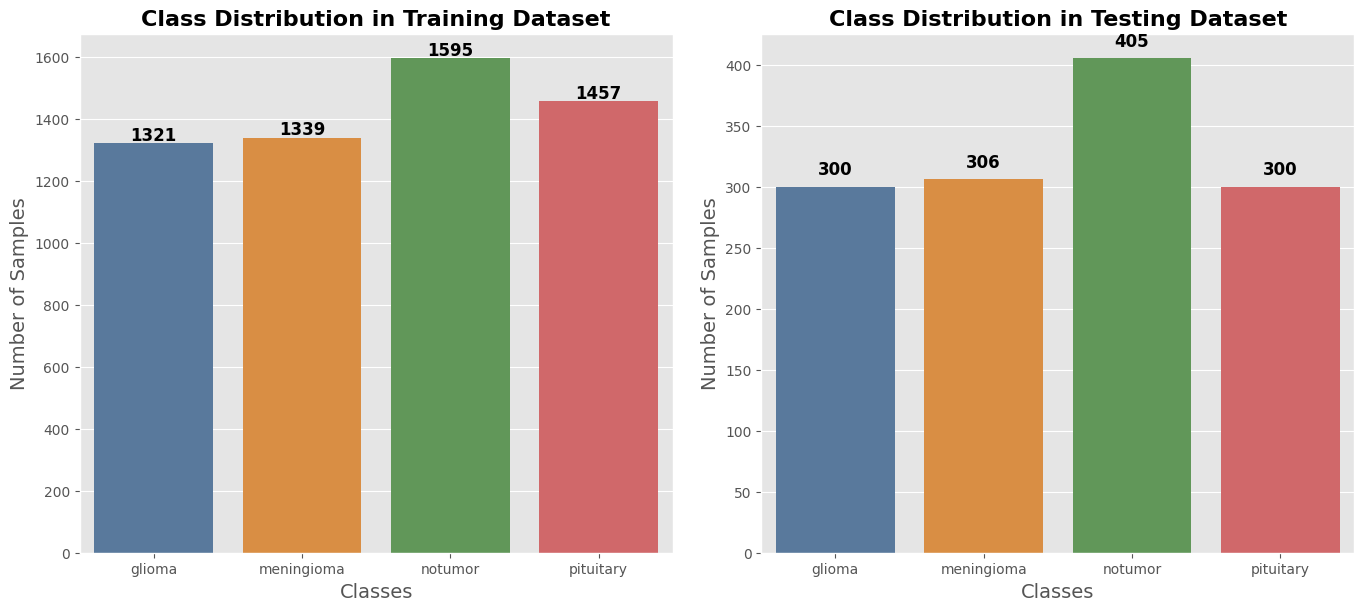

In [ ]:
# Check class distribution in the training and testing datasets

# Define the custom mapping of class indices to class names
custom_labels = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}

# Define the custom colors for each class
custom_colors = ['#4e79a7', '#f28e2b', '#59a14f', '#e15759']

# Function to plot the class distribution of the dataset
def plot_class_distribution(generator_train, generator_test, custom_labels, custom_colors, save_path="class_label_distribution.png"):
    # Extract the numeric labels from the generators
    train_labels = generator_train.labels
    test_labels = generator_test.labels

    # Count the occurrences of each class in training and testing datasets
    train_class_counts = pd.Series(train_labels).value_counts().sort_index()
    test_class_counts = pd.Series(test_labels).value_counts().sort_index()

    # Map integer labels to the custom class names
    train_class_counts.index = train_class_counts.index.map(custom_labels)
    test_class_counts.index = test_class_counts.index.map(custom_labels)

    # Convert them to DataFrames for easier plotting with seaborn
    train_df = pd.DataFrame({'Class': train_class_counts.index, 'Count': train_class_counts.values})
    test_df = pd.DataFrame({'Class': test_class_counts.index, 'Count': test_class_counts.values})

    # Set up figure size and style
    plt.figure(figsize=(14, 7))
    plt.style.use('ggplot')

    # Plot for training dataset
    plt.subplot(1, 2, 1)
    bar_plot_train = sns.barplot(x='Class', y='Count', data=train_df, palette=custom_colors)
    plt.title("Class Distribution in Training Dataset", fontsize=16, weight='bold')
    plt.xlabel("Classes", fontsize=14)
    plt.ylabel("Number of Samples", fontsize=14)

    # Add the count numbers on top of each bar (adjust the vertical position)
    for index, value in enumerate(train_class_counts):
        plt.text(index, value + 10, str(int(value)), ha='center', fontsize=12, weight='bold')

    # Plot for testing dataset
    plt.subplot(1, 2, 2)
    bar_plot_test = sns.barplot(x='Class', y='Count', data=test_df, palette=custom_colors)
    plt.title("Class Distribution in Testing Dataset", fontsize=16, weight='bold')
    plt.xlabel("Classes", fontsize=14)
    plt.ylabel("Number of Samples", fontsize=14)

    for index, value in enumerate(test_class_counts):
        plt.text(index, value + 10, str(int(value)), ha='center', fontsize=12, weight='bold')

    # Adjust layout to prevent overlap
    plt.tight_layout(pad=2)
    plt.subplots_adjust(top=0.85)

    plt.savefig(save_path, format='png', bbox_inches='tight')

    plt.show()

# Call the function to plot with custom class labels and colors
plot_class_distribution(train_data, test_data, custom_labels, custom_colors, save_path="class_label_distribution.png")

In [ ]:
# Apply 20% of the training set as a validation set for hyperparameter tuning

# Fetch all images and labels from train_data using next()
def extract_data_from_generator(data_generator):
  images, labels = [], []

  # Total batches in the generator
  steps = len(data_generator)

    # Loop through all batches
  for _ in range(steps):
    batch_images, batch_labels = next(data_generator)
    images.append(batch_images)
    labels.append(batch_labels)

  # Convert list of arrays to a single numpy array
  images = np.concatenate(images)
  labels = np.concatenate(labels)

  return images, labels

# Extract all data from train_data
train_images, train_labels = extract_data_from_generator(train_data)

# Split into 80% training and 20% validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42, shuffle=True)

print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Validation labels shape: {y_val.shape}")

Training data shape: (4569, 30, 30, 1), Training labels shape: (4569, 4)
Validation data shape: (1143, 30, 30, 1), Validation labels shape: (1143, 4)


In [ ]:
# Implement the baseline CNN algorithm

# Initialize the Sequential model
model = models.Sequential()

# Add the first convolutional layer with 32 filters of size 3x3, followed by ReLU activation and padding='same'
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv2d_4', input_shape=(30, 30, 1)))
# Add the first max pooling layer with pool size 2x2
model.add(layers.MaxPooling2D((2, 2)))

# Add the second convolutional layer with 32 filters of size 3x3, followed by ReLU activation and padding='same'
model.add(layers.Conv2D(32, (3, 3), activation='relu', name='conv2d_5'))
# Add the second max pooling layer with pool size 2x2
model.add(layers.MaxPooling2D((2, 2), name='max_pooling2d_5'))

# Flatten the 3D output from the convolutional layers to 1D
model.add(layers.Flatten(name='flatten_2'))

# Add the first dense layer with 32 units and ReLU activation
model.add(layers.Dense(32, activation='relu', name='dense_4'))

# Add the final dense layer with 4 units (for 4 classes) and softmax activation
model.add(layers.Dense(4, activation='softmax', name='dense_5'))

# Display the model summary to check the architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 13, 13, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,596 (182.02 KB)

 Trainable params: 46,596 (182.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Categorical Crossentropy is chosen for this task, as it's well suited for multiple categories.
model.compile(optimizer= Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))
val_loss, val_acc = model.evaluate(X_val, y_val)

Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4492 - loss: 1.1704 - val_accuracy: 0.6430 - val_loss: 0.8980
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7036 - loss: 0.7699 - val_accuracy: 0.6439 - val_loss: 0.8550
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7531 - loss: 0.6619 - val_accuracy: 0.6868 - val_loss: 0.7692
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7750 - loss: 0.5931 - val_accuracy: 0.7104 - val_loss: 0.7201
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7959 - loss: 0.5467 - val_accuracy: 0.7428 - val_loss: 0.6728
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8079 - loss: 0.5081 - val_accuracy: 0.7375 - val_loss: 0.6748
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8179 - loss: 0.4834 - val_accuracy: 0.7498 - val_loss: 0.6448
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8253 - loss: 0.4625 - val_accuracy: 0.

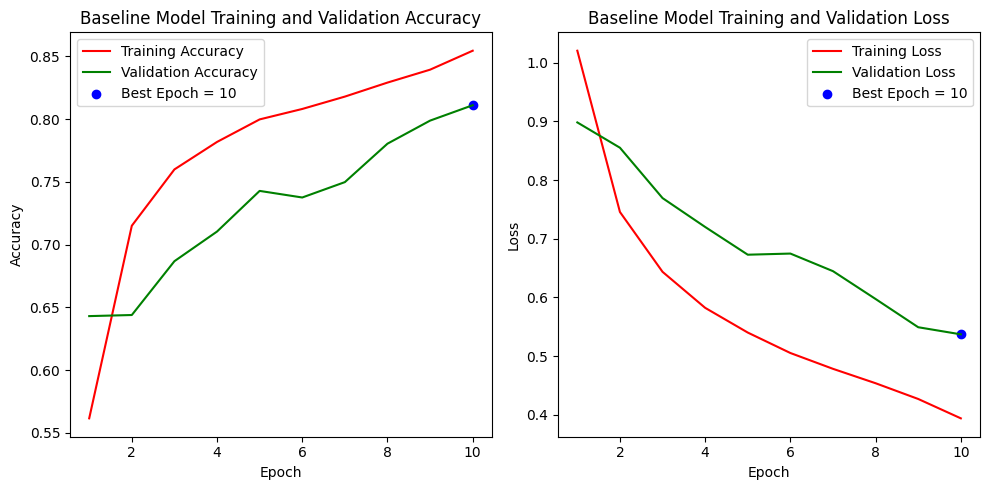

In [ ]:
# Check  training and validation losses and accuracies

# Create Array for Epochs
epochs = np.arange(1,11)
# Best epoch for accuracy
best_acc_epoch = np.argmax(history.history['val_accuracy'])
# Best epoch for loss
best_loss_epoch = np.argmin(history.history['val_loss'])

# Plot accuracy
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', color='red')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', color='green')
plt.scatter(best_acc_epoch+1, history.history['val_accuracy'][best_acc_epoch], color='blue', label=f'Best Epoch = {best_acc_epoch+1}')
plt.title('Baseline Model Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Training Loss', color='red')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss', color='green')
plt.scatter(best_loss_epoch+1, history.history['val_loss'][best_loss_epoch], color='blue', label=f'Best Epoch = {best_loss_epoch+1}')
plt.title('Baseline Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Function to evaluate performance

def evaluate_model(model, X, y_true, classes):
    # Get model predictions (as class indices)
    y_pred_prob = model.predict(X)  # Predict probabilities
    y_pred = np.argmax(y_pred_prob, axis=1)  # Convert to class indices

    # Calculate metrics
    accuracy = accuracy_score(np.argmax(y_true, axis=1), y_pred)
    precision = precision_score(np.argmax(y_true, axis=1), y_pred, average='weighted')
    recall = recall_score(np.argmax(y_true, axis=1), y_pred, average='weighted')
    f1 = f1_score(np.argmax(y_true, axis=1), y_pred, average='weighted')

    # Print classification report
    print("Classification Report:\n", classification_report(np.argmax(y_true, axis=1), y_pred, target_names=classes))
    print("Confusion Matrix:\n", confusion_matrix(np.argmax(y_true, axis=1), y_pred))

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    return y_pred_prob, y_pred

In [ ]:
# Function to plot confusion matrix

def plot_confusion_matrix(y_true, y_pred, classes):
    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
# Function to plot AUC-ROC Curve

def plot_roc_auc(y_true, y_pred_prob, classes):
    # Binarize the true labels for ROC calculation
    y_true_bin = label_binarize(np.argmax(y_true, axis=1), classes=np.arange(len(classes)))

    # Compute ROC curve and ROC AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(classes):
        plt.plot(fpr[i], tpr[i], label=f'{class_name} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

=== Validation Set Performance ===
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.75      0.82      0.78       261
  meningioma       0.74      0.61      0.67       267
     notumor       0.90      0.86      0.88       316
   pituitary       0.83      0.93      0.88       299

    accuracy                           0.81      1143
   macro avg       0.80      0.81      0.80      1143
weighted avg       0.81      0.81      0.81      1143

Confusion Matrix:
 [[214  35   3   9]
 [ 59 163  23  22]
 [  3  16 271  26]
 [  9   6   5 279]]
Accuracy: 0.8110
Precision: 0.8098
Recall: 0.8110
F1-Score: 0.8077


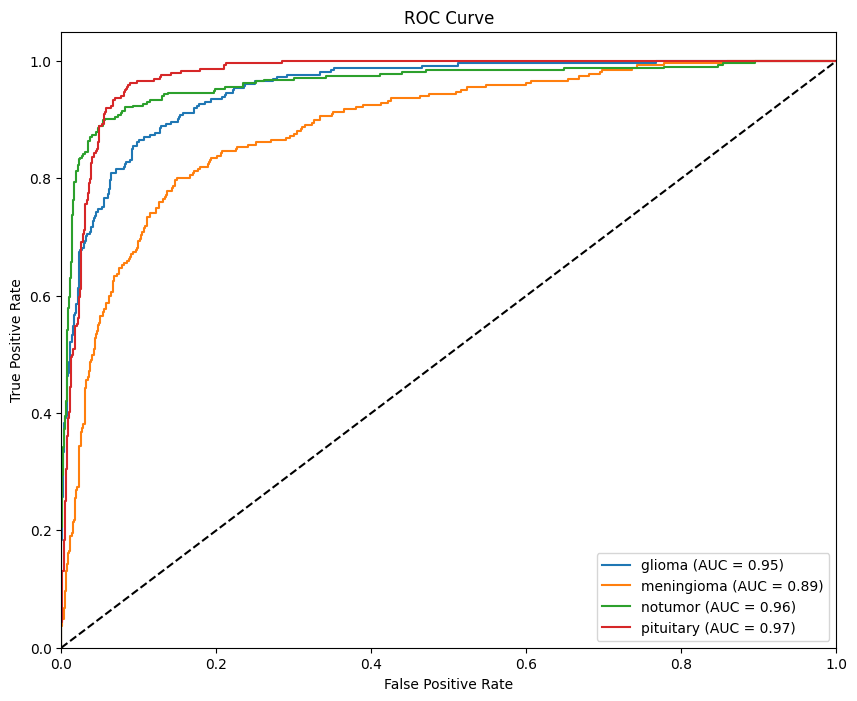

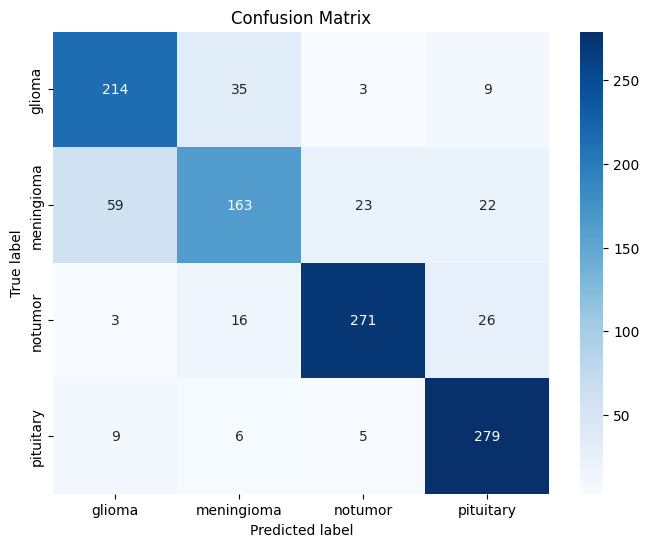

In [ ]:
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# 1. Evaluate on Validation Set
print("=== Validation Set Performance ===")
y_pred_prob_val, y_pred_val = evaluate_model(model, X_val, y_val, classes)

# Plot ROC curve for validation set
plot_roc_auc(y_val, y_pred_prob_val, classes)

# Plot confusion matrix for validation set
plot_confusion_matrix(np.argmax(y_val, axis=1), y_pred_val, classes)


=== Test Set Performance ===
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.71      0.79      0.75       300
  meningioma       0.64      0.44      0.52       306
     notumor       0.85      0.84      0.84       405
   pituitary       0.75      0.92      0.83       300

    accuracy                           0.75      1311
   macro avg       0.74      0.75      0.74      1311
weighted avg       0.75      0.75      0.74      1311

Confusion Matrix:
 [[238  42   1  19]
 [ 75 135  51  45]
 [ 14  26 339  26]
 [  9   9   7 275]]
Accuracy: 0.7529
Precision: 0.7463
Recall: 0.7529
F1-Score: 0.7430


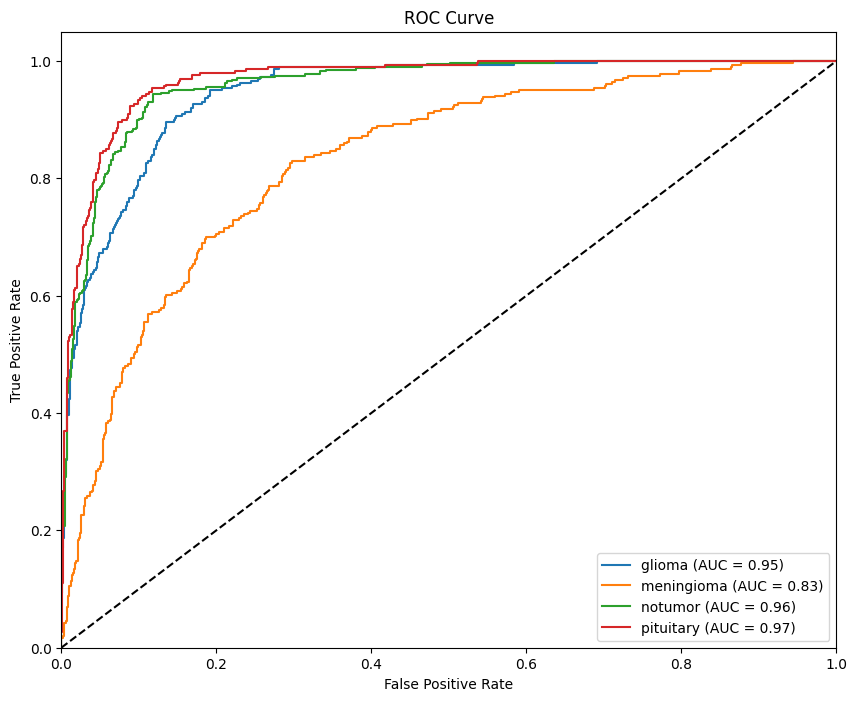

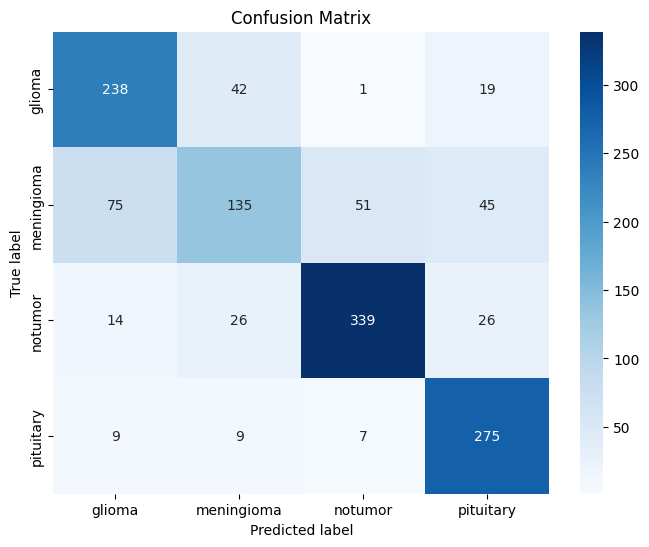

In [ ]:
# 2. Evaluate on Test Set
print("\n=== Test Set Performance ===")

X_test, y_test = extract_data_from_generator(test_data)

# Evaluate on test set
y_pred_prob_test, y_pred_test = evaluate_model(model, X_test, y_test, classes)

# Plot ROC curve for test set
plot_roc_auc(y_test, y_pred_prob_test, classes)

# Plot confusion matrix for test set
plot_confusion_matrix(np.argmax(y_test, axis=1), y_pred_test, classes)

### **1.2 Best Model**

##### Model Architecture (Hyperparameter Tuning with Optuna)

In [ ]:
# Combine the training and validation data to train the final model
X_train_final = np.concatenate((X_train, X_val))
y_train_final = np.concatenate((y_train, y_val))

In [ ]:
# Implement the Optuna hyperparameter optimization for the baseline model

def objective_model_2(trial):
    model = models.Sequential()
    
    # Hyperparameter 1: Number of convolutional layers
    n_conv_layers = trial.suggest_int('n_conv_layers', 2, 5)
    
    input_shape = (30, 30, 1)
    for i in range(n_conv_layers):
        # Hyperparameter 2: Number of filters
        filters = trial.suggest_int(f'filters_{i}', 32, 128, log=True)
        
        # Hyperparameter 3: Filter size (Kernel size)
        kernel_size = trial.suggest_categorical(f'kernel_size_{i}', [3, 5])
        
        # Hyperparameter 4: Activation function
        activation = trial.suggest_categorical('activation', ['relu', 'leaky_relu'])
        
        # Add convolutional layer with padding to preserve dimensions
        if i == 0:
            model.add(layers.Conv2D(filters, kernel_size=kernel_size, activation=activation, padding='same', input_shape=input_shape))
        else:
            model.add(layers.Conv2D(filters, kernel_size=kernel_size, activation=activation, padding='same'))
        
        # Hyperparameter 5: Pooling type
        pooling_type = trial.suggest_categorical('pooling_type', ['max', 'average'])
        if model.output_shape[1] > 2 and model.output_shape[2] > 2:
            if pooling_type == 'max':
                model.add(layers.MaxPooling2D(pool_size=(2, 2)))
            else:
                model.add(layers.AveragePooling2D(pool_size=(2, 2)))
    
    model.add(layers.Flatten())
    
    # Hyperparameter 6: Dropout rate
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    model.add(layers.Dropout(dropout_rate))
    
    # Hyperparameter 7: Units in dense layers
    units = trial.suggest_int('units_dense', 64, 256, log=True)
    model.add(layers.Dense(units, activation=activation))
    
    model.add(layers.Dense(4, activation='softmax'))

    # Hyperparameter 8: Learning rate
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    
    # Compile the model
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Define an early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True)
    
    # Hyperparameter 9: Batch size
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    # Train the model
    history = model.fit(
        X_train, y_train,               # Training data
        validation_data=(X_val, y_val), # Validation data
        epochs=10,                      # Number of epochs
        batch_size=batch_size,          # Batch size
        callbacks=[early_stopping],     # Early stopping to prevent overfitting
        verbose=0                       # Set verbose to 0 to avoid too much output
    )
    
    # Get the validation accuracy
    val_accuracy = history.history['val_accuracy'][-1]
    
    # Return the validation accuracy to maximize it
    return val_accuracy

# Run the Optuna optimization process for the new model
study_model_2 = optuna.create_study(direction='maximize')
study_model_2.optimize(objective_model_2, n_trials=20)

# Print the best parameters found by Optuna
print("Best hyperparameters for model 2: ", study_model_2.best_trial.params)

[I 2024-09-23 21:32:04,991] A new study created in memory with name: no-name-90b0fb17-3f5e-4340-93b8-c1cb35962898
[I 2024-09-23 21:32:20,170] Trial 0 finished with value: 0.649168848991394 and parameters: {'n_conv_layers': 5, 'filters_0': 60, 'kernel_size_0': 5, 'activation': 'leaky_relu', 'pooling_type': 'average', 'filters_1': 56, 'kernel_size_1': 3, 'filters_2': 121, 'kernel_size_2': 5, 'filters_3': 42, 'kernel_size_3': 3, 'filters_4': 32, 'kernel_size_4': 3, 'dropout_rate': 0.3851725245930434, 'units_dense': 98, 'learning_rate': 0.004981222225569461, 'batch_size': 64}. Best is trial 0 with value: 0.649168848991394.
[I 2024-09-23 21:33:29,897] Trial 1 finished with value: 0.8048993945121765 and parameters: {'n_conv_layers': 4, 'filters_0': 74, 'kernel_size_0': 5, 'activation': 'leaky_relu', 'pooling_type': 'average', 'filters_1': 128, 'kernel_size_1': 5, 'filters_2': 119, 'kernel_size_2': 5, 'filters_3': 38, 'kernel_size_3': 5, 'dropout_rate': 0.17936671331192794, 'units_dense': 193

Best hyperparameters for model 2:  {'n_conv_layers': 4, 'filters_0': 82, 'kernel_size_0': 3, 'activation': 'leaky_relu', 'pooling_type': 'max', 'filters_1': 125, 'kernel_size_1': 3, 'filters_2': 77, 'kernel_size_2': 5, 'filters_3': 32, 'kernel_size_3': 5, 'dropout_rate': 0.0023982986803837147, 'units_dense': 237, 'learning_rate': 0.000396690871032739, 'batch_size': 32}


In [ ]:
# Check the performance of the model with the hyperparameters

# Initialize the Sequential model
model_2 = models.Sequential()

# Best hyperparameters for model_2 from Optuna
n_conv_layers = 4
filters_0 = 82
kernel_size_0 = 3
filters_1 = 125
kernel_size_1 = 3
filters_2 = 77
kernel_size_2 = 5
filters_3 = 32
kernel_size_3 = 5
activation = 'leaky_relu'
dropout_rate = 0.0023982986803837147
units_dense = 237
num_classes = 4
learning_rate = 0.000396690871032739
batch_size = 32
pooling_type = 'max'

# 1st Convolutional Layer (with padding 'same')
model_2.add(layers.Conv2D(filters_0, (kernel_size_0, kernel_size_0), activation=activation, padding='same', input_shape=(28, 28, 1)))
# 1st Pooling Layer
if pooling_type == 'max':
    model_2.add(layers.MaxPooling2D((2, 2)))
else:
    model_2.add(layers.AveragePooling2D((2, 2)))

# 2nd Convolutional Layer (with padding 'same')
model_2.add(layers.Conv2D(filters_1, (kernel_size_1, kernel_size_1), activation=activation, padding='same'))
# 2nd Pooling Layer
if pooling_type == 'max':
    model_2.add(layers.MaxPooling2D((2, 2)))
else:
    model_2.add(layers.AveragePooling2D((2, 2)))

# 3rd Convolutional Layer (with padding 'same')
model_2.add(layers.Conv2D(filters_2, (kernel_size_2, kernel_size_2), activation=activation, padding='same'))
# 3rd Pooling Layer
if pooling_type == 'max':
    model_2.add(layers.MaxPooling2D((2, 2)))
else:
    model_2.add(layers.AveragePooling2D((2, 2)))

# 4th Convolutional Layer (with padding 'same')
model_2.add(layers.Conv2D(filters_3, (kernel_size_3, kernel_size_3), activation=activation, padding='same'))
# 4th Pooling Layer
if pooling_type == 'max':
    model_2.add(layers.MaxPooling2D((2, 2)))
else:
    model_2.add(layers.AveragePooling2D((2, 2)))

# Flatten the 3D output from the convolutional layers to 1D
model_2.add(layers.Flatten())

# Dropout Layer
model_2.add(layers.Dropout(dropout_rate))

# Dense Layer with specified units
model_2.add(layers.Dense(units_dense, activation=activation))

# Final Dense Layer (output layer) with 4 units for 4 classes (softmax activation)
model_2.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model with the specified learning rate
optimizer = optimizers.Adam(learning_rate=learning_rate)
model_2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define an early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True)

# Train the tuned model on the combined training and validation data
model_2.fit(
    X_train_final, y_train_final,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=batch_size,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.4449 - loss: 1.1720 - val_accuracy: 0.6354 - val_loss: 0.8841
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7099 - loss: 0.7297 - val_accuracy: 0.7155 - val_loss: 0.6909
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7792 - loss: 0.5752 - val_accuracy: 0.7559 - val_loss: 0.6159
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8113 - loss: 0.5016 - val_accuracy: 0.7536 - val_loss: 0.5906
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8315 - loss: 0.4416 - val_accuracy: 0.7582 - val_loss: 0.6142
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8532 - loss: 0.3957 - val_accuracy: 0.7712 - val_loss: 0.5899
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.8670 - loss: 0.3475 - val_accuracy: 0.7933 - val_loss: 0.5481
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.8902 - loss: 0.3006 - val_accu


=== Test Set Performance ===
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.82      0.75      0.78       300
  meningioma       0.64      0.74      0.69       306
     notumor       0.89      0.92      0.91       405
   pituitary       0.94      0.84      0.89       300

    accuracy                           0.82      1311
   macro avg       0.82      0.81      0.82      1311
weighted avg       0.83      0.82      0.82      1311

Confusion Matrix:
 [[225  67   1   7]
 [ 35 225  39   7]
 [  8  22 374   1]
 [  6  36   6 252]]
Accuracy: 0.8207
Precision: 0.8290
Recall: 0.8207
F1-Score: 0.8230


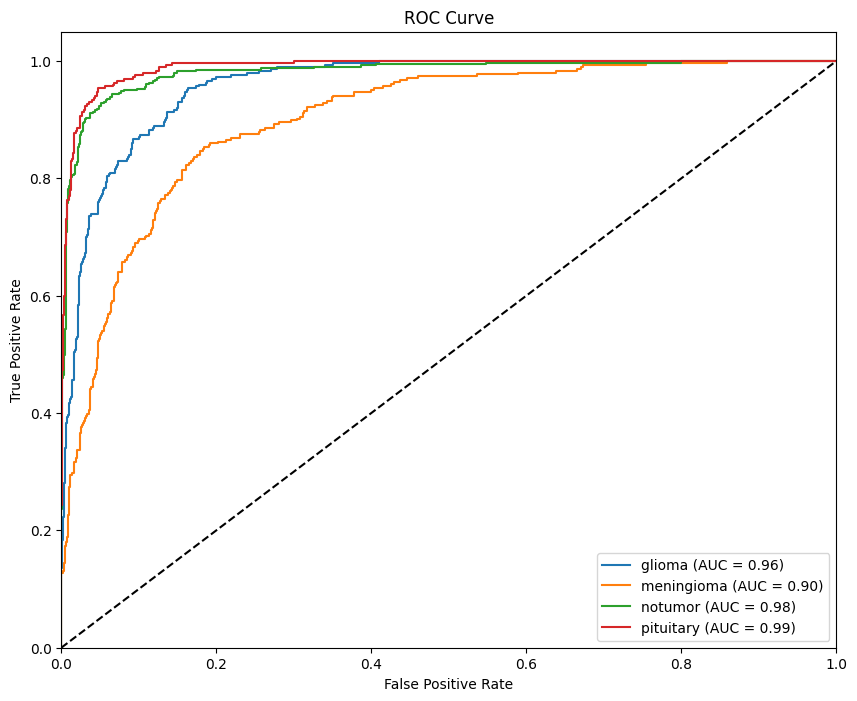

In [ ]:
# Evaluate on Test Set
print("\n=== Test Set Performance ===")

# Evaluate on test set
y_pred_prob_test, y_pred_test = evaluate_model(model_2, X_test, y_test, classes)

# Plot ROC curve for test set
plot_roc_auc(y_test, y_pred_prob_test, classes)

In [ ]:
# Improve the model further using Optuna

def objective(trial):
    model = models.Sequential()
    
    # Hyperparameters
    n_conv_layers = 4
    filters_0 = trial.suggest_int('filters_0', 32, 256)
    kernel_size_0 = trial.suggest_categorical('kernel_size_0', [3, 5])
    filters_1 = trial.suggest_int('filters_1', 32, 256)
    kernel_size_1 = trial.suggest_categorical('kernel_size_1', [3, 5])
    filters_2 = trial.suggest_int('filters_2', 32, 256)
    kernel_size_2 = trial.suggest_categorical('kernel_size_2', [3, 5])
    filters_3 = trial.suggest_int('filters_3', 32, 256)
    kernel_size_3 = trial.suggest_categorical('kernel_size_3', [3, 5])
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    units_dense = trial.suggest_int('units_dense', 64, 512)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    
    # Add layers to the model
    model.add(layers.Conv2D(filters_0, (kernel_size_0, kernel_size_0), activation='relu', padding='same', input_shape=(30, 30, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(filters_1, (kernel_size_1, kernel_size_1), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(filters_2, (kernel_size_2, kernel_size_2), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(filters_3, (kernel_size_3, kernel_size_3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(units_dense, activation='relu'))
    model.add(layers.Dense(4, activation='softmax'))

    # Compile the model
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(
        X_train_final, 
        y_train_final, 
        batch_size=batch_size, 
        validation_data=(X_test, y_test), 
        epochs=10, 
        verbose=0
    )
    
    return history.history['val_accuracy'][-1]

# Run the Optuna optimization process
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best parameters found by Optuna
print("Best hyperparameters: ", study.best_trial.params)

[I 2024-09-24 13:06:44,213] A new study created in memory with name: no-name-afb12664-ac76-4d8b-92b1-f8228853f7be
[I 2024-09-24 13:08:01,311] Trial 0 finished with value: 0.6659038662910461 and parameters: {'filters_0': 83, 'kernel_size_0': 3, 'filters_1': 115, 'kernel_size_1': 5, 'filters_2': 178, 'kernel_size_2': 5, 'filters_3': 61, 'kernel_size_3': 5, 'dropout_rate': 0.40816965745478145, 'units_dense': 203, 'learning_rate': 5.397155866942107e-05, 'batch_size': 64}. Best is trial 0 with value: 0.6659038662910461.
[I 2024-09-24 13:09:36,989] Trial 1 finished with value: 0.6598016619682312 and parameters: {'filters_0': 136, 'kernel_size_0': 5, 'filters_1': 239, 'kernel_size_1': 3, 'filters_2': 94, 'kernel_size_2': 5, 'filters_3': 183, 'kernel_size_3': 5, 'dropout_rate': 0.08788488477549011, 'units_dense': 368, 'learning_rate': 2.4012119565044114e-05, 'batch_size': 64}. Best is trial 0 with value: 0.6659038662910461.
[I 2024-09-24 13:13:05,809] Trial 2 finished with value: 0.78108316659

Best hyperparameters:  {'filters_0': 171, 'kernel_size_0': 3, 'filters_1': 124, 'kernel_size_1': 3, 'filters_2': 231, 'kernel_size_2': 5, 'filters_3': 183, 'kernel_size_3': 3, 'dropout_rate': 0.04055175925029486, 'units_dense': 162, 'learning_rate': 0.00031907383956506684, 'batch_size': 16}


In [ ]:
# Use the hyperparameters so far to train the model

# Initialize the Sequential model
model_2_improved = models.Sequential()

# Best hyperparameters for model_2_improved
filters_0 = 171
kernel_size_0 = 3
filters_1 = 124
kernel_size_1 = 3
filters_2 = 231
kernel_size_2 = 5
filters_3 = 183
kernel_size_3 = 3
dropout_rate = 0.04055175925029486
units_dense = 162
learning_rate = 0.00031907383956506684
batch_size = 16

# 1st Convolutional Layer (with padding 'same')
model_2_improved.add(layers.Conv2D(filters_0, (kernel_size_0, kernel_size_0), activation='leaky_relu', padding='same', input_shape=(28, 28, 1)))
# 1st MaxPooling Layer
model_2_improved.add(layers.MaxPooling2D((2, 2)))

# 2nd Convolutional Layer (with padding 'same')
model_2_improved.add(layers.Conv2D(filters_1, (kernel_size_1, kernel_size_1), activation='leaky_relu', padding='same'))
# 2nd MaxPooling Layer
model_2_improved.add(layers.MaxPooling2D((2, 2)))

# 3rd Convolutional Layer (with padding 'same')
model_2_improved.add(layers.Conv2D(filters_2, (kernel_size_2, kernel_size_2), activation='leaky_relu', padding='same'))
# 3rd MaxPooling Layer
model_2_improved.add(layers.MaxPooling2D((2, 2)))

# 4th Convolutional Layer (with padding 'same')
model_2_improved.add(layers.Conv2D(filters_3, (kernel_size_3, kernel_size_3), activation='leaky_relu', padding='same'))
# 4th MaxPooling Layer
model_2_improved.add(layers.MaxPooling2D((2, 2)))

# Flatten the 3D output from the convolutional layers to 1D
model_2_improved.add(layers.Flatten())

# Dropout Layer
model_2_improved.add(layers.Dropout(dropout_rate))

# Dense Layer with specified units
model_2_improved.add(layers.Dense(units_dense, activation='leaky_relu'))

# Final Dense Layer (output layer) with 4 units for 4 classes (softmax activation)
model_2_improved.add(layers.Dense(4, activation='softmax'))

# Compile the model with the specified learning rate
optimizer = optimizers.Adam(learning_rate=learning_rate)
model_2_improved.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define an early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True)

# Train the tuned model on the combined training and validation data
model_2_improved.fit(
    X_train_final, y_train_final,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=batch_size,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - accuracy: 0.5138 - loss: 1.0766 - val_accuracy: 0.7208 - val_loss: 0.6960
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.7659 - loss: 0.5907 - val_accuracy: 0.7643 - val_loss: 0.5726
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.8270 - loss: 0.4630 - val_accuracy: 0.7605 - val_loss: 0.5478
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.8607 - loss: 0.3690 - val_accuracy: 0.7986 - val_loss: 0.5328
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.8986 - loss: 0.2741 - val_accuracy: 0.8238 - val_loss: 0.4538
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.9346 - loss: 0.1804 - val_accuracy: 0.8413 - val_loss: 0.4458
Epoch 7/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.9507 - loss: 0.1339 - val_accuracy: 0.8513 - val_loss: 0.4496
Epoch 8/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.9671 - loss: 0.0945 - 


=== Test Set Performance ===
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.83      0.80      0.82       300
  meningioma       0.68      0.81      0.74       306
     notumor       0.95      0.87      0.91       405
   pituitary       0.91      0.87      0.89       300

    accuracy                           0.84      1311
   macro avg       0.84      0.84      0.84      1311
weighted avg       0.85      0.84      0.84      1311

Confusion Matrix:
 [[240  52   0   8]
 [ 30 248  15  13]
 [  7  41 352   5]
 [ 11  23   4 262]]
Accuracy: 0.8406
Precision: 0.8510
Recall: 0.8406
F1-Score: 0.8438


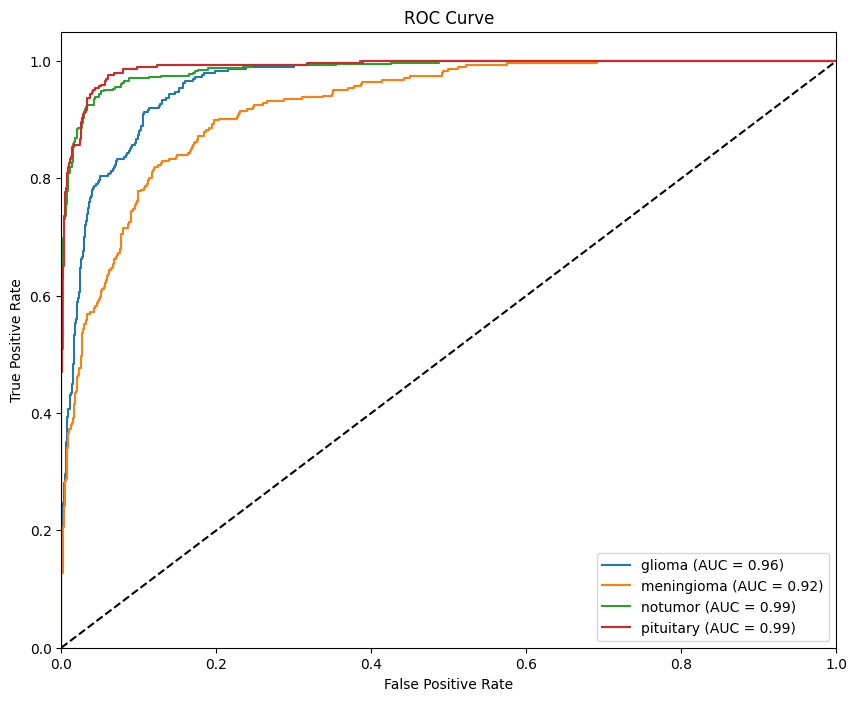

In [ ]:
# Evaluate on Test Set
print("\n=== Test Set Performance ===")

# Evaluate on test set
y_pred_prob_test, y_pred_test = evaluate_model(model_2_improved, X_test, y_test, classes)

# Plot ROC curve for test set
plot_roc_auc(y_test, y_pred_prob_test, classes)

##### Loss Function and Optimization (focal loss)

In [ ]:
# Use focal loss for the improved model

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        y_true = tf.cast(y_true, tf.float32)

        cross_entropy = -y_true * K.log(y_pred)
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        return K.sum(loss, axis=-1)
    
    return focal_loss_fixed

# Use Focal Loss instead of categorical crossentropy
model_2_improved.compile(optimizer=optimizer, loss=focal_loss(), metrics=['accuracy'])

# Train the model
model_2_improved.fit(
    X_train_final, y_train_final,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=batch_size,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.9535 - loss: 0.0104 - val_accuracy: 0.8726 - val_loss: 0.0470
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.9774 - loss: 0.0043 - val_accuracy: 0.8772 - val_loss: 0.0474
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.9843 - loss: 0.0030 - val_accuracy: 0.8741 - val_loss: 0.0480
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.9890 - loss: 0.0022 - val_accuracy: 0.8711 - val_loss: 0.0502



=== Test Set Performance ===
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.85      0.78      0.81       300
  meningioma       0.76      0.80      0.78       306
     notumor       0.96      0.95      0.96       405
   pituitary       0.90      0.94      0.92       300

    accuracy                           0.87      1311
   macro avg       0.87      0.87      0.87      1311
weighted avg       0.87      0.87      0.87      1311

Confusion Matrix:
 [[233  56   0  11]
 [ 30 244  15  17]
 [  4  12 385   4]
 [  8   9   1 282]]
Accuracy: 0.8726
Precision: 0.8734
Recall: 0.8726
F1-Score: 0.8724


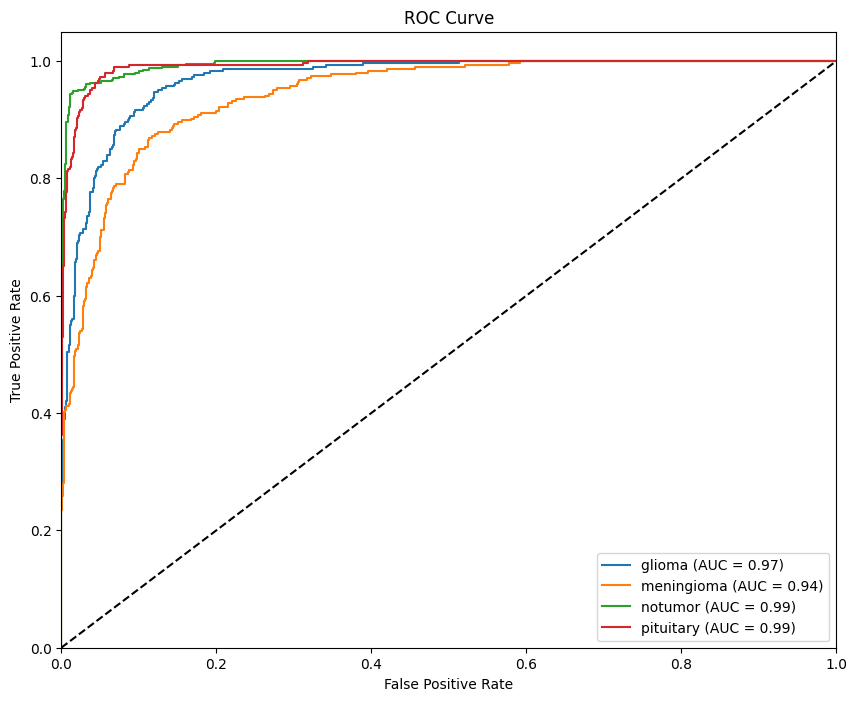

In [ ]:
# Evaluate on Test Set
print("\n=== Test Set Performance ===")

# Evaluate on test set
y_pred_prob_test, y_pred_test = evaluate_model(model_2_improved, X_test, y_test, classes)

# Plot ROC curve for test set
plot_roc_auc(y_test, y_pred_prob_test, classes)

##### Class Imbalance Handling (SMOTE)

In [ ]:
# Current class counts in the training data
class_counts = Counter(np.argmax(y_train_final, axis=1))

# Define target count for glioma and meningioma (around 85-90% of the notumor count)
target_count_glioma = max(class_counts[0], int(0.85 * class_counts[2]))
target_count_meningioma = max(class_counts[1], int(0.85 * class_counts[2]))

# Define SMOTE sampling strategy
sampling_strategy = {
    0: target_count_glioma,        # Oversample glioma
    1: target_count_meningioma,    # Oversample meningioma
    2: class_counts[2],            # Keep notumor unchanged
    3: class_counts[3]             # Keep pituitary unchanged
}

In [ ]:
# Apply SMOTE
smote = SMOTE(random_state=42, sampling_strategy=sampling_strategy)

# Flatten the image data for SMOTE
X_train_flat = X_train_final.reshape(len(X_train_final), -1)

# Convert one-hot encoded labels to class labels for SMOTE
y_train_classes = np.argmax(y_train_final, axis=1)

# Resample the training data using SMOTE
X_train_resampled_flat, y_train_resampled_classes = smote.fit_resample(X_train_flat, y_train_classes)

# Reshape the oversampled data back to image shape
X_train_resampled = X_train_resampled_flat.reshape(len(X_train_resampled_flat), 30, 30, 1)

# Convert labels back to one-hot encoding
y_train_resampled = tf.keras.utils.to_categorical(y_train_resampled_classes, num_classes=4)

# Shuffle the resampled dataset
X_train_resampled, y_train_resampled = shuffle(X_train_resampled, y_train_resampled, random_state=42)

# Train the model with Focal Loss
model_2_improved.fit(
    X_train_resampled, y_train_resampled,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=batch_size,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.9798 - loss: 0.0039 - val_accuracy: 0.8673 - val_loss: 0.0490
Epoch 2/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.9875 - loss: 0.0029 - val_accuracy: 0.8612 - val_loss: 0.0493
Epoch 3/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.9913 - loss: 0.0019 - val_accuracy: 0.8719 - val_loss: 0.0514


In [ ]:
# Evaluate the SMOTE-trained model on the test set
test_loss, test_accuracy = model_2_improved.evaluate(X_test, y_test, verbose=1)

print(f"Test Accuracy after SMOTE: {test_accuracy:.4f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8362 - loss: 0.0552
Test Accuracy after SMOTE: 0.8673


In [ ]:
# Predict on the test set using the SMOTE-trained model
y_pred = model_2_improved.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Print detailed classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=['glioma', 'meningioma', 'notumor', 'pituitary']))

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
              precision    recall  f1-score   support

      glioma       0.80      0.85      0.82       300
  meningioma       0.81      0.70      0.75       306
     notumor       0.95      0.95      0.95       405
   pituitary       0.88      0.95      0.91       300

    accuracy                           0.87      1311
   macro avg       0.86      0.86      0.86      1311
weighted avg       0.87      0.87      0.87      1311



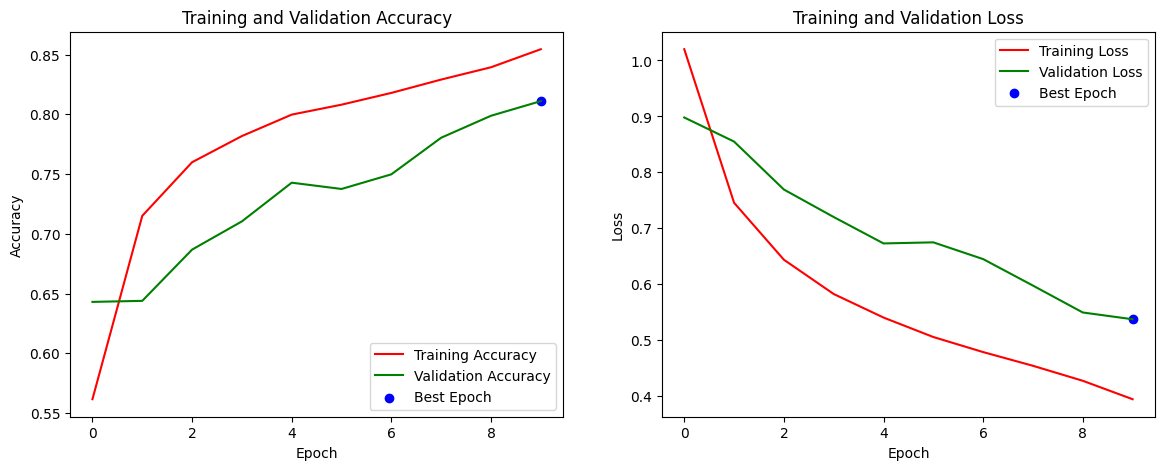

In [ ]:
import matplotlib.pyplot as plt

# Function to plot training history
def plot_training_history(history):
    plt.figure(figsize=(14, 5))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], 'r', label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], 'g', label='Validation Accuracy')
    best_epoch = np.argmax(history.history['val_accuracy'])
    plt.scatter(best_epoch, history.history['val_accuracy'][best_epoch], label="Best Epoch", color='blue')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], 'r', label='Training Loss')
    plt.plot(history.history['val_loss'], 'g', label='Validation Loss')
    best_epoch_loss = np.argmin(history.history['val_loss'])
    plt.scatter(best_epoch_loss, history.history['val_loss'][best_epoch_loss], label="Best Epoch", color='blue')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.show()

# Use the function to plot history
plot_training_history(history)

##### Further Hyperparameter Tuning (Manually increase dropout rate from 0.04 to 0.07)

In [ ]:
# Initialize the Sequential model
model_3 = models.Sequential()

# Best hyperparameters for model_3
filters_0 = 171
kernel_size_0 = 3
filters_1 = 124
kernel_size_1 = 3
filters_2 = 231
kernel_size_2 = 5
filters_3 = 183
kernel_size_3 = 3
dropout_rate = 0.07  # Increase dropout rate from 0.04 to 0.07
units_dense = 162
learning_rate = 0.00031907383956506684
batch_size = 16

# 1st Convolutional Layer (with padding 'same')
model_3.add(layers.Conv2D(filters_0, (kernel_size_0, kernel_size_0), activation='leaky_relu', padding='same', input_shape=(30, 30, 1)))
# 1st MaxPooling Layer
model_3.add(layers.MaxPooling2D((2, 2)))

# 2nd Convolutional Layer (with padding 'same')
model_3.add(layers.Conv2D(filters_1, (kernel_size_1, kernel_size_1), activation='leaky_relu', padding='same'))
# 2nd MaxPooling Layer
model_3.add(layers.MaxPooling2D((2, 2)))

# 3rd Convolutional Layer (with padding 'same')
model_3.add(layers.Conv2D(filters_2, (kernel_size_2, kernel_size_2), activation='leaky_relu', padding='same'))
# 3rd MaxPooling Layer
model_3.add(layers.MaxPooling2D((2, 2)))

# 4th Convolutional Layer (with padding 'same')
model_3.add(layers.Conv2D(filters_3, (kernel_size_3, kernel_size_3), activation='leaky_relu', padding='same'))
# 4th MaxPooling Layer
model_3.add(layers.MaxPooling2D((2, 2)))

# Flatten the 3D output from the convolutional layers to 1D
model_3.add(layers.Flatten())

# Dropout Layer (increase rate to 0.4)
model_3.add(layers.Dropout(dropout_rate))

# Dense Layer with specified units
model_3.add(layers.Dense(units_dense, activation='relu'))

# Final Dense Layer (output layer) with 4 units for 4 classes (softmax activation)
model_3.add(layers.Dense(4, activation='softmax'))

# Compile the model with the specified learning rate
optimizer = optimizers.Adam(learning_rate=learning_rate)
model_3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define an early stopping callback to prevent overfitting with patience 2
early_stopping = EarlyStopping(monitor='val_loss', patience=2, mode='min', restore_best_weights=True)

# Train the model (Model 3) on the combined training and validation data
history_model_3 = model_3.fit(
    X_train_final, y_train_final,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=batch_size,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/10
357/357 [==============================] - 37s 102ms/step - loss: 0.8949 - accuracy: 0.6238 - val_loss: 0.7123 - val_accuracy: 0.7071
Epoch 2/10
357/357 [==============================] - 44s 123ms/step - loss: 0.5789 - accuracy: 0.7789 - val_loss: 0.6951 - val_accuracy: 0.7414
Epoch 3/10
357/357 [==============================] - 44s 123ms/step - loss: 0.4742 - accuracy: 0.8188 - val_loss: 0.4990 - val_accuracy: 0.7971
Epoch 4/10
357/357 [==============================] - 43s 121ms/step - loss: 0.3975 - accuracy: 0.8508 - val_loss: 0.4516 - val_accuracy: 0.8192
Epoch 5/10
357/357 [==============================] - 44s 123ms/step - loss: 0.3035 - accuracy: 0.8778 - val_loss: 0.3940 - val_accuracy: 0.8459
Epoch 6/10
357/357 [==============================] - 45s 127ms/step - loss: 0.2097 - accuracy: 0.9202 - val_loss: 0.3692 - val_accuracy: 0.8566
Epoch 7/10
357/357 [==============================] - 42s 118ms/step - loss: 0.1547 - accuracy: 0.9435 - val_loss: 0.4010 - val_ac


=== Test Set Performance ===
41/41 [==============================] - 2s 36ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.80      0.82      0.81       300
  meningioma       0.79      0.69      0.73       306
     notumor       0.90      0.97      0.93       405
   pituitary       0.91      0.91      0.91       300

    accuracy                           0.86      1311
   macro avg       0.85      0.85      0.85      1311
weighted avg       0.85      0.86      0.85      1311

Confusion Matrix:
 [[247  39   3  11]
 [ 44 210  39  13]
 [  7   2 394   2]
 [ 10  15   3 272]]
Accuracy: 0.8566
Precision: 0.8539
Recall: 0.8566
F1-Score: 0.8539


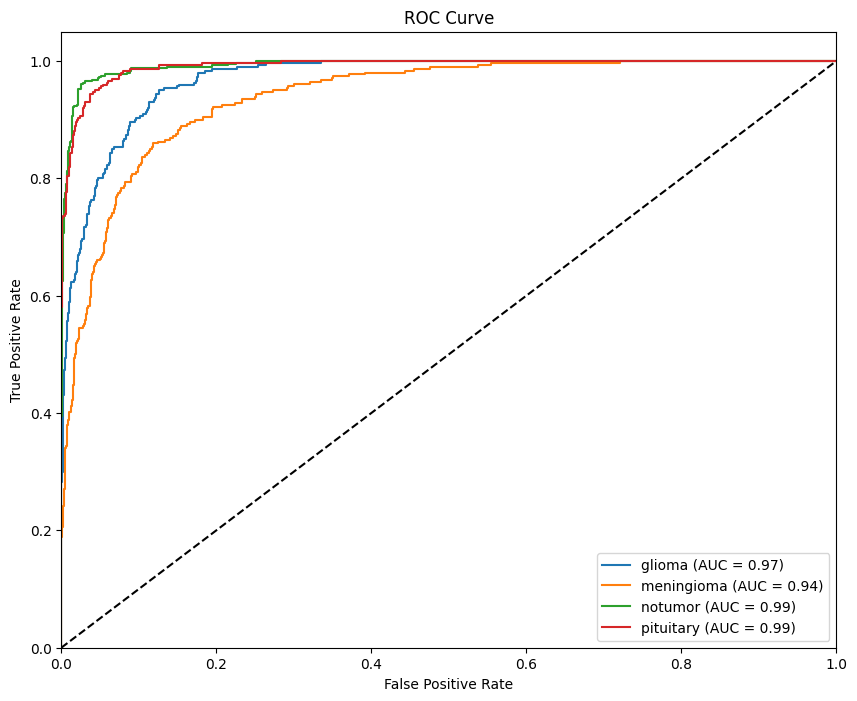

In [ ]:
# Evaluate on Test Set
print("\n=== Test Set Performance ===")

# Evaluate on test set
y_pred_prob_test, y_pred_test = evaluate_model(model_3, X_test, y_test, classes)

# Plot ROC curve for test set
plot_roc_auc(y_test, y_pred_prob_test, classes)

##### Final best model
    - Dropout rate: 0.07
    - Loss function: focal_loss
    - SMOTE

In [ ]:
# Use Focal Loss instead of categorical crossentropy
model_3.compile(optimizer=optimizer, loss=focal_loss(), metrics=['accuracy'])

# Train the model
model_3.fit(
    X_train_final, y_train_final,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=batch_size,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10
357/357 [==============================] - 33s 89ms/step - loss: 0.0067 - accuracy: 0.9701 - val_loss: 0.0407 - val_accuracy: 0.8741
Epoch 2/10
357/357 [==============================] - 38s 107ms/step - loss: 0.0040 - accuracy: 0.9811 - val_loss: 0.0420 - val_accuracy: 0.8787
Epoch 3/10
357/357 [==============================] - 45s 127ms/step - loss: 0.0032 - accuracy: 0.9830 - val_loss: 0.0429 - val_accuracy: 0.8734



=== Test Set Performance ===
41/41 [==============================] - 2s 39ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.84      0.82      0.83       300
  meningioma       0.77      0.80      0.78       306
     notumor       0.95      0.95      0.95       405
   pituitary       0.92      0.90      0.91       300

    accuracy                           0.87      1311
   macro avg       0.87      0.87      0.87      1311
weighted avg       0.88      0.87      0.87      1311

Confusion Matrix:
 [[247  44   1   8]
 [ 30 245  18  13]
 [  6  13 384   2]
 [ 11  17   2 270]]
Accuracy: 0.8741
Precision: 0.8753
Recall: 0.8741
F1-Score: 0.8746


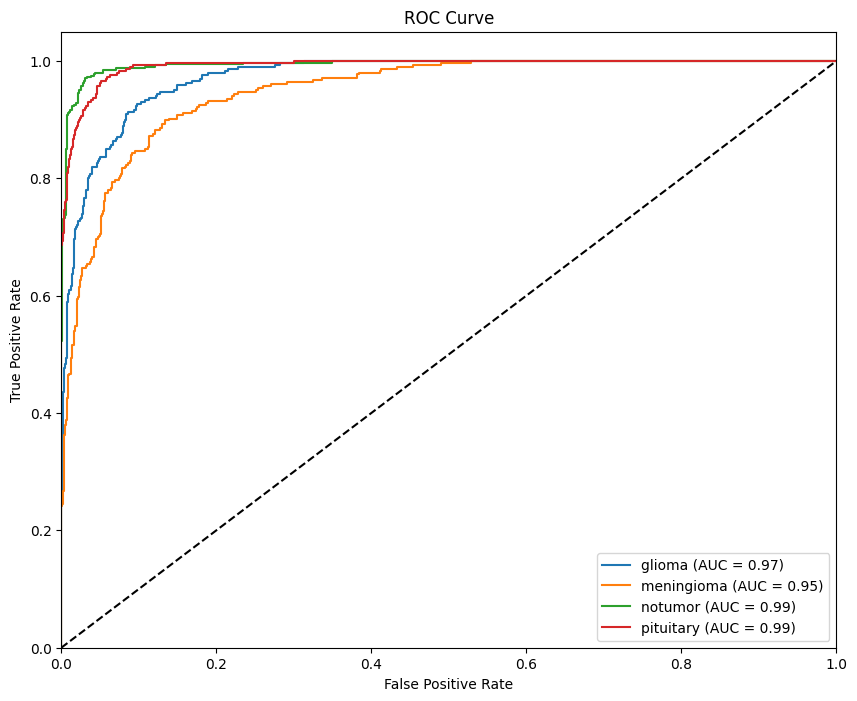

In [ ]:
# Evaluate on Test Set
print("\n=== Test Set Performance ===")

# Evaluate on test set
y_pred_prob_test, y_pred_test = evaluate_model(model_3, X_test, y_test, classes)

# Plot ROC curve for test set
plot_roc_auc(y_test, y_pred_prob_test, classes)

In [ ]:
# Apply SMOTE
smote = SMOTE(random_state=42, sampling_strategy=sampling_strategy)

# Flatten the image data for SMOTE
X_train_flat = X_train_final.reshape(len(X_train_final), -1)

# Convert one-hot encoded labels to class labels for SMOTE
y_train_classes = np.argmax(y_train_final, axis=1)

# Resample the training data using SMOTE
X_train_resampled_flat, y_train_resampled_classes = smote.fit_resample(X_train_flat, y_train_classes)

# Reshape the oversampled data back to image shape
X_train_resampled = X_train_resampled_flat.reshape(len(X_train_resampled_flat), 30, 30, 1)

# Convert labels back to one-hot encoding
y_train_resampled = tf.keras.utils.to_categorical(y_train_resampled_classes, num_classes=4)

# Shuffle the resampled dataset
X_train_resampled, y_train_resampled = shuffle(X_train_resampled, y_train_resampled, random_state=42)

# Train the model with Focal Loss
model_3.fit(
    X_train_resampled, y_train_resampled,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=batch_size,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10
360/360 [==============================] - 39s 107ms/step - loss: 0.0085 - accuracy: 0.9659 - val_loss: 0.0491 - val_accuracy: 0.8528
Epoch 2/10
360/360 [==============================] - 40s 111ms/step - loss: 0.0028 - accuracy: 0.9861 - val_loss: 0.0524 - val_accuracy: 0.8635
Epoch 3/10
360/360 [==============================] - 35s 97ms/step - loss: 0.0030 - accuracy: 0.9849 - val_loss: 0.0460 - val_accuracy: 0.8871
Epoch 4/10
360/360 [==============================] - 34s 94ms/step - loss: 5.3960e-04 - accuracy: 0.9976 - val_loss: 0.0471 - val_accuracy: 0.8825
Epoch 5/10
360/360 [==============================] - 34s 95ms/step - loss: 2.9694e-04 - accuracy: 0.9986 - val_loss: 0.0631 - val_accuracy: 0.8757



=== Test Set Performance ===
41/41 [==============================] - 2s 38ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.85      0.86      0.86       300
  meningioma       0.83      0.77      0.80       306
     notumor       0.95      0.97      0.96       405
   pituitary       0.89      0.93      0.91       300

    accuracy                           0.89      1311
   macro avg       0.88      0.88      0.88      1311
weighted avg       0.89      0.89      0.89      1311

Confusion Matrix:
 [[258  30   0  12]
 [ 34 235  18  19]
 [  3   6 391   5]
 [  7  11   3 279]]
Accuracy: 0.8871
Precision: 0.8859
Recall: 0.8871
F1-Score: 0.8860


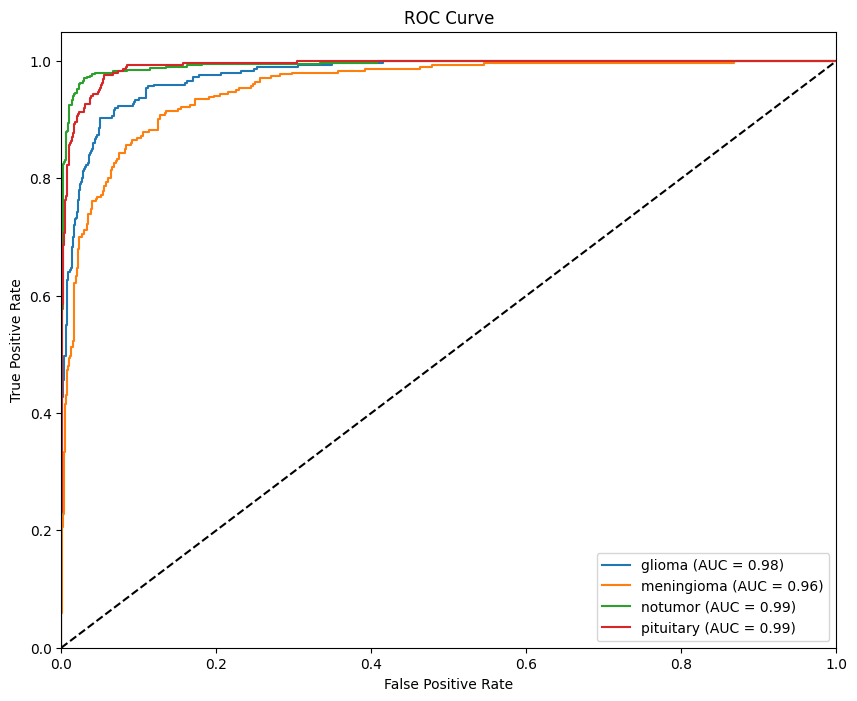

In [ ]:
# Evaluate on Test Set
print("\n=== Test Set Performance ===")

# Evaluate on test set
y_pred_prob_test, y_pred_test = evaluate_model(model_3, X_test, y_test, classes)

# Plot ROC curve for test set
plot_roc_auc(y_test, y_pred_prob_test, classes)

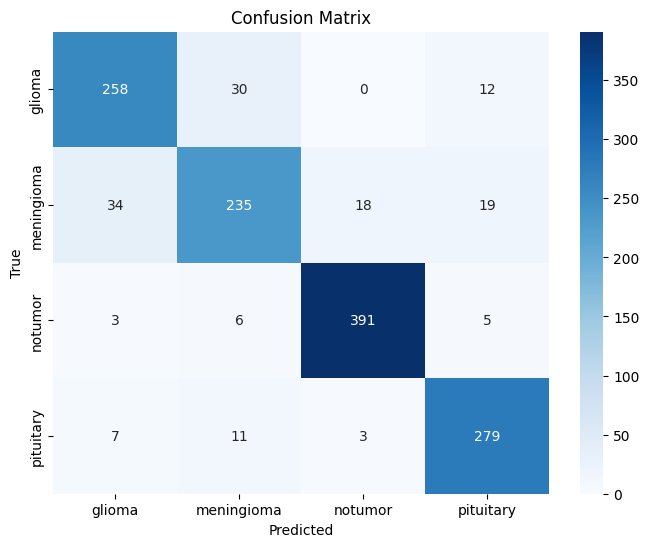

In [ ]:
# Plot confusion matrix for test set
plot_confusion_matrix(np.argmax(y_test, axis=1), y_pred_test, classes)

### **1.3 Transfer Learning (VGG16)**

##### Method 1: process images based on 30\*30\*1

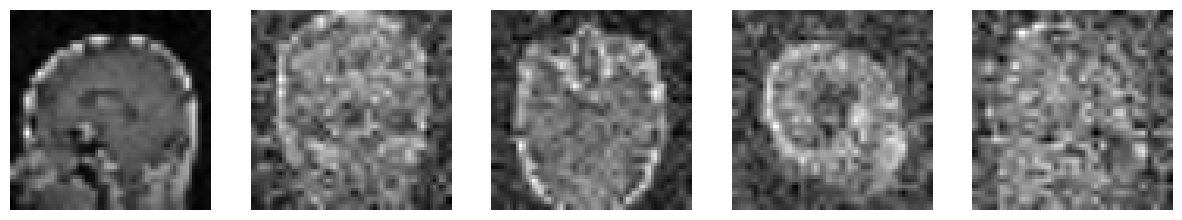

In [ ]:
# Resize images to 64*64
X_train_resized64 = np.array([cv2.resize(img.squeeze(), (64, 64)) for img in X_train_resampled])
X_test_resized64 = np.array([cv2.resize(img.squeeze(), (64, 64)) for img in X_test])

# Function to display images
def display_samples(images, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
    plt.show()

# Display a few resized training images to confirm they look correct
display_samples(X_train_resized64, num_samples=5)

In [ ]:
# Convert grayscale to RGB by repeating the channel
X_train_rgb = np.repeat(X_train_resized64[..., np.newaxis], 3, axis=-1)
X_test_rgb = np.repeat(X_test_resized64[..., np.newaxis], 3, axis=-1)

In [ ]:
# Build VGG16-Based Model with Custom Layers

# Load VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze all convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Build custom model on top of VGG16
model = models.Sequential()
model.add(base_model)

# Hyperparameters from model_3
dropout_rate = 0.07
units_dense = 162
learning_rate = 0.00031907383956506684

# Add fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(units_dense))
model.add(LeakyReLU(alpha=0.1))
model.add(layers.Dropout(dropout_rate))  # Use dropout rate from model_3
model.add(layers.Dense(64))
model.add(LeakyReLU(alpha=0.1))
model.add(layers.Dense(4, activation='softmax'))

# Step 4: Compile Model with Focal Loss
optimizer = optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss=focal_loss(), metrics=['accuracy'])

# Display model summary
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_9 (Flatten)         (None, 2048)              0         
                                                                 
 dense_33 (Dense)            (None, 162)               331938    
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 162)               0         
                                                                 
 dropout_12 (Dropout)        (None, 162)               0         
                                                                 
 dense_34 (Dense)            (None, 64)                10432     
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 64)              

In [ ]:
# Train the Model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True)

history = model.fit(
    X_train_rgb, y_train_resampled,
    validation_data=(X_test_rgb, y_test),
    epochs=16,  # Use the same number of epochs as model_3
    batch_size=8,  # Batch size from model_3
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate Model
test_loss, test_accuracy = model.evaluate(X_test_rgb, y_test)
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")

Epoch 1/16
719/719 [==============================] - 108s 150ms/step - loss: 0.0610 - accuracy: 0.7557 - val_loss: 0.0877 - val_accuracy: 0.6766
Epoch 2/16
719/719 [==============================] - 117s 162ms/step - loss: 0.0574 - accuracy: 0.7673 - val_loss: 0.0999 - val_accuracy: 0.6545
Epoch 3/16
719/719 [==============================] - 118s 164ms/step - loss: 0.0564 - accuracy: 0.7758 - val_loss: 0.0900 - val_accuracy: 0.6827
Epoch 4/16
719/719 [==============================] - 110s 153ms/step - loss: 0.0532 - accuracy: 0.7823 - val_loss: 0.0846 - val_accuracy: 0.7018
Epoch 5/16
719/719 [==============================] - 116s 161ms/step - loss: 0.0534 - accuracy: 0.7840 - val_loss: 0.0795 - val_accuracy: 0.7208
Epoch 6/16
719/719 [==============================] - 115s 159ms/step - loss: 0.0504 - accuracy: 0.7929 - val_loss: 0.0873 - val_accuracy: 0.7117
Epoch 7/16
719/719 [==============================] - 119s 165ms/step - loss: 0.0487 - accuracy: 0.7999 - val_loss: 0.0928 -

##### Method 2: directly resize image

In [ ]:
np.random.seed(seed=42)
def add_noise(img):
  std_coeff = 70*np.random.random()
  noise = np.random.normal(0, std_coeff, img.shape)
  img += noise
  np.clip(img, 0., 255.)
  return img

image_res = 128  # change size
def get_images(train_dir: str, test_dir: str):
  datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=add_noise)

  img_height, img_width = image_res, image_res
  batch_size = 32

  # Load training data
  train_data = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    color_mode='rgb'   # change to rgb
  )

  # Load test data
  test_data = datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    color_mode='rgb'
  )

  return train_data, test_data

# Load the training and test data
try:
  train_data, test_data = get_images(train_images_dir, test_images_dir)
  print("Data loading completed successfully.")
  print(f"Number of training samples: {train_data.samples}")
  print(f"Number of test samples: {test_data.samples}")
  print(f"Class names: {train_data.class_indices}")
except Exception as e:
  print(f"Error loading data: {e}")

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Data loading completed successfully.
Number of training samples: 5712
Number of test samples: 1311
Class names: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [ ]:
# Fetch all images and labels from train_data using next()
def extract_data_from_generator(data_generator):
  images, labels = [], []

  # Total batches in the generator
  steps = len(data_generator)

    # Loop through all batches
  for _ in range(steps):
    batch_images, batch_labels = next(data_generator)
    images.append(batch_images)
    labels.append(batch_labels)

  # Convert list of arrays to a single numpy array
  images = np.concatenate(images)
  labels = np.concatenate(labels)

  return images, labels

# Extract all data from train_data
train_images, train_labels = extract_data_from_generator(train_data)

# Now split into 80% training and 20% validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42, shuffle=True)

print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Validation labels shape: {y_val.shape}")

Training data shape: (4569, 128, 128, 3), Training labels shape: (4569, 4)
Validation data shape: (1143, 128, 128, 3), Validation labels shape: (1143, 4)


In [ ]:
# Extract all data from test_data

def extract_data_from_generator(data_generator):
    images, labels = [], []
    steps = len(data_generator)
    
    for _ in range(steps):
        batch_images, batch_labels = next(data_generator)
        images.append(batch_images)
        labels.append(batch_labels)

    images = np.concatenate(images)
    labels = np.concatenate(labels)
    
    return images, labels

X_test, y_test = extract_data_from_generator(test_data)

print(f"Test images shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")

Test images shape: (1311, 128, 128, 3)
Test labels shape: (1311, 4)


Epoch 1/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 265s 927ms/step - accuracy: 0.5407 - loss: 1.0673 - val_accuracy: 0.7165 - val_loss: 0.7024 - learning_rate: 0.0010
Epoch 2/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 269s 940ms/step - accuracy: 0.7367 - loss: 0.6421 - val_accuracy: 0.7367 - val_loss: 0.6357 - learning_rate: 0.0010
Epoch 3/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 289s 1s/step - accuracy: 0.7721 - loss: 0.5707 - val_accuracy: 0.7857 - val_loss: 0.5438 - learning_rate: 0.0010
Epoch 4/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 288s 1s/step - accuracy: 0.7967 - loss: 0.5139 - val_accuracy: 0.7848 - val_loss: 0.5275 - learning_rate: 0.0010
Epoch 5/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 287s 1s/step - accuracy: 0.8044 - loss: 0.4846 - val_accuracy: 0.8058 - val_loss: 0.4762 - learning_rate: 0.0010
Epoch 6/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 300s 1s/step - accuracy: 0.8096 - loss: 0.4630 - val_accuracy: 0.8093 - val_loss: 0.4676 - learning_rate: 0.0010
Epoch 7/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 314s 1s/step - accuracy: 0.8197 - lo

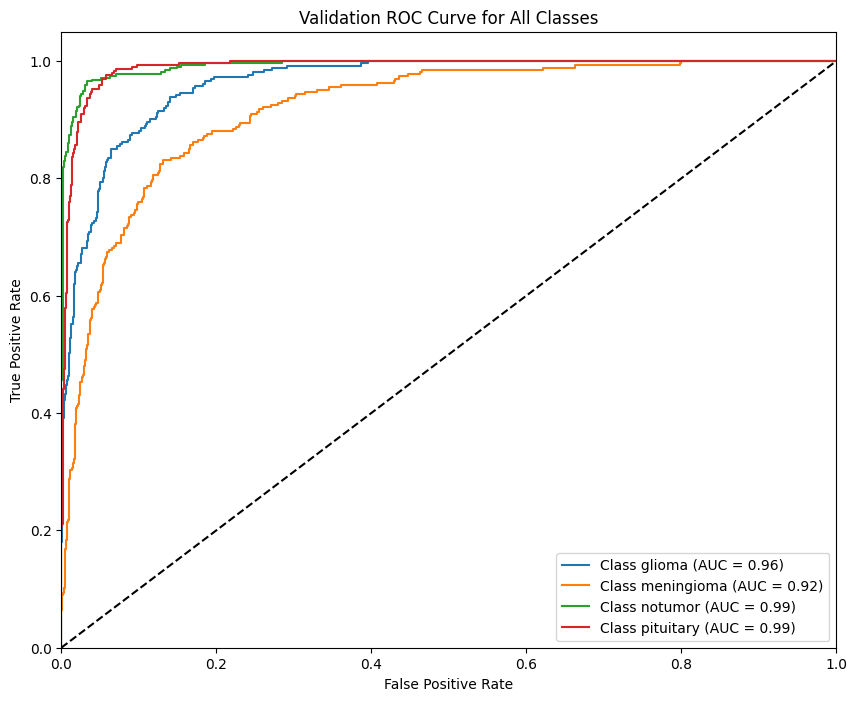

Validation Confusion Matrix:
[[196  54   3   8]
 [ 36 191  17  23]
 [  4   9 294   9]
 [  1  13   1 284]]
Validation Classification Report:
              precision    recall  f1-score   support

      glioma       0.83      0.75      0.79       261
  meningioma       0.72      0.72      0.72       267
     notumor       0.93      0.93      0.93       316
   pituitary       0.88      0.95      0.91       299

    accuracy                           0.84      1143
   macro avg       0.84      0.84      0.84      1143
weighted avg       0.84      0.84      0.84      1143



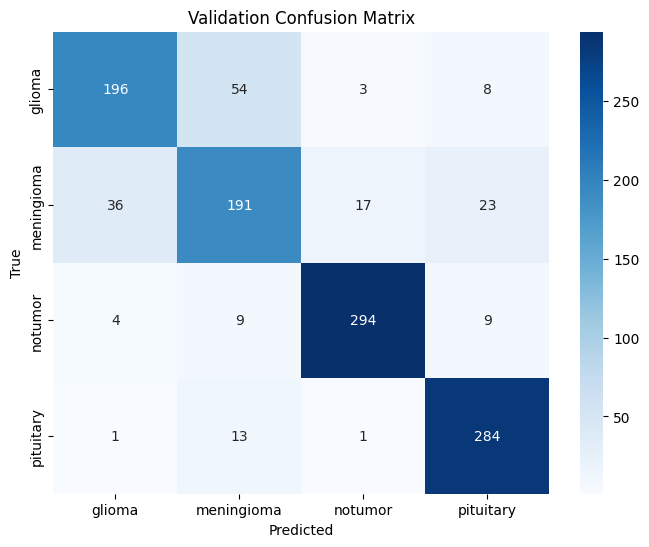

36/36 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.8447 - loss: 0.3723
Validation Accuracy: 0.8442694544792175
Validation Loss: 0.3819708824157715
41/41 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step
Test AUC Score: 0.9553


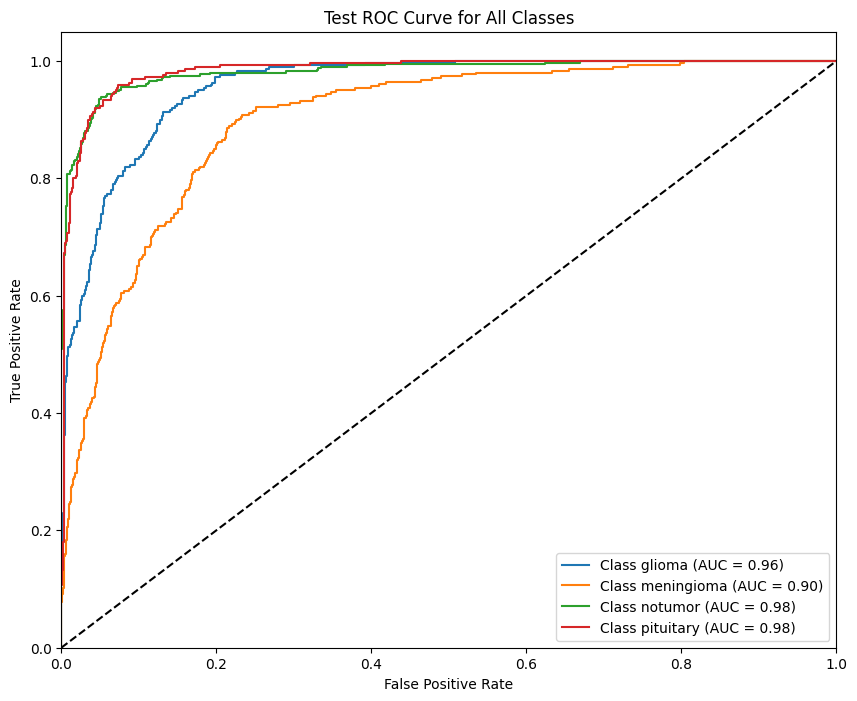

Test Confusion Matrix:
[[221  62   5  12]
 [ 39 192  41  34]
 [  9  14 378   4]
 [  8  12   2 278]]
Test Classification Report:
              precision    recall  f1-score   support

      glioma       0.80      0.74      0.77       300
  meningioma       0.69      0.63      0.66       306
     notumor       0.89      0.93      0.91       405
   pituitary       0.85      0.93      0.89       300

    accuracy                           0.82      1311
   macro avg       0.80      0.81      0.80      1311
weighted avg       0.81      0.82      0.81      1311



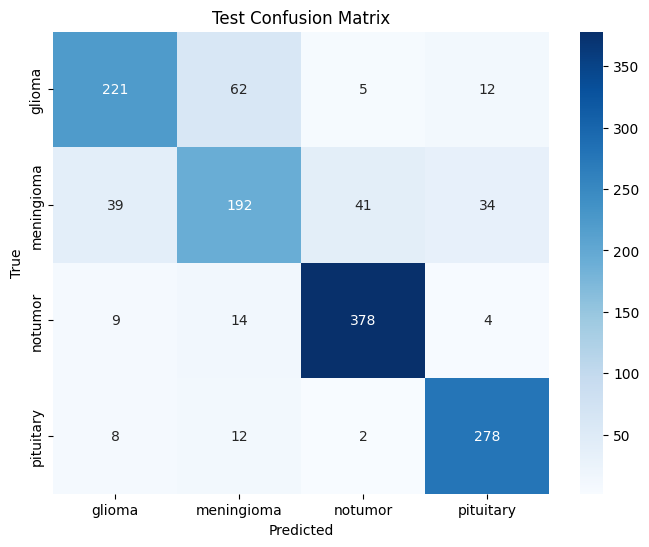

41/41 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.7457 - loss: 0.5922
Test Accuracy: 0.8154081106185913
Test Loss: 0.4612266719341278


In [ ]:
# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the VGG16 layers
for layer in base_model.layers:
    layer.trainable = False  

# Initialize a new model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=1e-6)

# Train model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), 
                    batch_size=16,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

# Generic evaluation function: evaluate performance and plot ROC curve
def evaluate_and_plot_roc(model, test_images, test_labels, dataset_name, classes):
    # Predictions
    y_pred_prob = model.predict(test_images)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_classes = np.argmax(test_labels, axis=1)

    # Calculate AUC score
    auc_score = roc_auc_score(test_labels, y_pred_prob, multi_class='ovr')
    print(f"{dataset_name} AUC Score: {auc_score:.4f}")

    # ROC Curve plotting
    y_true_bin = label_binarize(y_true_classes, classes=range(len(classes)))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    plt.figure(figsize=(10, 8))
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

    # Random classifier reference line
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{dataset_name} ROC Curve for All Classes')
    plt.legend(loc='lower right')
    plt.show()

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true_classes, y_pred)
    print(f"{dataset_name} Confusion Matrix:")
    print(conf_matrix)

    # Print classification report
    print(f"{dataset_name} Classification Report:")
    print(classification_report(y_true_classes, y_pred, target_names=classes))

    # Confusion matrix visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{dataset_name} Confusion Matrix')
    plt.show()

    # Final evaluation on the dataset
    loss, acc = model.evaluate(test_images, test_labels)
    print(f"{dataset_name} Accuracy: {acc}")
    print(f"{dataset_name} Loss: {loss}")

# Evaluate on the validation set
evaluate_and_plot_roc(model, X_val, y_val, "Validation", classes=['glioma', 'meningioma', 'notumor', 'pituitary'])

# Evaluate on the test set
evaluate_and_plot_roc(model, X_test, y_test, "Test", classes=['glioma', 'meningioma', 'notumor', 'pituitary'])

In [ ]:
# Try GLCM Energy Feature Extraction

# Function to extract all images and labels from a generator
def extract_data_from_generator(data_generator):
    images, labels = [], []
    steps = len(data_generator)

    # Extract all batches
    for _ in range(steps):
        batch_images, batch_labels = next(data_generator)
        images.append(batch_images)
        labels.append(batch_labels)

    # Convert list of arrays to a single numpy array
    images = np.concatenate(images)
    labels = np.concatenate(labels)

    return images, labels

# GLCM feature extraction function
def extract_glcm_energy(images):
    glcm_energy_features = []
    
    # Loop through each image to compute GLCM energy
    for img in images:
        # Convert image to grayscale
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray_img = gray_img.astype(np.uint8)
        
        # Calculate GLCM and energy feature
        glcm = graycomatrix(gray_img, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
        energy = graycoprops(glcm, prop='energy')[0, 0]  # Extract energy feature

        # Create an array of the same size as the image, filled with the energy value
        energy_array = np.full((gray_img.shape[0], gray_img.shape[1], 1), energy)
        
        # Append energy feature to the list
        glcm_energy_features.append(energy_array)

    # Convert list of GLCM energy features to a numpy array
    return np.array(glcm_energy_features)

# Set the paths for the dataset directories
data_dir = '/Users/joco2021/Desktop/DSS/master/Block 1/deep learning/group project'
train_images_dir = os.path.join(data_dir, 'Training')
test_images_dir = os.path.join(data_dir, 'Testing')

print(f"Data directory: {data_dir}")
print(f"Training directory: {train_images_dir}")
print(f"Testing directory: {test_images_dir}")

# Check if the directories exist
if not os.path.exists(train_images_dir) or not os.path.exists(test_images_dir):
    print("One or both of the directories do not exist. Please check the paths.")
    exit()

# Load the training and test data
train_data, test_data = get_images(train_images_dir, test_images_dir)

# Extract all images and labels from train_data
train_images, train_labels = extract_data_from_generator(train_data)

# Split the data into 80% training and 20% validation sets
X_train_CE_MRI, X_val_CE_MRI, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Extract GLCM energy features from the training and validation sets
X_train_GLCM = extract_glcm_energy(X_train_CE_MRI)
X_val_GLCM = extract_glcm_energy(X_val_CE_MRI)

# Extract test images and labels, then GLCM energy features
X_test_CE_MRI, y_test = extract_data_from_generator(test_data)
X_test_GLCM = extract_glcm_energy(X_test_CE_MRI)

print(f"Training CE-MRI shape: {X_train_CE_MRI.shape}, Training GLCM shape: {X_train_GLCM.shape}")
print(f"Validation CE-MRI shape: {X_val_CE_MRI.shape}, Validation GLCM shape: {X_val_GLCM.shape}")
print(f"Test CE-MRI shape: {X_test_CE_MRI.shape}, Test GLCM shape: {X_test_GLCM.shape}")

Data directory: /Users/joco2021/Desktop/DSS/master/Block 1/deep learning/group project
Training directory: /Users/joco2021/Desktop/DSS/master/Block 1/deep learning/group project/Training
Testing directory: /Users/joco2021/Desktop/DSS/master/Block 1/deep learning/group project/Testing
Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Training CE-MRI shape: (4569, 128, 128, 3), Training GLCM shape: (4569, 128, 128, 1)
Validation CE-MRI shape: (1143, 128, 128, 3), Validation GLCM shape: (1143, 128, 128, 1)
Test CE-MRI shape: (1311, 128, 128, 3), Test GLCM shape: (1311, 128, 128, 1)


Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 128, 128,  │      1,792 │ input_layer_18[0… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 128, 128,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 64, 64,    │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 64, 64,    │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 64, 64,    │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 32, 32,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 32, 32,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 32, 32,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 32, 32,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 16, 16,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 16, 16,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 16, 16,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 16, 16,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 8, 8, 512) │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_19      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 8, 8, 512) │  2,359,808 │ block4_pool[0][0

 Total params: 29,611,460 (112.96 MB)

 Trainable params: 14,896,772 (56.83 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 317s 1s/step - accuracy: 0.5092 - loss: 1.3952 - val_accuracy: 0.7358 - val_loss: 0.7582 - learning_rate: 0.0010
Epoch 2/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 328s 1s/step - accuracy: 0.7113 - loss: 0.7424 - val_accuracy: 0.7542 - val_loss: 0.6426 - learning_rate: 0.0010
Epoch 3/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 338s 1s/step - accuracy: 0.7442 - loss: 0.6439 - val_accuracy: 0.7725 - val_loss: 0.5767 - learning_rate: 0.0010
Epoch 4/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 342s 1s/step - accuracy: 0.7710 - loss: 0.5852 - val_accuracy: 0.7909 - val_loss: 0.5570 - learning_rate: 0.0010
Epoch 5/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 329s 1s/step - accuracy: 0.7865 - loss: 0.5591 - val_accuracy: 0.8040 - val_loss: 0.5099 - learning_rate: 0.0010
Epoch 6/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 321s 1s/step - accuracy: 0.7902 - loss: 0.5162 - val_accuracy: 0.8101 - val_loss: 0.4867 - learning_rate: 0.0010
Epoch 7/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 290s 1s/step - accuracy: 0.8002 - loss: 0.

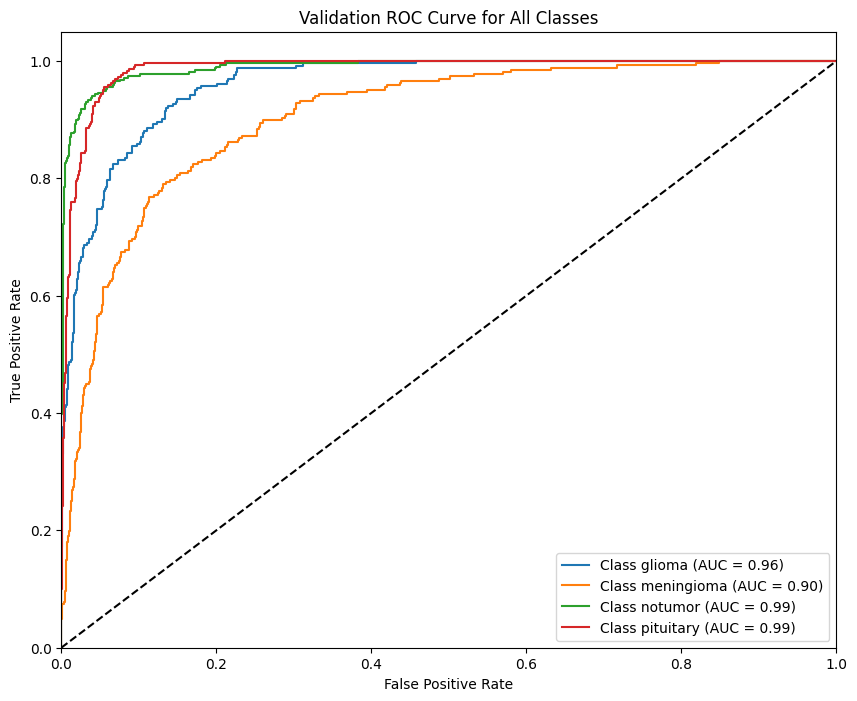

Validation Confusion Matrix:
[[218  34   1   8]
 [ 56 164  17  30]
 [  5   9 286  16]
 [  3   9   0 287]]
Validation Classification Report:
              precision    recall  f1-score   support

      glioma       0.77      0.84      0.80       261
  meningioma       0.76      0.61      0.68       267
     notumor       0.94      0.91      0.92       316
   pituitary       0.84      0.96      0.90       299

    accuracy                           0.84      1143
   macro avg       0.83      0.83      0.83      1143
weighted avg       0.83      0.84      0.83      1143



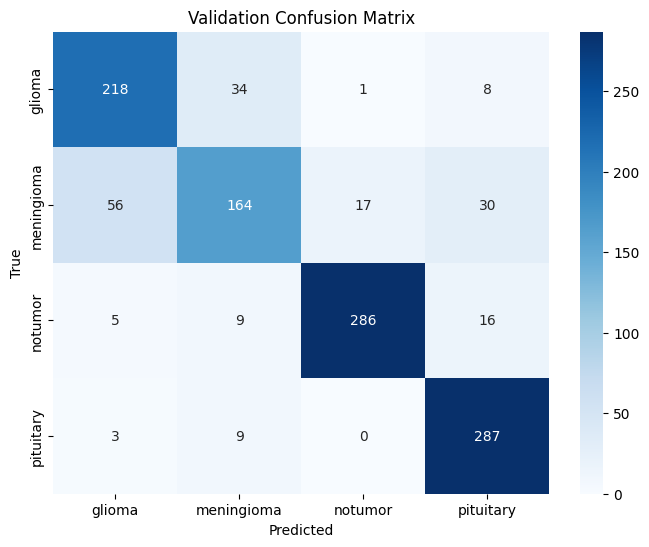

36/36 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.8405 - loss: 0.4150
Validation Accuracy: 0.8355205655097961
Validation Loss: 0.4305950403213501
41/41 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step
Test AUC Score: 0.9467


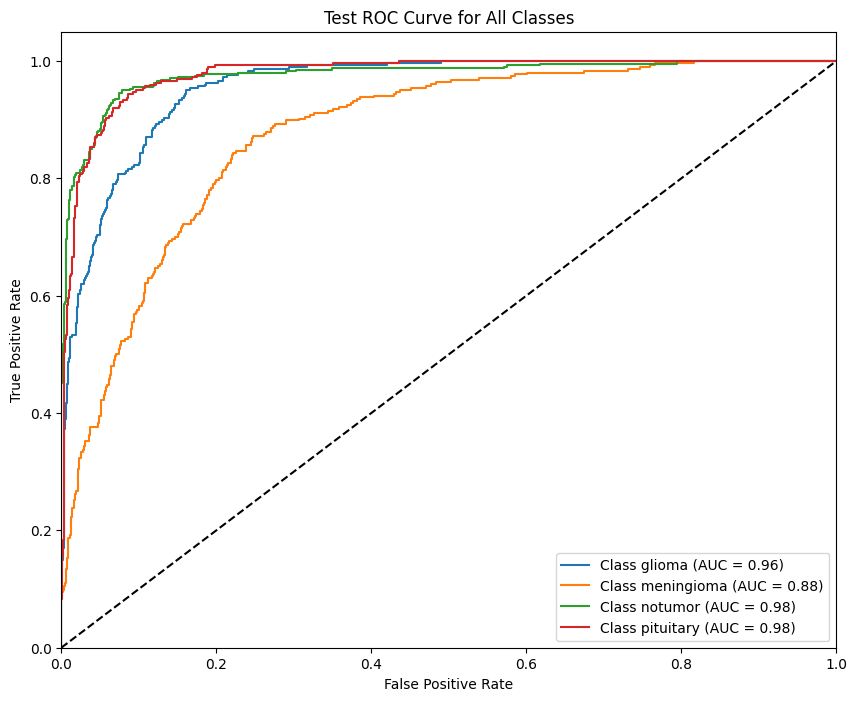

Test Confusion Matrix:
[[246  38   5  11]
 [ 61 152  37  56]
 [ 20  29 348   8]
 [ 12  10   2 276]]
Test Classification Report:
              precision    recall  f1-score   support

      glioma       0.73      0.82      0.77       300
  meningioma       0.66      0.50      0.57       306
     notumor       0.89      0.86      0.87       405
   pituitary       0.79      0.92      0.85       300

    accuracy                           0.78      1311
   macro avg       0.77      0.77      0.76      1311
weighted avg       0.78      0.78      0.77      1311



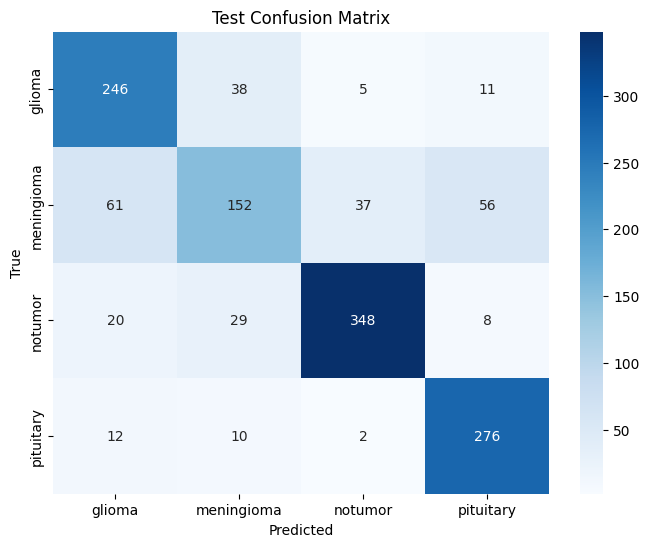

41/41 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.7357 - loss: 0.5991
Test Accuracy: 0.7795575857162476
Test Loss: 0.5178079605102539


In [ ]:
# CNN1: Using pre-trained VGG16 for CE-MRI images (RGB)
input_CE_MRI = Input(shape=(128, 128, 3))
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_CE_MRI)

# Freeze VGG16 layers to prevent them from being updated during training
for layer in base_model.layers:
    layer.trainable = False

# Extract global features from the VGG16 model
x1 = base_model.output
x1 = GlobalAveragePooling2D()(x1)

# CNN2: Processing GLCM energy images (Grayscale)
input_GLCM = Input(shape=(128, 128, 1))
x2 = Conv2D(32, (3, 3), activation='relu')(input_GLCM)
x2 = MaxPooling2D((2, 2))(x2)
x2 = Conv2D(64, (3, 3), activation='relu')(x2)
x2 = MaxPooling2D((2, 2))(x2)
x2 = Flatten()(x2)

# Combine the output of CNN1 and CNN2
combined = concatenate([x1, x2])

# Add fully connected layers for classification
z = Dense(256, activation='relu')(combined)
z = Dropout(0.5)(z)
output = Dense(4, activation='softmax')(z)

# Create the final model
model = Model(inputs=[input_CE_MRI, input_GLCM], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Define callbacks for early stopping, checkpoint saving, and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=1e-6)

# Train the model
history = model.fit([X_train_CE_MRI, X_train_GLCM], y_train, 
                    validation_data=([X_val_CE_MRI, X_val_GLCM], y_val), 
                    epochs=10, batch_size=16, 
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

# General function to evaluate performance and plot ROC curve
def evaluate_and_plot_roc(model, test_images, test_labels, dataset_name, classes):
    # Get predicted probabilities
    y_pred_prob = model.predict(test_images)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_classes = np.argmax(test_labels, axis=1)

    # Calculate AUC score
    auc_score = roc_auc_score(test_labels, y_pred_prob, multi_class='ovr')
    print(f"{dataset_name} AUC Score: {auc_score:.4f}")

    # Generate ROC curves for each class
    y_true_bin = label_binarize(y_true_classes, classes=range(len(classes)))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    plt.figure(figsize=(10, 8))
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{dataset_name} ROC Curve for All Classes')
    plt.legend(loc='lower right')
    plt.show()

    # Confusion matrix and classification report
    conf_matrix = confusion_matrix(y_true_classes, y_pred)
    print(f"{dataset_name} Confusion Matrix:")
    print(conf_matrix)

    print(f"{dataset_name} Classification Report:")
    print(classification_report(y_true_classes, y_pred, target_names=classes))

    # Plot confusion matrix heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{dataset_name} Confusion Matrix')
    plt.show()

    # Model evaluation
    loss, acc = model.evaluate(test_images, test_labels)
    print(f"{dataset_name} Accuracy: {acc}")
    print(f"{dataset_name} Loss: {loss}")

# Evaluate on the validation set
evaluate_and_plot_roc(model, [X_val_CE_MRI, X_val_GLCM], y_val, "Validation", classes=['glioma', 'meningioma', 'notumor', 'pituitary'])

# Evaluate on the test set
evaluate_and_plot_roc(model, [X_test_CE_MRI, X_test_GLCM], y_test, "Test", classes=['glioma', 'meningioma', 'notumor', 'pituitary'])

# Part2: Other attempts

This code is represented by the flow chart below.

<img src="Group9-attempt.png" alt="Simple while-loop" style="width:800px;"><br>
<div align="center">Figure 2: Code for other attempts.</div>

### **2.1 Improved Model**

#### 2.1.1 Hyperparameter Tuning

##### - Method 1: optuna

In [ ]:
# Trial 1:
# This code tried the following hyperparameters:
#     - number of convolutional layers
#     - number of filters
#     - filter size
#     - activation function
#     - units in dense layers
#     - learning rate

def objective(trial):
    model = models.Sequential()
    
    # Hyperparameter 1: Number of convolutional layers
    n_conv_layers = trial.suggest_int('n_conv_layers', 2, 5)
    
    input_shape = (30, 30, 1)
    for i in range(n_conv_layers):
        # Hyperparameter 2: Number of filters
        filters = trial.suggest_int(f'filters_{i}', 32, 128, log=True)
        
        # Hyperparameter 3: Filter size (Kernel size)
        kernel_size = trial.suggest_categorical(f'kernel_size_{i}', [3, 5])
        
        # Hyperparameter 4: Activation function
        activation = trial.suggest_categorical('activation', ['relu', 'leaky_relu'])
        
        # Add convolutional layer with padding to preserve dimensions
        if i == 0:
            model.add(layers.Conv2D(filters, kernel_size=kernel_size, activation=activation, padding='same', input_shape=input_shape))
        else:
            model.add(layers.Conv2D(filters, kernel_size=kernel_size, activation=activation, padding='same'))
        
        # Check spatial dimensions and apply pooling only if height/width is greater than 2
        if model.output_shape[1] > 2 and model.output_shape[2] > 2:
            model.add(layers.MaxPooling2D(pool_size=2))
    
    model.add(layers.Flatten())
    
    # Hyperparameter 5: Units in dense layers
    units = trial.suggest_int('units_dense', 64, 256, log=True)
    model.add(layers.Dense(units, activation=activation))
    
    model.add(layers.Dense(4, activation='softmax'))

    # Hyperparameter 6: Learning rate
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    
    # Compile the model
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Define an early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True)
    
    # Train the model
    history = model.fit(
        X_train, y_train,               # Training data
        validation_data=(X_val, y_val), # Validation data
        epochs=10,                      # Number of epochs
        batch_size=32,                  # Batch size
        callbacks=[early_stopping],     # Early stopping to prevent overfitting
        verbose=0                       # Set verbose to 0 to avoid too much output
    )
    
    # Get the validation accuracy
    val_accuracy = history.history['val_accuracy'][-1]
    
    # Return the validation accuracy to maximize it
    return val_accuracy

# Run the Optuna optimization process
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Print the best parameters found by Optuna
print("Best hyperparameters: ", study.best_trial.params)

[I 2024-09-23 21:20:10,771] A new study created in memory with name: no-name-c18b9214-659d-4b6e-a747-e2681efcd5ae


[I 2024-09-23 21:20:32,695] Trial 0 finished with value: 0.7795275449752808 and parameters: {'n_conv_layers': 4, 'filters_0': 79, 'kernel_size_0': 5, 'activation': 'leaky_relu', 'filters_1': 33, 'kernel_size_1': 5, 'filters_2': 32, 'kernel_size_2': 3, 'filters_3': 115, 'kernel_size_3': 5, 'units_dense': 97, 'learning_rate': 0.004822221250748691}. Best is trial 0 with value: 0.7795275449752808.
[I 2024-09-23 21:20:55,427] Trial 1 finished with value: 0.7909011244773865 and parameters: {'n_conv_layers': 2, 'filters_0': 113, 'kernel_size_0': 3, 'activation': 'leaky_relu', 'filters_1': 33, 'kernel_size_1': 5, 'units_dense': 67, 'learning_rate': 0.0007933983325372231}. Best is trial 1 with value: 0.7909011244773865.
[I 2024-09-23 21:21:35,279] Trial 2 finished with value: 0.8355205655097961 and parameters: {'n_conv_layers': 2, 'filters_0': 88, 'kernel_size_0': 5, 'activation': 'leaky_relu', 'filters_1': 73, 'kernel_size_1': 5, 'units_dense': 150, 'learning_rate': 0.0004100855174134456}. Bes

Best hyperparameters:  {'n_conv_layers': 2, 'filters_0': 88, 'kernel_size_0': 5, 'activation': 'leaky_relu', 'filters_1': 73, 'kernel_size_1': 5, 'units_dense': 150, 'learning_rate': 0.0004100855174134456}



=== Test Set Performance ===
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.69      0.88      0.78       300
  meningioma       0.69      0.58      0.63       306
     notumor       0.91      0.91      0.91       405
   pituitary       0.92      0.81      0.87       300

    accuracy                           0.80      1311
   macro avg       0.80      0.80      0.79      1311
weighted avg       0.81      0.80      0.80      1311

Confusion Matrix:
 [[264  30   0   6]
 [ 81 179  35  11]
 [ 11  24 367   3]
 [ 25  28   3 244]]
Accuracy: 0.8040
Precision: 0.8101
Recall: 0.8040
F1-Score: 0.8027


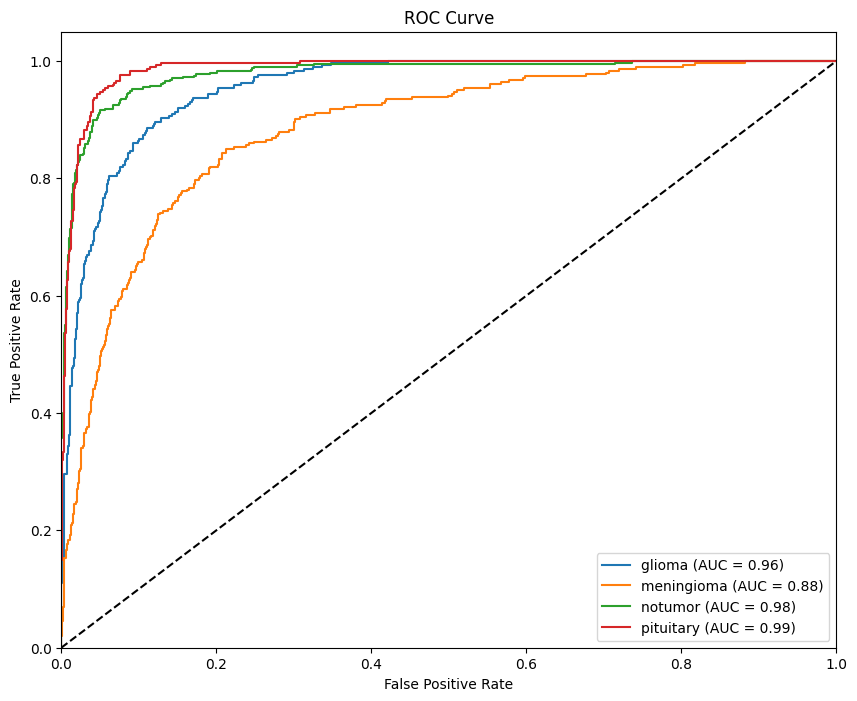

In [ ]:
# Evaluate on test set
print("\n=== Test Set Performance ===")

# Evaluate on test set
y_pred_prob_test, y_pred_test = evaluate_model(model_1, X_test, y_test, classes)

# Plot ROC curve for test set
plot_roc_auc(y_test, y_pred_prob_test, classes)

In [ ]:
# Trial 3:
# This code tried the following hyperparameters:
    # - Number of Convolutional Layers
    # - Number of Filters
    # - Filter Size
    # - Activation Function
    # - Pooling Type
    # - Dropout Rate
    # - Batch Size
    # - Optimizer Type
    # - Momentum

def objective_model_3(trial):
    model = models.Sequential()
    
    # Hyperparameter 1: Number of convolutional layers
    n_conv_layers = trial.suggest_int('n_conv_layers', 2, 5)
    
    input_shape = (30, 30, 1)
    for i in range(n_conv_layers):
        # Hyperparameter 2: Number of filters
        filters = trial.suggest_int(f'filters_{i}', 32, 128, log=True)
        
        # Hyperparameter 3: Filter size (Kernel size)
        kernel_size = trial.suggest_categorical(f'kernel_size_{i}', [3, 5])
        
        # Hyperparameter 4: Activation function
        activation = trial.suggest_categorical('activation', ['relu', 'leaky_relu'])
        
        # Add convolutional layer with padding to preserve dimensions
        if i == 0:
            model.add(layers.Conv2D(filters, kernel_size=kernel_size, activation=activation, padding='same', input_shape=input_shape))
        else:
            model.add(layers.Conv2D(filters, kernel_size=kernel_size, activation=activation, padding='same'))
        
        # Hyperparameter 5: Pooling type
        pooling_type = trial.suggest_categorical('pooling_type', ['max', 'average'])
        if model.output_shape[1] > 2 and model.output_shape[2] > 2:
            if pooling_type == 'max':
                model.add(layers.MaxPooling2D(pool_size=(2, 2)))
            else:
                model.add(layers.AveragePooling2D(pool_size=(2, 2)))
    
    # Add Global Average Pooling instead of Flatten
    model.add(layers.GlobalAveragePooling2D())
    
    # Hyperparameter 6: Dropout rate
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    model.add(layers.Dropout(dropout_rate))
    
    # Output layer
    num_classes = 4
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Hyperparameter 7: Batch size
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    
    # Hyperparameter 8: Optimizer type
    optimizer_type = trial.suggest_categorical('optimizer_type', ['adam', 'sgd', 'rmsprop'])
    
    # Hyperparameter 9: Momentum (for SGD)
    momentum = trial.suggest_float('momentum', 0.0, 0.9)

    # Compile the model
    if optimizer_type == 'adam':
        optimizer = optimizers.Adam()
    elif optimizer_type == 'sgd':
        optimizer = optimizers.SGD(momentum=momentum)
    else:  # rmsprop
        optimizer = optimizers.RMSprop()

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Define an early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True)
    
    # Train the model
    history = model.fit(
        X_train, y_train,               # Training data
        validation_data=(X_val, y_val), # Validation data
        epochs=10,                      # Number of epochs
        batch_size=batch_size,          # Batch size
        callbacks=[early_stopping],     # Early stopping to prevent overfitting
        verbose=0                       # Set verbose to 0 to avoid too much output
    )
    
    # Get the validation accuracy
    val_accuracy = history.history['val_accuracy'][-1]
    
    # Return the validation accuracy to maximize it
    return val_accuracy

# Run the Optuna optimization process for model 3
study_model_3 = optuna.create_study(direction='maximize')
study_model_3.optimize(objective_model_3, n_trials=20)

# Print the best parameters found by Optuna
print("Best hyperparameters for model 3: ", study_model_3.best_trial.params)


[I 2024-09-23 21:47:45,868] A new study created in memory with name: no-name-0eeb3516-4864-48a4-adf0-187f429673d6
[I 2024-09-23 21:48:04,537] Trial 0 finished with value: 0.27646544575691223 and parameters: {'n_conv_layers': 5, 'filters_0': 32, 'kernel_size_0': 5, 'activation': 'relu', 'pooling_type': 'average', 'filters_1': 91, 'kernel_size_1': 5, 'filters_2': 61, 'kernel_size_2': 3, 'filters_3': 32, 'kernel_size_3': 5, 'filters_4': 41, 'kernel_size_4': 3, 'dropout_rate': 0.2161034570492555, 'batch_size': 64, 'optimizer_type': 'sgd', 'momentum': 0.11922389525322494}. Best is trial 0 with value: 0.27646544575691223.
[I 2024-09-23 21:48:13,905] Trial 1 finished with value: 0.5310586094856262 and parameters: {'n_conv_layers': 2, 'filters_0': 32, 'kernel_size_0': 3, 'activation': 'leaky_relu', 'pooling_type': 'average', 'filters_1': 51, 'kernel_size_1': 3, 'dropout_rate': 0.032062537518439405, 'batch_size': 32, 'optimizer_type': 'sgd', 'momentum': 0.1825709694281327}. Best is trial 1 with

Best hyperparameters for model 3:  {'n_conv_layers': 5, 'filters_0': 123, 'kernel_size_0': 3, 'activation': 'relu', 'pooling_type': 'max', 'filters_1': 98, 'kernel_size_1': 5, 'filters_2': 74, 'kernel_size_2': 5, 'filters_3': 95, 'kernel_size_3': 5, 'filters_4': 128, 'kernel_size_4': 5, 'dropout_rate': 0.10491971913672465, 'batch_size': 32, 'optimizer_type': 'rmsprop', 'momentum': 0.26913437090044107}



=== Test Set Performance ===
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.83      0.65      0.73       300
  meningioma       0.64      0.66      0.65       306
     notumor       0.82      0.94      0.88       405
   pituitary       0.87      0.85      0.86       300

    accuracy                           0.79      1311
   macro avg       0.79      0.78      0.78      1311
weighted avg       0.79      0.79      0.79      1311

Confusion Matrix:
 [[196  85   4  15]
 [ 29 202  58  17]
 [  5  12 382   6]
 [  6  17  22 255]]
Accuracy: 0.7895
Precision: 0.7916
Recall: 0.7895
F1-Score: 0.7867


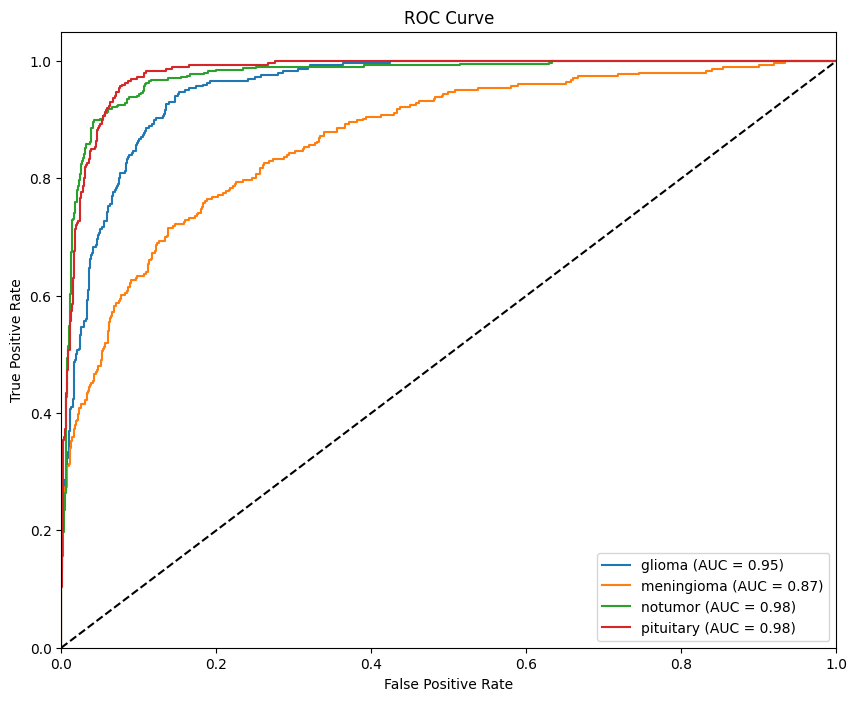

In [ ]:
# Evaluate on test set
print("\n=== Test Set Performance ===")

# Evaluate on test set
y_pred_prob_test, y_pred_test = evaluate_model(model_3, X_test, y_test, classes)

# Plot ROC curve for test set
plot_roc_auc(y_test, y_pred_prob_test, classes)

In [ ]:
# Trial 5:
# This code tried the following hyperparameters:
    # - Number of Convolutional Layers
    # - Number of Filters
    # - Filter Size
    # - Activation Function
    # - Number of Dense Layers
    # - Units in Dense Layers
    # - Learning Rate
    # - Batch Size
    # - Weight Decay

def objective_model_5(trial):
    model = models.Sequential()
    
    # Hyperparameter 1: Number of convolutional layers
    n_conv_layers = trial.suggest_int('n_conv_layers', 2, 5)
    
    input_shape = (30, 30, 1)
    for i in range(n_conv_layers):
        # Hyperparameter 2: Number of filters
        filters = trial.suggest_int(f'filters_{i}', 32, 128, log=True)
        
        # Hyperparameter 3: Filter size (Kernel size)
        kernel_size = trial.suggest_categorical(f'kernel_size_{i}', [3, 5])
        
        # Hyperparameter 4: Activation function
        activation = trial.suggest_categorical('activation', ['relu', 'leaky_relu'])
        
        # Add convolutional layer with padding to preserve dimensions
        if i == 0:
            model.add(layers.Conv2D(filters, kernel_size=kernel_size, activation=activation, padding='same', input_shape=input_shape))
        else:
            model.add(layers.Conv2D(filters, kernel_size=kernel_size, activation=activation, padding='same'))
    
    model.add(layers.Flatten())
    
    # Hyperparameter 5: Number of dense layers
    n_dense_layers = trial.suggest_int('n_dense_layers', 1, 3)
    
    for j in range(n_dense_layers):
        # Hyperparameter 6: Units in dense layers
        units = trial.suggest_int(f'units_dense_{j}', 64, 256, log=True)
        model.add(layers.Dense(units, activation=activation))
    
    # Output layer with the correct number of classes
    num_classes = 4
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Hyperparameter 7: Learning rate
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    
    # Hyperparameter 8: Batch size
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    
    # Hyperparameter 9: Weight decay (L2 regularization)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
    
    # Compile the model
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Define an early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True)
    
    # Train the model
    history = model.fit(
        X_train, y_train,               # Training data
        validation_data=(X_val, y_val), # Validation data
        epochs=10,                      # Number of epochs
        batch_size=batch_size,          # Batch size
        callbacks=[early_stopping],     # Early stopping to prevent overfitting
        verbose=0                       # Set verbose to 0 to avoid too much output
    )
    
    # Get the validation accuracy
    val_accuracy = history.history['val_accuracy'][-1]
    
    # Return the validation accuracy to maximize it
    return val_accuracy

# Run the Optuna optimization process for model 5
study_model_5 = optuna.create_study(direction='maximize')
study_model_5.optimize(objective_model_5, n_trials=20)
# Print the best parameters found by Optuna
print("Best hyperparameters for model 5: ", study_model_5.best_trial.params)

[I 2024-09-23 23:21:22,436] A new study created in memory with name: no-name-df0f3ed1-b471-49a9-abfd-19aae3ad12b0


[I 2024-09-23 23:23:56,109] Trial 0 finished with value: 0.7900262475013733 and parameters: {'n_conv_layers': 2, 'filters_0': 58, 'kernel_size_0': 3, 'activation': 'leaky_relu', 'filters_1': 76, 'kernel_size_1': 3, 'n_dense_layers': 1, 'units_dense_0': 134, 'learning_rate': 3.5341881480743974e-05, 'batch_size': 16, 'weight_decay': 0.006900895419939135}. Best is trial 0 with value: 0.7900262475013733.
[I 2024-09-23 23:28:23,228] Trial 1 finished with value: 0.27646544575691223 and parameters: {'n_conv_layers': 5, 'filters_0': 74, 'kernel_size_0': 5, 'activation': 'relu', 'filters_1': 61, 'kernel_size_1': 3, 'filters_2': 119, 'kernel_size_2': 5, 'filters_3': 81, 'kernel_size_3': 5, 'filters_4': 108, 'kernel_size_4': 5, 'n_dense_layers': 3, 'units_dense_0': 82, 'units_dense_1': 193, 'units_dense_2': 120, 'learning_rate': 0.007438816707350419, 'batch_size': 64, 'weight_decay': 0.0017494423382630846}. Best is trial 0 with value: 0.7900262475013733.
[I 2024-09-23 23:29:32,615] Trial 2 finish

Best hyperparameters for model 5:  {'n_conv_layers': 4, 'filters_0': 67, 'kernel_size_0': 3, 'activation': 'relu', 'filters_1': 95, 'kernel_size_1': 3, 'filters_2': 44, 'kernel_size_2': 5, 'filters_3': 123, 'kernel_size_3': 3, 'n_dense_layers': 3, 'units_dense_0': 214, 'units_dense_1': 95, 'units_dense_2': 238, 'learning_rate': 0.0006749505301516948, 'batch_size': 16, 'weight_decay': 0.00016019189663037247}



=== Test Set Performance ===
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.83      0.61      0.70       300
  meningioma       0.55      0.54      0.55       306
     notumor       0.78      0.94      0.85       405
   pituitary       0.85      0.87      0.86       300

    accuracy                           0.75      1311
   macro avg       0.75      0.74      0.74      1311
weighted avg       0.76      0.75      0.75      1311

Confusion Matrix:
 [[183  96   3  18]
 [ 26 166  96  18]
 [  6  11 379   9]
 [  5  29   5 261]]
Accuracy: 0.7544
Precision: 0.7562
Recall: 0.7544
F1-Score: 0.7493


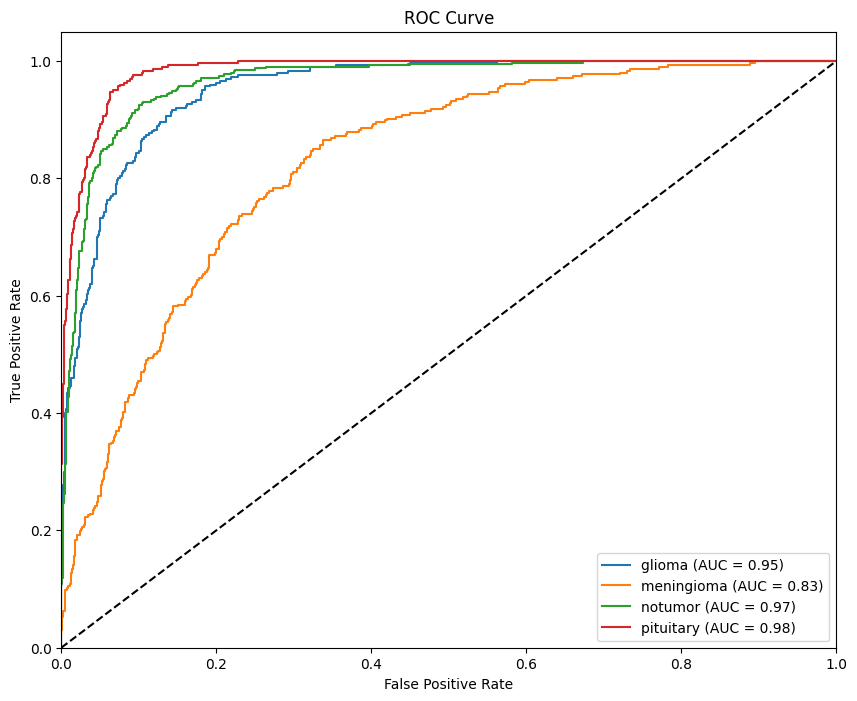

In [ ]:
# Evaluate on test set
print("\n=== Test Set Performance ===")

# Evaluate on test set
y_pred_prob_test, y_pred_test = evaluate_model(model_5, X_test, y_test, classes)

# Plot ROC curve for test set
plot_roc_auc(y_test, y_pred_prob_test, classes)

In [ ]:
# Trial 6:
# This code tried the following hyperparameters:
    # - Number of Convolutional Layers
    # - Number of Filters
    # - Filter Size
    # - Activation Function
    # - Dropout Rate
    # - Batch Normalization
    # - Learning Rate Decay
    # - Optimizer Type

def objective_model_6(trial):
    model = models.Sequential()
    
    # Hyperparameter 1: Number of convolutional layers
    n_conv_layers = trial.suggest_int('n_conv_layers', 2, 5)
    
    input_shape = (30, 30, 1)
    for i in range(n_conv_layers):
        # Hyperparameter 2: Number of filters
        filters = trial.suggest_int(f'filters_{i}', 32, 128, log=True)
        
        # Hyperparameter 3: Filter size (Kernel size)
        kernel_size = trial.suggest_categorical(f'kernel_size_{i}', [3, 5])
        
        # Hyperparameter 4: Activation function
        activation = trial.suggest_categorical('activation', ['relu', 'leaky_relu'])
        
        # Add convolutional layer with padding to preserve dimensions
        if i == 0:
            model.add(layers.Conv2D(filters, kernel_size=kernel_size, activation=activation, padding='same', input_shape=input_shape))
        else:
            model.add(layers.Conv2D(filters, kernel_size=kernel_size, activation=activation, padding='same'))
        
        # Optional: Add Batch Normalization
        if trial.suggest_categorical('batch_normalization', [True, False]):
            model.add(layers.BatchNormalization())
    
    # Use Global Average Pooling instead of Flatten
    model.add(layers.GlobalAveragePooling2D())
    
    # Hyperparameter 5: Dropout rate
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    model.add(layers.Dropout(dropout_rate))
    
    # Output layer with the correct number of classes
    model.add(layers.Dense(4, activation='softmax'))

    # Hyperparameter 6: Learning rate
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    
    # Optimizer type
    optimizer_type = trial.suggest_categorical('optimizer_type', ['adam', 'sgd', 'rmsprop'])
    
    # Compile the model with the selected optimizer
    if optimizer_type == 'adam':
        optimizer = optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_type == 'sgd':
        optimizer = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    else:  # rmsprop
        optimizer = optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Define an early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True)
    
    # Train the model
    history = model.fit(
        X_train, y_train,               # Training data
        validation_data=(X_val, y_val), # Validation data
        epochs=10,                      # Number of epochs
        batch_size=32,                  # Default batch size, can be adjusted if needed
        callbacks=[early_stopping],     # Early stopping to prevent overfitting
        verbose=0                       # Set verbose to 0 to avoid too much output
    )
    
    # Get the validation accuracy
    val_accuracy = history.history['val_accuracy'][-1]
    
    # Return the validation accuracy to maximize it
    return val_accuracy

# Run the Optuna optimization process for model 6
study_model_6 = optuna.create_study(direction='maximize')
study_model_6.optimize(objective_model_6, n_trials=20)

# Print the best parameters found by Optuna
print("Best hyperparameters for model 6: ", study_model_6.best_trial.params)

[I 2024-09-24 09:26:10,489] A new study created in memory with name: no-name-83a5b2d1-2437-4be5-ad3c-c1b349629096


[I 2024-09-24 09:27:32,007] Trial 0 finished with value: 0.6071740984916687 and parameters: {'n_conv_layers': 2, 'filters_0': 32, 'kernel_size_0': 5, 'activation': 'relu', 'batch_normalization': True, 'filters_1': 39, 'kernel_size_1': 5, 'dropout_rate': 0.4509077860191708, 'learning_rate': 3.834045000517994e-05, 'optimizer_type': 'sgd'}. Best is trial 0 with value: 0.6071740984916687.
[I 2024-09-24 09:29:54,046] Trial 1 finished with value: 0.5914260745048523 and parameters: {'n_conv_layers': 5, 'filters_0': 38, 'kernel_size_0': 5, 'activation': 'leaky_relu', 'batch_normalization': False, 'filters_1': 35, 'kernel_size_1': 3, 'filters_2': 51, 'kernel_size_2': 5, 'filters_3': 40, 'kernel_size_3': 3, 'filters_4': 127, 'kernel_size_4': 5, 'dropout_rate': 0.3248009918108976, 'learning_rate': 0.00081492857481672, 'optimizer_type': 'sgd'}. Best is trial 0 with value: 0.6071740984916687.
[I 2024-09-24 09:32:30,558] Trial 2 finished with value: 0.38320210576057434 and parameters: {'n_conv_layer

Best hyperparameters for model 6:  {'n_conv_layers': 4, 'filters_0': 54, 'kernel_size_0': 3, 'activation': 'relu', 'batch_normalization': True, 'filters_1': 45, 'kernel_size_1': 3, 'filters_2': 114, 'kernel_size_2': 5, 'filters_3': 41, 'kernel_size_3': 3, 'dropout_rate': 0.1852168383912703, 'learning_rate': 0.000966592397522579, 'optimizer_type': 'adam'}



=== Test Set Performance ===
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.76      0.75      0.76       300
  meningioma       0.81      0.49      0.61       306
     notumor       0.82      0.95      0.88       405
   pituitary       0.80      0.95      0.87       300

    accuracy                           0.80      1311
   macro avg       0.80      0.79      0.78      1311
weighted avg       0.80      0.80      0.78      1311

Confusion Matrix:
 [[226  28  17  29]
 [ 61 150  63  32]
 [  6   4 383  12]
 [  4   4   6 286]]
Accuracy: 0.7971
Precision: 0.7969
Recall: 0.7971
F1-Score: 0.7850


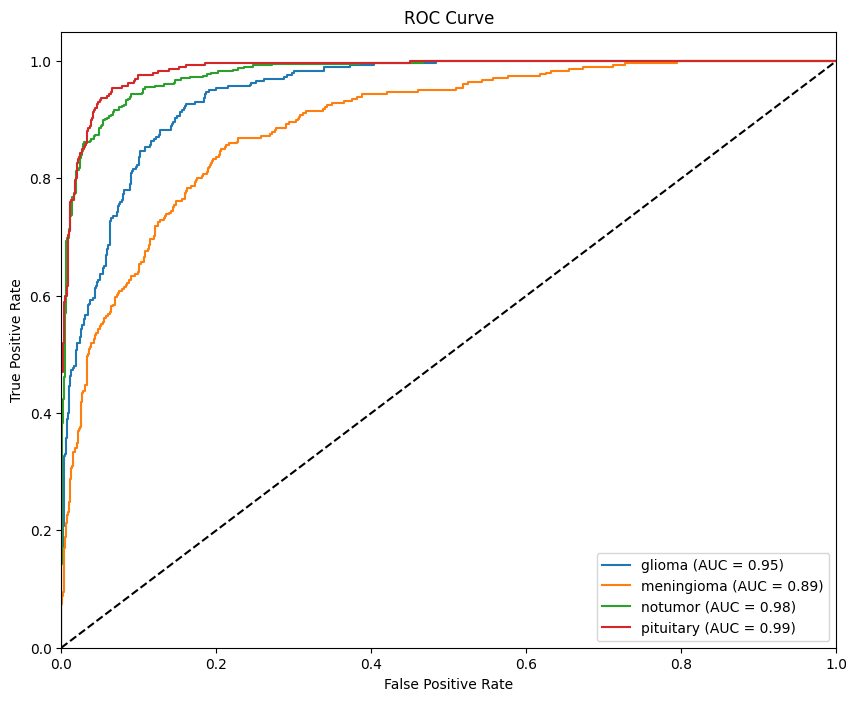

In [ ]:
# Evaluate on test set
print("\n=== Test Set Performance ===")

# Evaluate on test set
y_pred_prob_test, y_pred_test = evaluate_model(model_6, X_test, y_test, classes)

# Plot ROC curve for test set
plot_roc_auc(y_test, y_pred_prob_test, classes)

In [ ]:
# Trial 7:
# This code tried the following hyperparameters:
    # - Dropout rate
    # - Batch normalization
    # - Batch size

def create_model(trial):
    model = keras.Sequential()

    # Hyperparameter 1: Dropout rate
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)

    # Hyperparameter 2: Batch normalization
    use_batch_norm = trial.suggest_categorical('batch_norm', [True, False])

    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2)))

    if use_batch_norm:
        model.add(layers.BatchNormalization())
    
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    if use_batch_norm:
        model.add(layers.BatchNormalization())
    
    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(4, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Hyperparameter 3: Batch size
def objective(trial):
    model = create_model(trial)
    batch_size = trial.suggest_int('batch_size', 16, 128)

    # Define an early stopping callback
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)


    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                        epochs=10, batch_size=batch_size, verbose=0, callbacks=[early_stopping])

    accuracy = history.history['val_accuracy'][-1]
    return accuracy

# Run the Optuna optimization process
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Print the best hyperparameters found
best_trial = study.best_trial
print("Best hyperparameters: ", best_trial.params)
print("Best accuracy: ", best_trial.value)

[I 2024-09-22 20:22:16,401] A new study created in memory with name: no-name-35439dae-69d6-4714-82da-e8d96ccb07f5
[I 2024-09-22 20:22:34,013] Trial 0 finished with value: 0.8031495809555054 and parameters: {'dropout_rate': 0.12177361979526918, 'batch_norm': False, 'batch_size': 64}. Best is trial 0 with value: 0.8031495809555054.
[I 2024-09-22 20:23:13,295] Trial 1 finished with value: 0.7830271124839783 and parameters: {'dropout_rate': 0.4142302575340439, 'batch_norm': False, 'batch_size': 29}. Best is trial 0 with value: 0.8031495809555054.
[I 2024-09-22 20:23:55,073] Trial 2 finished with value: 0.8031495809555054 and parameters: {'dropout_rate': 0.031604945364236026, 'batch_norm': False, 'batch_size': 22}. Best is trial 0 with value: 0.8031495809555054.
[I 2024-09-22 20:24:24,895] Trial 3 finished with value: 0.801399827003479 and parameters: {'dropout_rate': 0.08329776910165437, 'batch_norm': False, 'batch_size': 49}. Best is trial 0 with value: 0.8031495809555054.
[I 2024-09-22 2

Best hyperparameters:  {'dropout_rate': 0.46531761043123643, 'batch_norm': True, 'batch_size': 58}
Best accuracy:  0.8040245175361633


=== Validation Set Performance ===
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.71      0.83      0.77       261
  meningioma       0.64      0.66      0.65       267
     notumor       0.95      0.79      0.86       316
   pituitary       0.88      0.88      0.88       299

    accuracy                           0.79      1143
   macro avg       0.80      0.79      0.79      1143
weighted avg       0.81      0.79      0.80      1143

Confusion Matrix:
 [[217  38   0   6]
 [ 62 177  13  15]
 [ 14  38 250  14]
 [ 11  25   0 263]]
Accuracy: 0.7935
Precision: 0.8054
Recall: 0.7935
F1-Score: 0.7964


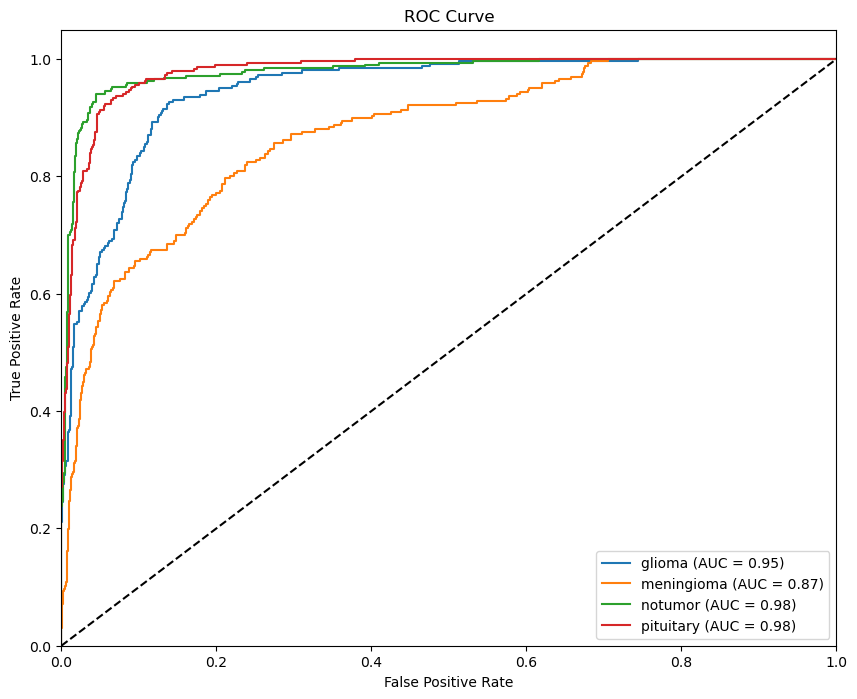


=== Test Set Performance ===
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.71      0.82      0.76       300
  meningioma       0.60      0.62      0.61       306
     notumor       0.88      0.77      0.82       405
   pituitary       0.85      0.84      0.85       300

    accuracy                           0.76      1311
   macro avg       0.76      0.76      0.76      1311
weighted avg       0.77      0.76      0.77      1311

Confusion Matrix:
 [[247  44   0   9]
 [ 57 189  40  20]
 [ 22  55 313  15]
 [ 20  26   2 252]]
Accuracy: 0.7635
Precision: 0.7710
Recall: 0.7635
F1-Score: 0.7653


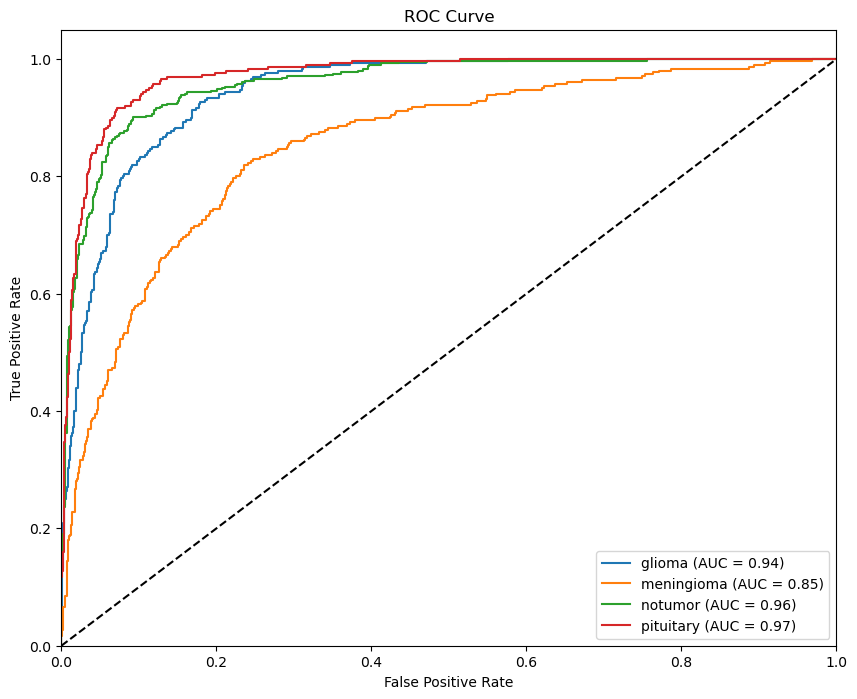

In [ ]:
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
#Model1 is trained based on the above best hyperparameter. In Part2, we will not include codes related to training models.

# Evaluate on Validation Set
print("=== Validation Set Performance ===")
y_pred_prob_val, y_pred_val = evaluate_model(model1, X_val, y_val, classes)

# Plot ROC curve for validation set
plot_roc_auc(y_val, y_pred_prob_val, classes)

# Evaluate on test set
print("\n=== Test Set Performance ===")

X_test, y_test = extract_data_from_generator(test_data)

# Evaluate on test set
y_pred_prob_test, y_pred_test = evaluate_model(model1, X_test, y_test, classes)

# Plot ROC curve for test set
plot_roc_auc(y_test, y_pred_prob_test, classes)

In [ ]:
# Trial 8:
# This code tried the following hyperparameters:
    # - Filter Size
    # - Dropout rate
    # - Batch normalization
    # - Optimizer Type (Adam, SGD, RMSProp)
    # - Batch size

def create_model(trial):
    model = keras.Sequential()

    # Hyperparameter 1: Filter size
    filter_size = trial.suggest_categorical('filter_size', [(3, 3), (5, 5)])

    # Hyperparameter 2: Dropout rate
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)

    # Hyperparameter 3: Batch normalization
    use_batch_norm = trial.suggest_categorical('batch_norm', [True, False])

    # Fixed number of convolutional layers
    num_filters = 32
    model.add(layers.Conv2D(num_filters, filter_size, activation='relu', padding='same', input_shape=(30, 30, 1)))
    model.add(layers.MaxPooling2D((2, 2)))

    if use_batch_norm:
        model.add(layers.BatchNormalization())

    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(4, activation='softmax'))

    # Hyperparameter 4: Optimizer type
    optimizer_type = trial.suggest_categorical('optimizer', ['adam', 'sgd', 'rmsprop'])
    if optimizer_type == 'sgd':
        momentum = trial.suggest_float('momentum', 0.0, 0.9)
        optimizer = keras.optimizers.SGD(momentum=momentum)
    elif optimizer_type == 'rmsprop':
        optimizer = keras.optimizers.RMSprop()
    else:
        optimizer = keras.optimizers.Adam()

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Hyperparameter 5: Batch size
def objective(trial):
    model = create_model(trial)
    batch_size = trial.suggest_int('batch_size', 16, 128)
    # Define an early stopping callback
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                        epochs=10, batch_size=batch_size, verbose=1, callbacks=[early_stopping])

    accuracy = history.history['val_accuracy'][-1]
    return accuracy

# Run the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
# Print the best hyperparameters found
best_trial = study.best_trial
print("Best hyperparameters: ", best_trial.params)
print("Best accuracy: ", best_trial.value)

[I 2024-09-22 20:59:39,244] A new study created in memory with name: no-name-4525e31d-6957-488b-8ec9-dcb9de164f10


Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5490 - loss: 1.0470 - val_accuracy: 0.5573 - val_loss: 1.2589
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7737 - loss: 0.5889 - val_accuracy: 0.7717 - val_loss: 1.1335
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8292 - loss: 0.4496 - val_accuracy: 0.7839 - val_loss: 1.0177
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8638 - loss: 0.3613 - val_accuracy: 0.7892 - val_loss: 0.8962
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8885 - loss: 0.3010 - val_accuracy: 0.7935 - val_loss: 0.7847
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9130 - loss: 0.2453 - val_accuracy: 0.7944 - val_loss: 0.6777
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9292 - loss: 0.2043 - val_accuracy: 0.8049 - val_loss: 0.5933
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9467 - loss: 0.1669 - val_accuracy: 0.8093 - v

[I 2024-09-22 20:59:50,710] Trial 0 finished with value: 0.8031495809555054 and parameters: {'filter_size': (3, 3), 'dropout_rate': 0.15871252848734857, 'batch_norm': True, 'optimizer': 'sgd', 'momentum': 0.7280152869734229, 'batch_size': 87}. Best is trial 0 with value: 0.8031495809555054.


Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.3436 - loss: 1.2898 - val_accuracy: 0.5967 - val_loss: 1.0075
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5987 - loss: 0.9707 - val_accuracy: 0.7340 - val_loss: 0.8145
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6785 - loss: 0.8263 - val_accuracy: 0.7542 - val_loss: 0.7218
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7191 - loss: 0.7428 - val_accuracy: 0.7769 - val_loss: 0.6563
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7423 - loss: 0.6795 - val_accuracy: 0.7717 - val_loss: 0.6179
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7585 - loss: 0.6499 - val_accuracy: 0.7655 - val_loss: 0.6072
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7795 - loss: 0.5962 - val_accuracy: 0.7909 - val_loss: 0.5573
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7891 - loss: 0.5645 - val_accuracy: 0.7935 - v

[I 2024-09-22 20:59:59,467] Trial 1 finished with value: 0.794400691986084 and parameters: {'filter_size': (3, 3), 'dropout_rate': 0.2628046694455553, 'batch_norm': False, 'optimizer': 'adam', 'batch_size': 101}. Best is trial 0 with value: 0.8031495809555054.


Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.4006 - loss: 1.2420 - val_accuracy: 0.5993 - val_loss: 0.9485
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.6453 - loss: 0.8993 - val_accuracy: 0.6964 - val_loss: 0.7511
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.7315 - loss: 0.7301 - val_accuracy: 0.7463 - val_loss: 0.6602
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7473 - loss: 0.6534 - val_accuracy: 0.7690 - val_loss: 0.6154
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7783 - loss: 0.5953 - val_accuracy: 0.7743 - val_loss: 0.5862
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7967 - loss: 0.5511 - val_accuracy: 0.7804 - val_loss: 0.5664
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8088 - loss: 0.5098 - val_accuracy: 0.7900 - val_loss: 0.5513
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8271 - loss: 0.4758 - val_accuracy: 0.7962 - v

[I 2024-09-22 21:00:21,556] Trial 2 finished with value: 0.7996500730514526 and parameters: {'filter_size': (5, 5), 'dropout_rate': 0.11309881562349011, 'batch_norm': False, 'optimizer': 'adam', 'batch_size': 69}. Best is trial 0 with value: 0.8031495809555054.


Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.5408 - loss: 1.4778 - val_accuracy: 0.6868 - val_loss: 1.1783
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7515 - loss: 0.6572 - val_accuracy: 0.6938 - val_loss: 0.9988
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8290 - loss: 0.4539 - val_accuracy: 0.7157 - val_loss: 0.8138
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8722 - loss: 0.3409 - val_accuracy: 0.6597 - val_loss: 0.8863
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8996 - loss: 0.2729 - val_accuracy: 0.7192 - val_loss: 0.7437
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9118 - loss: 0.2264 - val_accuracy: 0.7734 - val_loss: 0.6470
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9332 - loss: 0.1657 - val_accuracy: 0.7997 - val_loss: 0.6692
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9382 - loss: 0.1528 - val_accuracy: 0.8049 - v

[I 2024-09-22 21:00:55,130] Trial 3 finished with value: 0.8110235929489136 and parameters: {'filter_size': (5, 5), 'dropout_rate': 0.1257713163697513, 'batch_norm': True, 'optimizer': 'rmsprop', 'batch_size': 48}. Best is trial 3 with value: 0.8110235929489136.


Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.5111 - loss: 1.2284 - val_accuracy: 0.3377 - val_loss: 1.2838
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.7065 - loss: 0.7275 - val_accuracy: 0.4637 - val_loss: 1.2449
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.7647 - loss: 0.5703 - val_accuracy: 0.7305 - val_loss: 1.1199
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8015 - loss: 0.4908 - val_accuracy: 0.7743 - val_loss: 1.0431
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8373 - loss: 0.4144 - val_accuracy: 0.7445 - val_loss: 0.9587
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8345 - loss: 0.3946 - val_accuracy: 0.7288 - val_loss: 0.8315
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8648 - loss: 0.3448 - val_accuracy: 0.7979 - val_loss: 0.7139
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8708 - loss: 0.3116 - val_accuracy: 0.7839 - v

[I 2024-09-22 21:01:17,229] Trial 4 finished with value: 0.7979002594947815 and parameters: {'filter_size': (5, 5), 'dropout_rate': 0.36644772655684144, 'batch_norm': True, 'optimizer': 'adam', 'batch_size': 100}. Best is trial 3 with value: 0.8110235929489136.


Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.5084 - loss: 1.1727 - val_accuracy: 0.5774 - val_loss: 1.1836
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6809 - loss: 0.7601 - val_accuracy: 0.7087 - val_loss: 1.0093
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.7450 - loss: 0.6365 - val_accuracy: 0.7393 - val_loss: 0.8645
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7675 - loss: 0.5563 - val_accuracy: 0.7892 - val_loss: 0.6406
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7957 - loss: 0.4803 - val_accuracy: 0.7638 - val_loss: 0.5797
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.8230 - loss: 0.4222 - val_accuracy: 0.8014 - val_loss: 0.5079
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.8421 - loss: 0.3920 - val_accuracy: 0.8005 - val_loss: 0.5083
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8597 - loss: 0.3304 - val_accuracy: 0.8031 - v

[I 2024-09-22 21:01:46,134] Trial 5 finished with value: 0.8145231604576111 and parameters: {'filter_size': (5, 5), 'dropout_rate': 0.4556926145066366, 'batch_norm': True, 'optimizer': 'sgd', 'momentum': 0.8619569369108249, 'batch_size': 56}. Best is trial 5 with value: 0.8145231604576111.


Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5673 - loss: 1.0254 - val_accuracy: 0.6763 - val_loss: 1.1274
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7569 - loss: 0.6036 - val_accuracy: 0.7612 - val_loss: 0.9091
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8152 - loss: 0.4566 - val_accuracy: 0.7375 - val_loss: 0.7475
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8518 - loss: 0.3716 - val_accuracy: 0.7795 - val_loss: 0.5971
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8808 - loss: 0.2939 - val_accuracy: 0.7743 - val_loss: 0.6224
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8934 - loss: 0.2698 - val_accuracy: 0.7935 - val_loss: 0.6228
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9040 - loss: 0.2285 - val_accuracy: 0.7542 - val_loss: 0.7546
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9173 - loss: 0.2031 - val_accu

[I 2024-09-22 21:02:03,371] Trial 6 finished with value: 0.7891513705253601 and parameters: {'filter_size': (3, 3), 'dropout_rate': 0.21130588644864634, 'batch_norm': True, 'optimizer': 'adam', 'batch_size': 39}. Best is trial 5 with value: 0.8145231604576111.


Epoch 1/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.5973 - loss: 1.0154 - val_accuracy: 0.7253 - val_loss: 0.9918
Epoch 2/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7854 - loss: 0.5360 - val_accuracy: 0.7472 - val_loss: 0.6808
Epoch 3/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8526 - loss: 0.3868 - val_accuracy: 0.7507 - val_loss: 0.6812
Epoch 4/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8757 - loss: 0.3061 - val_accuracy: 0.7822 - val_loss: 0.6986
Epoch 5/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9027 - loss: 0.2484 - val_accuracy: 0.7778 - val_loss: 0.7394
Epoch 6/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9255 - loss: 0.2028 - val_accuracy: 0.7822 - val_loss: 0.6604
Epoch 7/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9271 - loss: 0.1768 - val_accuracy: 0.7708 - val_loss: 0.8108


[I 2024-09-22 21:02:22,953] Trial 7 finished with value: 0.7707786560058594 and parameters: {'filter_size': (3, 3), 'dropout_rate': 0.14275261439462333, 'batch_norm': True, 'optimizer': 'adam', 'batch_size': 21}. Best is trial 5 with value: 0.8145231604576111.


Epoch 1/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.3922 - loss: 1.2537 - val_accuracy: 0.6439 - val_loss: 0.9357
Epoch 2/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6634 - loss: 0.8909 - val_accuracy: 0.6780 - val_loss: 0.8142
Epoch 3/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7073 - loss: 0.7705 - val_accuracy: 0.6929 - val_loss: 0.7606
Epoch 4/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7352 - loss: 0.6958 - val_accuracy: 0.7148 - val_loss: 0.7017
Epoch 5/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7557 - loss: 0.6523 - val_accuracy: 0.7340 - val_loss: 0.6542
Epoch 6/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7772 - loss: 0.6084 - val_accuracy: 0.7533 - val_loss: 0.6277
Epoch 7/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7903 - loss: 0.5683 - val_accuracy: 0.7638 - val_loss: 0.6034
Epoch 8/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7953 - loss: 0.5372 - val_accuracy: 0.

[I 2024-09-22 21:02:48,550] Trial 8 finished with value: 0.794400691986084 and parameters: {'filter_size': (3, 3), 'dropout_rate': 0.1716906592075968, 'batch_norm': False, 'optimizer': 'sgd', 'momentum': 0.3700466714440317, 'batch_size': 16}. Best is trial 5 with value: 0.8145231604576111.


Epoch 1/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.3323 - loss: 1.3157 - val_accuracy: 0.5818 - val_loss: 1.0144
Epoch 2/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6534 - loss: 0.9211 - val_accuracy: 0.6535 - val_loss: 0.8458
Epoch 3/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7093 - loss: 0.7728 - val_accuracy: 0.6737 - val_loss: 0.7927
Epoch 4/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7353 - loss: 0.7037 - val_accuracy: 0.6912 - val_loss: 0.7406
Epoch 5/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7508 - loss: 0.6446 - val_accuracy: 0.7165 - val_loss: 0.6942
Epoch 6/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7717 - loss: 0.6003 - val_accuracy: 0.7428 - val_loss: 0.6451
Epoch 7/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7884 - loss: 0.5571 - val_accuracy: 0.7550 - val_loss: 0.6195
Epoch 8/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8069 - loss: 0.5223 - val_accuracy: 0.

[I 2024-09-22 21:03:13,936] Trial 9 finished with value: 0.7917760014533997 and parameters: {'filter_size': (3, 3), 'dropout_rate': 0.05340792398165817, 'batch_norm': False, 'optimizer': 'sgd', 'momentum': 0.32765921811598, 'batch_size': 16}. Best is trial 5 with value: 0.8145231604576111.


Best hyperparameters:  {'filter_size': (5, 5), 'dropout_rate': 0.4556926145066366, 'batch_norm': True, 'optimizer': 'sgd', 'momentum': 0.8619569369108249, 'batch_size': 56}
Best accuracy:  0.8145231604576111


=== Validation Set Performance ===
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.21      0.78      0.33       261
  meningioma       0.00      0.00      0.00       267
     notumor       0.00      0.00      0.00       316
   pituitary       0.21      0.12      0.16       299

    accuracy                           0.21      1143
   macro avg       0.11      0.23      0.12      1143
weighted avg       0.10      0.21      0.12      1143

Confusion Matrix:
 [[203   0   0  58]
 [214   0   0  53]
 [290   0   0  26]
 [262   0   0  37]]
Accuracy: 0.2100
Precision: 0.1035
Recall: 0.2100
F1-Score: 0.1163


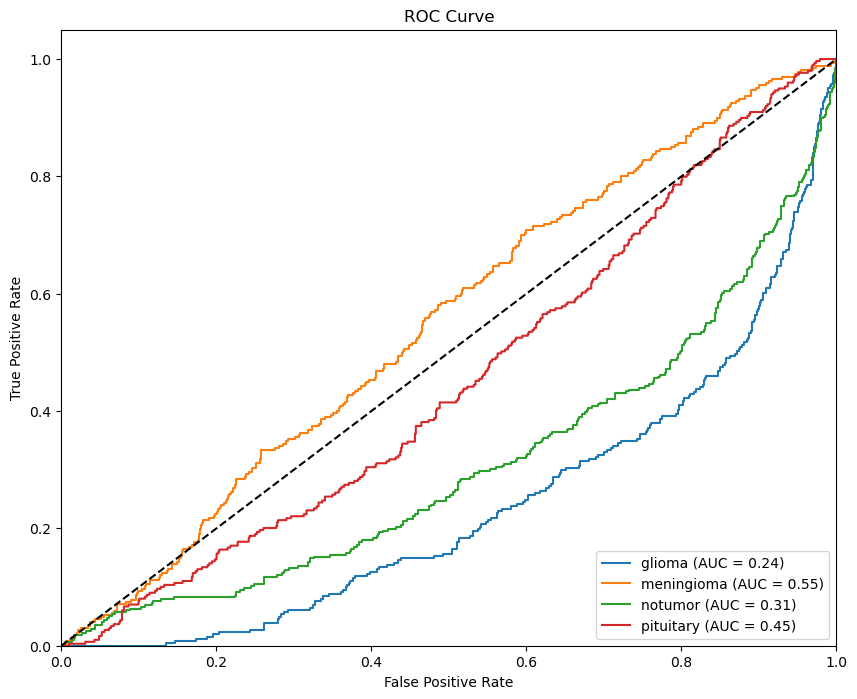


=== Test Set Performance ===
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.21      0.79      0.33       300
  meningioma       0.00      0.00      0.00       306
     notumor       0.00      0.00      0.00       405
   pituitary       0.20      0.11      0.14       300

    accuracy                           0.21      1311
   macro avg       0.10      0.23      0.12      1311
weighted avg       0.09      0.21      0.11      1311

Confusion Matrix:
 [[238   0   0  62]
 [269   0   0  37]
 [371   0   0  34]
 [267   0   0  33]]
Accuracy: 0.2067
Precision: 0.0931
Recall: 0.2067
F1-Score: 0.1078


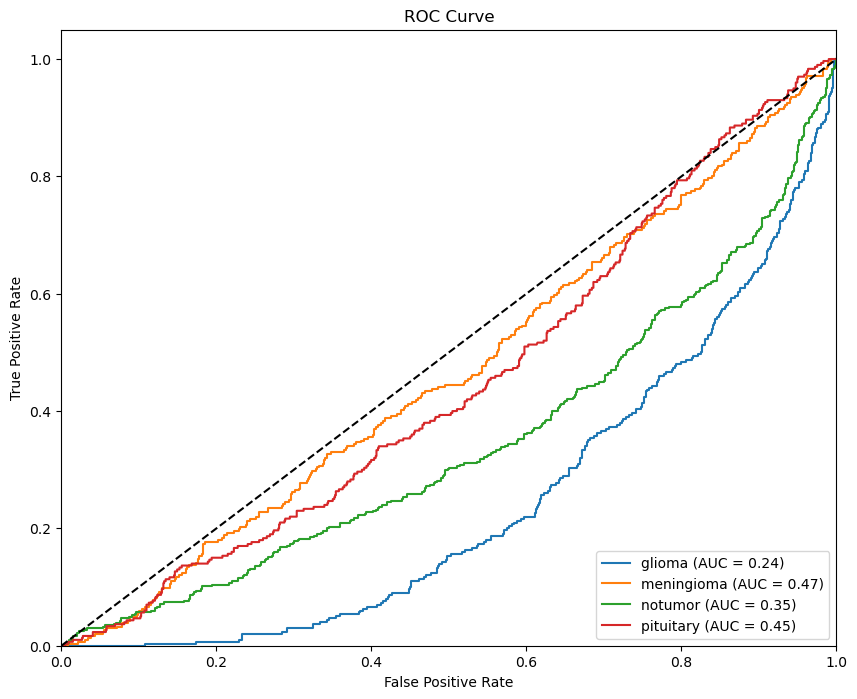

In [ ]:
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
#Model2 is trained based on the above best hyperparameter. In Part2, we will not include codes related to training models.

# Evaluate on Validation Set
print("=== Validation Set Performance ===")
y_pred_prob_val, y_pred_val = evaluate_model(model2, X_val, y_val, classes)

# Plot ROC curve for validation set
plot_roc_auc(y_val, y_pred_prob_val, classes)

# Evaluate on test set
print("\n=== Test Set Performance ===")

X_test, y_test = extract_data_from_generator(test_data)

# Evaluate on test set
y_pred_prob_test, y_pred_test = evaluate_model(model2, X_test, y_test, classes)

# Plot ROC curve for test set
plot_roc_auc(y_test, y_pred_prob_test, classes)

In [ ]:
# Trial 9:
# This code tried the following hyperparameters:
    # - Number of filter
    # - Optimizer
    # - Batch size

def create_model(trial):
    model = keras.Sequential()
    # Hyperparameter 1: Number of filter
    num_filters = trial.suggest_int('num_filters', 16, 64)

    # Fixed number of convolutional layers
    model.add(layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same', input_shape=(30, 30, 1)))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(num_filters, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(4, activation='softmax'))

    # Hyperparameter 2: Optimizer type
    optimizer_type = trial.suggest_categorical('optimizer', ['adam', 'sgd', 'rmsprop'])
    if optimizer_type == 'sgd':
        momentum = trial.suggest_float('momentum', 0.0, 0.9)
        optimizer = keras.optimizers.SGD(momentum=momentum)
    elif optimizer_type == 'rmsprop':
        optimizer = keras.optimizers.RMSprop()
    else:
        optimizer = keras.optimizers.Adam()

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Hyperparameter 3: Batch size
def objective(trial):
    model = create_model(trial)
    batch_size = trial.suggest_int('batch_size', 16, 64)

    # Define an early stopping callback
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

    #Train the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                        epochs=10, batch_size=batch_size, verbose=1, callbacks=[early_stopping])

    accuracy = history.history['val_accuracy'][-1]
    return accuracy

# Run the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Print the best hyperparameters found
best_trial = study.best_trial
print("Best hyperparameters: ", best_trial.params)
print("Best accuracy: ", best_trial.value)

[I 2024-09-23 21:06:42,174] A new study created in memory with name: no-name-f744ec0a-d93a-4bb7-9240-c4251826b172


Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.3336 - loss: 1.3256 - val_accuracy: 0.5836 - val_loss: 1.0528
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6404 - loss: 0.9229 - val_accuracy: 0.5713 - val_loss: 1.0457
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6688 - loss: 0.8334 - val_accuracy: 0.6010 - val_loss: 0.9267
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6996 - loss: 0.7732 - val_accuracy: 0.6290 - val_loss: 0.8817
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7241 - loss: 0.7164 - val_accuracy: 0.6588 - val_loss: 0.8306
Epoch 6/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7463 - loss: 0.6617 - val_accuracy: 0.6789 - val_loss: 0.7918
Epoch 7/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7584 - loss: 0.6172 - val_accuracy: 0.6990 - val_loss: 0.7662
Epoch 8/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7780 - loss: 0.5790 - val_accu

[I 2024-09-23 21:07:03,298] Trial 0 finished with value: 0.7209098935127258 and parameters: {'num_filters': 60, 'optimizer': 'sgd', 'momentum': 0.7790505197544115, 'batch_size': 41}. Best is trial 0 with value: 0.7209098935127258.


Epoch 1/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.3142 - loss: 1.3210 - val_accuracy: 0.6404 - val_loss: 1.1319
Epoch 2/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6237 - loss: 1.0346 - val_accuracy: 0.6500 - val_loss: 0.9407
Epoch 3/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6665 - loss: 0.8855 - val_accuracy: 0.6500 - val_loss: 0.9097
Epoch 4/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6903 - loss: 0.8374 - val_accuracy: 0.6544 - val_loss: 0.8932
Epoch 5/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6968 - loss: 0.7977 - val_accuracy: 0.6535 - val_loss: 0.8779
Epoch 6/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7138 - loss: 0.7594 - val_accuracy: 0.6632 - val_loss: 0.8429
Epoch 7/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7325 - loss: 0.7191 - val_accuracy: 0.6868 - val_loss: 0.8026
Epoch 8/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7467 - loss: 0.6809 - val_accu

[I 2024-09-23 21:07:24,946] Trial 1 finished with value: 0.7279090285301208 and parameters: {'num_filters': 35, 'optimizer': 'sgd', 'momentum': 0.6214146648262002, 'batch_size': 31}. Best is trial 1 with value: 0.7279090285301208.


Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.2808 - loss: 1.3618 - val_accuracy: 0.6010 - val_loss: 1.2053
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5905 - loss: 1.0770 - val_accuracy: 0.6325 - val_loss: 0.9342
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6681 - loss: 0.8687 - val_accuracy: 0.6544 - val_loss: 0.8835
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6928 - loss: 0.8140 - val_accuracy: 0.6675 - val_loss: 0.8577
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7060 - loss: 0.7755 - val_accuracy: 0.6824 - val_loss: 0.8254
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7193 - loss: 0.7379 - val_accuracy: 0.6929 - val_loss: 0.7997
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7343 - loss: 0.6997 - val_accuracy: 0.7043 - val_loss: 0.7689
Epoch 8/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7491 - loss: 0.6605 - val_accu

[I 2024-09-23 21:07:46,509] Trial 2 finished with value: 0.748031497001648 and parameters: {'num_filters': 29, 'optimizer': 'sgd', 'momentum': 0.5558130288407952, 'batch_size': 28}. Best is trial 2 with value: 0.748031497001648.


Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.4067 - loss: 1.2257 - val_accuracy: 0.5468 - val_loss: 1.1051
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6707 - loss: 0.8843 - val_accuracy: 0.5871 - val_loss: 1.0253
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7032 - loss: 0.7732 - val_accuracy: 0.6334 - val_loss: 0.8996
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7354 - loss: 0.6982 - val_accuracy: 0.6360 - val_loss: 0.9064
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7532 - loss: 0.6471 - val_accuracy: 0.6772 - val_loss: 0.8175
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7687 - loss: 0.6005 - val_accuracy: 0.7095 - val_loss: 0.7515
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7835 - loss: 0.5646 - val_accuracy: 0.7270 - val_loss: 0.7131
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7971 - loss: 0.5334 - val_accuracy: 0.7454 - v

[I 2024-09-23 21:08:07,455] Trial 3 finished with value: 0.7672790884971619 and parameters: {'num_filters': 30, 'optimizer': 'rmsprop', 'batch_size': 47}. Best is trial 3 with value: 0.7672790884971619.


Epoch 1/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.4432 - loss: 1.1694 - val_accuracy: 0.5967 - val_loss: 0.9634
Epoch 2/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7043 - loss: 0.7768 - val_accuracy: 0.6282 - val_loss: 0.9120
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.7438 - loss: 0.6689 - val_accuracy: 0.6859 - val_loss: 0.8045
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7732 - loss: 0.5899 - val_accuracy: 0.7209 - val_loss: 0.7297
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7979 - loss: 0.5306 - val_accuracy: 0.7393 - val_loss: 0.6674
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8145 - loss: 0.4898 - val_accuracy: 0.7603 - val_loss: 0.6351
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8283 - loss: 0.4554 - val_accuracy: 0.7787 - val_loss: 0.6168
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8433 - loss: 0.4333 - val_accu

[I 2024-09-23 21:08:42,674] Trial 4 finished with value: 0.8171478509902954 and parameters: {'num_filters': 51, 'optimizer': 'adam', 'batch_size': 30}. Best is trial 4 with value: 0.8171478509902954.


Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.4408 - loss: 1.1782 - val_accuracy: 0.6133 - val_loss: 0.9548
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6955 - loss: 0.7903 - val_accuracy: 0.6527 - val_loss: 0.8491
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7567 - loss: 0.6425 - val_accuracy: 0.6982 - val_loss: 0.7558
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7919 - loss: 0.5462 - val_accuracy: 0.7463 - val_loss: 0.6523
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8165 - loss: 0.4827 - val_accuracy: 0.7655 - val_loss: 0.6278
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8414 - loss: 0.4282 - val_accuracy: 0.7795 - val_loss: 0.6106
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8606 - loss: 0.3828 - val_accuracy: 0.7865 - val_loss: 0.5982
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8807 - loss: 0.3364 - val_accu

[I 2024-09-23 21:09:12,462] Trial 5 finished with value: 0.7795275449752808 and parameters: {'num_filters': 59, 'optimizer': 'rmsprop', 'batch_size': 25}. Best is trial 4 with value: 0.8171478509902954.


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.4648 - loss: 1.1576 - val_accuracy: 0.6518 - val_loss: 0.8885
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7008 - loss: 0.7730 - val_accuracy: 0.6982 - val_loss: 0.7623
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7503 - loss: 0.6486 - val_accuracy: 0.7428 - val_loss: 0.6805
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7902 - loss: 0.5576 - val_accuracy: 0.7717 - val_loss: 0.6343
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8078 - loss: 0.4909 - val_accuracy: 0.7690 - val_loss: 0.6481
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8359 - loss: 0.4390 - val_accuracy: 0.7822 - val_loss: 0.6329
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8529 - loss: 0.3910 - val_accuracy: 0.7909 - val_loss: 0.6380
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8739 - loss: 0.3462 - val_accu

[I 2024-09-23 21:09:40,242] Trial 6 finished with value: 0.8066491484642029 and parameters: {'num_filters': 57, 'optimizer': 'rmsprop', 'batch_size': 24}. Best is trial 4 with value: 0.8171478509902954.


Epoch 1/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.3430 - loss: 1.3119 - val_accuracy: 0.6535 - val_loss: 0.9332
Epoch 2/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6623 - loss: 0.8933 - val_accuracy: 0.6815 - val_loss: 0.8417
Epoch 3/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7112 - loss: 0.7832 - val_accuracy: 0.6947 - val_loss: 0.7990
Epoch 4/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7415 - loss: 0.6959 - val_accuracy: 0.7130 - val_loss: 0.7419
Epoch 5/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7660 - loss: 0.6278 - val_accuracy: 0.7463 - val_loss: 0.6843
Epoch 6/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7868 - loss: 0.5771 - val_accuracy: 0.7655 - val_loss: 0.6412
Epoch 7/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.7997 - loss: 0.5371 - val_accuracy: 0.7778 - val_loss: 0.6051
Epoch 8/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.8152 - loss: 0.5008 - val_accu

[I 2024-09-23 21:10:19,915] Trial 7 finished with value: 0.7926509380340576 and parameters: {'num_filters': 55, 'optimizer': 'sgd', 'momentum': 0.7465552417840914, 'batch_size': 22}. Best is trial 4 with value: 0.8171478509902954.


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.2870 - loss: 1.3484 - val_accuracy: 0.6089 - val_loss: 1.2166
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.6015 - loss: 1.0924 - val_accuracy: 0.5704 - val_loss: 1.0432
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.6596 - loss: 0.8890 - val_accuracy: 0.5739 - val_loss: 1.0393
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.6846 - loss: 0.8403 - val_accuracy: 0.5871 - val_loss: 1.0018


[I 2024-09-23 21:10:48,889] Trial 8 finished with value: 0.5870516300201416 and parameters: {'num_filters': 61, 'optimizer': 'sgd', 'momentum': 0.6568227152926053, 'batch_size': 46}. Best is trial 4 with value: 0.8171478509902954.


Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.2939 - loss: 1.3550 - val_accuracy: 0.5031 - val_loss: 1.2617
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5314 - loss: 1.1616 - val_accuracy: 0.6054 - val_loss: 0.9961
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6545 - loss: 0.9258 - val_accuracy: 0.6422 - val_loss: 0.9301
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6824 - loss: 0.8570 - val_accuracy: 0.6605 - val_loss: 0.8912
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7005 - loss: 0.8150 - val_accuracy: 0.6719 - val_loss: 0.8503
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7126 - loss: 0.7775 - val_accuracy: 0.6859 - val_loss: 0.8189
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7201 - loss: 0.7414 - val_accuracy: 0.6903 - val_loss: 0.7934
Epoch 8/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7315 - loss: 0.7063 - val_accu

[I 2024-09-23 21:11:27,620] Trial 9 finished with value: 0.7165354490280151 and parameters: {'num_filters': 36, 'optimizer': 'sgd', 'momentum': 0.4046690056150623, 'batch_size': 28}. Best is trial 4 with value: 0.8171478509902954.


Best hyperparameters:  {'num_filters': 51, 'optimizer': 'adam', 'batch_size': 30}
Best accuracy:  0.8171478509902954


=== Validation Set Performance ===
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.68      0.87      0.77       261
  meningioma       0.74      0.54      0.63       267
     notumor       0.95      0.84      0.89       316
   pituitary       0.82      0.92      0.87       299

    accuracy                           0.80      1143
   macro avg       0.80      0.79      0.79      1143
weighted avg       0.81      0.80      0.80      1143

Confusion Matrix:
 [[228  24   1   8]
 [ 82 145  11  29]
 [ 12  16 265  23]
 [ 11  10   2 276]]
Accuracy: 0.7997
Precision: 0.8075
Recall: 0.7997
F1-Score: 0.7956


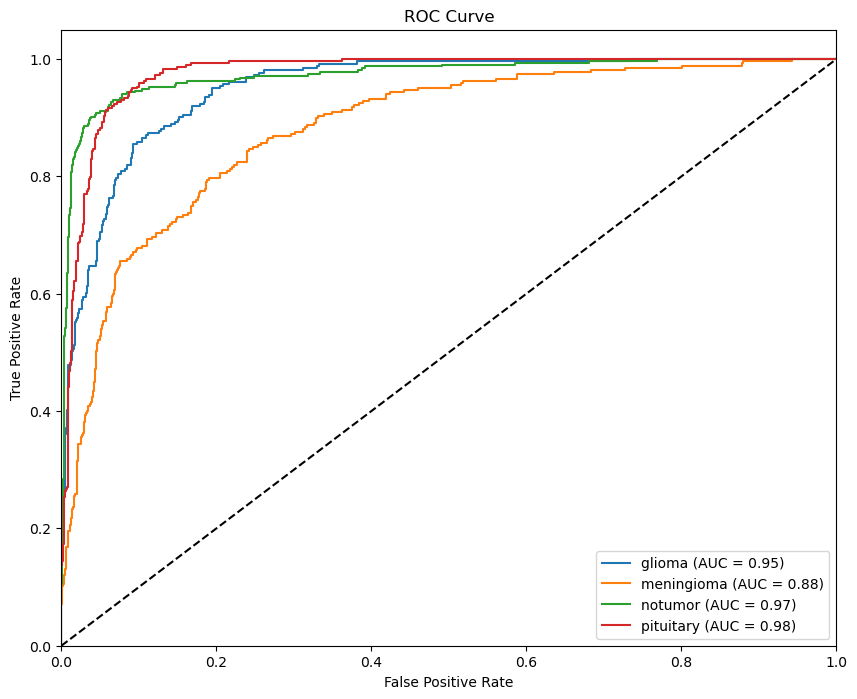


=== Test Set Performance ===
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.68      0.81      0.74       300
  meningioma       0.63      0.43      0.51       306
     notumor       0.87      0.82      0.84       405
   pituitary       0.76      0.92      0.83       300

    accuracy                           0.75      1311
   macro avg       0.74      0.75      0.73      1311
weighted avg       0.75      0.75      0.74      1311

Confusion Matrix:
 [[243  39   1  17]
 [ 82 132  47  45]
 [ 17  31 332  25]
 [ 13   9   1 277]]
Accuracy: 0.7506
Precision: 0.7460
Recall: 0.7506
F1-Score: 0.7409


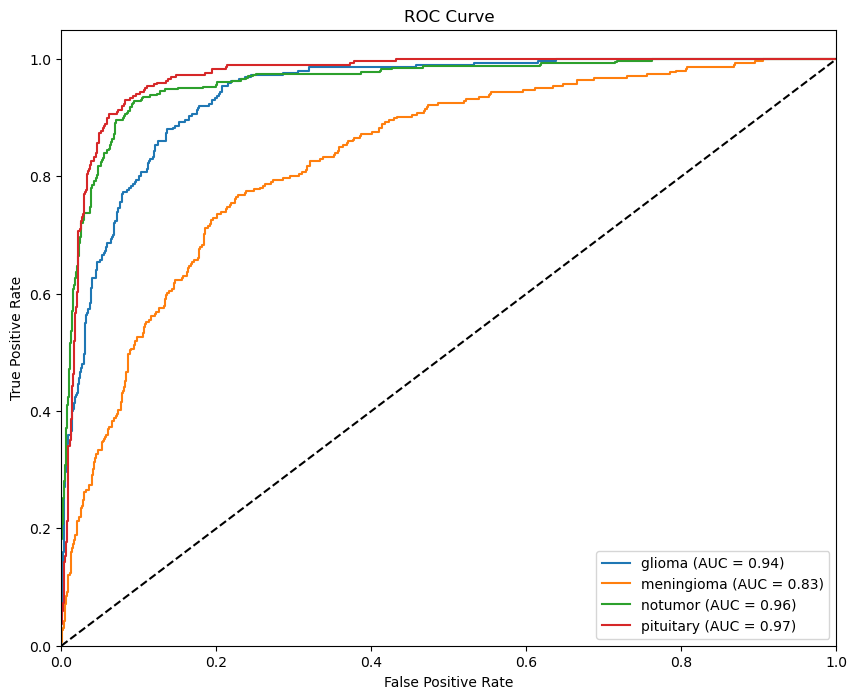

In [ ]:
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
#Model4 is trained based on the above best hyperparameter. In Part2, we will not include codes related to training models.

# Evaluate on Validation Set
print("=== Validation Set Performance ===")
y_pred_prob_val, y_pred_val = evaluate_model(model4, X_val, y_val, classes)

# Plot ROC curve for validation set
plot_roc_auc(y_val, y_pred_prob_val, classes)

# Evaluate on Test Set
print("\n=== Test Set Performance ===")

X_test, y_test = extract_data_from_generator(test_data)

# Evaluate on test set
y_pred_prob_test, y_pred_test = evaluate_model(model4, X_test, y_test, classes)

# Plot ROC curve for test set
plot_roc_auc(y_test, y_pred_prob_test, classes)

In [ ]:
# Trial 10:
# This code tried the following hyperparameters:
    # - Optimizer Type (Adam, SGD, RMSProp)
    # - Number of epoch
    # - Batch size

def create_model(trial):
    model = keras.Sequential()

    # Fixed number of convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(30, 30, 1)))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(4, activation='softmax'))

    # Hyperparameter 1: Optimizer Type
    optimizer_type = trial.suggest_categorical('optimizer', ['adam', 'sgd', 'rmsprop'])
    if optimizer_type == 'sgd':
        momentum = trial.suggest_float('momentum', 0.0, 0.9)
        optimizer = keras.optimizers.SGD(momentum=momentum)
    elif optimizer_type == 'rmsprop':
        optimizer = keras.optimizers.RMSprop()
    else:
        optimizer = keras.optimizers.Adam()

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Hyperparameter 2: Number of epoch
def objective(trial):
    model = create_model(trial)
    
    # Hyperparameter 2: Number of epoch
    epochs = trial.suggest_int('epochs', 5, 20)
    # Hyperparameter 3: Batch size
    batch_size = trial.suggest_int('batch_size', 16, 64)

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

    
    #Train the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                        epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stopping])

    accuracy = history.history['val_accuracy'][-1]
    return accuracy
#Run the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Print the best hyperparameters found
best_trial = study.best_trial
print("Best hyperparameters: ", best_trial.params)
print("Best accuracy: ", best_trial.value)

[I 2024-09-23 21:26:23,463] A new study created in memory with name: no-name-4545cab8-acf8-4434-9187-3a7ecbf9a67a


Epoch 1/11
286/286 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.3208 - loss: 1.3321 - val_accuracy: 0.6019 - val_loss: 1.0944
Epoch 2/11
286/286 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6346 - loss: 0.9821 - val_accuracy: 0.6282 - val_loss: 0.9266
Epoch 3/11
286/286 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6776 - loss: 0.8485 - val_accuracy: 0.6535 - val_loss: 0.8686
Epoch 4/11
286/286 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7051 - loss: 0.7909 - val_accuracy: 0.6640 - val_loss: 0.8428
Epoch 5/11
286/286 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7225 - loss: 0.7398 - val_accuracy: 0.6973 - val_loss: 0.7802
Epoch 6/11
286/286 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7334 - loss: 0.6919 - val_accuracy: 0.7157 - val_loss: 0.7400
Epoch 7/11
286/286 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7544 - loss: 0.6470 - val_accuracy: 0.7297 - val_loss: 0.7075
Epoch 8/11
286/286 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7701 - loss: 0.6084 - val_accu

[I 2024-09-23 21:27:05,203] Trial 0 finished with value: 0.7646543979644775 and parameters: {'optimizer': 'sgd', 'momentum': 0.37557994740848616, 'epochs': 11, 'batch_size': 16}. Best is trial 0 with value: 0.7646543979644775.


Epoch 1/18
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.3890 - loss: 1.2660 - val_accuracy: 0.6037 - val_loss: 0.9822
Epoch 2/18
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6629 - loss: 0.8819 - val_accuracy: 0.6500 - val_loss: 0.8617
Epoch 3/18
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7025 - loss: 0.7831 - val_accuracy: 0.7069 - val_loss: 0.7406
Epoch 4/18
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7371 - loss: 0.6987 - val_accuracy: 0.7297 - val_loss: 0.6748
Epoch 5/18
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7630 - loss: 0.6456 - val_accuracy: 0.7612 - val_loss: 0.6326
Epoch 6/18
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7769 - loss: 0.5986 - val_accuracy: 0.7682 - val_loss: 0.6114
Epoch 7/18
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7893 - loss: 0.5594 - val_accuracy: 0.7760 - val_loss: 0.5928
Epoch 8/18
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7988 - loss: 0.5273 - val_accuracy: 0.7830 - v

[I 2024-09-23 21:27:39,849] Trial 1 finished with value: 0.8118985295295715 and parameters: {'optimizer': 'adam', 'epochs': 18, 'batch_size': 63}. Best is trial 1 with value: 0.8118985295295715.


Epoch 1/18
164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.4561 - loss: 1.1711 - val_accuracy: 0.5792 - val_loss: 1.0127
Epoch 2/18
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7022 - loss: 0.7965 - val_accuracy: 0.6045 - val_loss: 0.9706
Epoch 3/18
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7388 - loss: 0.6919 - val_accuracy: 0.6465 - val_loss: 0.8829
Epoch 4/18
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7559 - loss: 0.6290 - val_accuracy: 0.6885 - val_loss: 0.7713
Epoch 5/18
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7802 - loss: 0.5710 - val_accuracy: 0.7323 - val_loss: 0.7017
Epoch 6/18
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8009 - loss: 0.5288 - val_accuracy: 0.7577 - val_loss: 0.6623
Epoch 7/18
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8215 - loss: 0.4897 - val_accuracy: 0.7717 - val_loss: 0.6396
Epoch 8/18
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8350 - loss: 0.4546 - val_accu

[I 2024-09-23 21:28:22,278] Trial 2 finished with value: 0.8136482834815979 and parameters: {'optimizer': 'adam', 'epochs': 18, 'batch_size': 28}. Best is trial 2 with value: 0.8136482834815979.


Epoch 1/16
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.2495 - loss: 1.3841 - val_accuracy: 0.2782 - val_loss: 1.3646
Epoch 2/16
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2922 - loss: 1.3548 - val_accuracy: 0.3727 - val_loss: 1.3304
Epoch 3/16
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3595 - loss: 1.3066 - val_accuracy: 0.5538 - val_loss: 1.2445
Epoch 4/16
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5526 - loss: 1.1917 - val_accuracy: 0.6072 - val_loss: 1.1054
Epoch 5/16
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6496 - loss: 1.0265 - val_accuracy: 0.6098 - val_loss: 1.0122
Epoch 6/16
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6637 - loss: 0.9157 - val_accuracy: 0.6133 - val_loss: 0.9872
Epoch 7/16
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6768 - loss: 0.8675 - val_accuracy: 0.6203 - val_loss: 0.9668
Epoch 8/16
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6858 - loss: 0.8411 - val_accuracy: 0.6282 - v

[I 2024-09-23 21:28:45,529] Trial 3 finished with value: 0.682414710521698 and parameters: {'optimizer': 'sgd', 'momentum': 0.3255644593989947, 'epochs': 16, 'batch_size': 59}. Best is trial 2 with value: 0.8136482834815979.


Epoch 1/18
269/269 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.3422 - loss: 1.3162 - val_accuracy: 0.5871 - val_loss: 1.0807
Epoch 2/18
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6471 - loss: 0.9571 - val_accuracy: 0.6142 - val_loss: 0.9648
Epoch 3/18
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6828 - loss: 0.8475 - val_accuracy: 0.6369 - val_loss: 0.8987
Epoch 4/18
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7030 - loss: 0.7930 - val_accuracy: 0.6483 - val_loss: 0.8650
Epoch 5/18
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7160 - loss: 0.7464 - val_accuracy: 0.6772 - val_loss: 0.8147
Epoch 6/18
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7376 - loss: 0.6984 - val_accuracy: 0.6982 - val_loss: 0.7741
Epoch 7/18
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7576 - loss: 0.6564 - val_accuracy: 0.7218 - val_loss: 0.7299
Epoch 8/18
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7720 - loss: 0.6183 - val_accu

[I 2024-09-23 21:29:49,976] Trial 4 finished with value: 0.808398962020874 and parameters: {'optimizer': 'sgd', 'momentum': 0.32301457143853934, 'epochs': 18, 'batch_size': 17}. Best is trial 2 with value: 0.8136482834815979.


Epoch 1/8
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.4350 - loss: 1.1995 - val_accuracy: 0.4934 - val_loss: 1.1929
Epoch 2/8
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6734 - loss: 0.8609 - val_accuracy: 0.5573 - val_loss: 1.0797
Epoch 3/8
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7177 - loss: 0.7471 - val_accuracy: 0.6290 - val_loss: 0.9155
Epoch 4/8
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7457 - loss: 0.6675 - val_accuracy: 0.6754 - val_loss: 0.7972
Epoch 5/8
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.7646 - loss: 0.6078 - val_accuracy: 0.7078 - val_loss: 0.7145
Epoch 6/8
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.7875 - loss: 0.5590 - val_accuracy: 0.7288 - val_loss: 0.6823
Epoch 7/8
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8047 - loss: 0.5216 - val_accuracy: 0.7480 - val_loss: 0.6552
Epoch 8/8
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.8164 - loss: 0.4891 - val_accuracy: 0.

[I 2024-09-23 21:30:13,811] Trial 5 finished with value: 0.7489063739776611 and parameters: {'optimizer': 'rmsprop', 'epochs': 8, 'batch_size': 45}. Best is trial 2 with value: 0.8136482834815979.


Epoch 1/11
241/241 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - accuracy: 0.4871 - loss: 1.1276 - val_accuracy: 0.5844 - val_loss: 1.0104
Epoch 2/11
241/241 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.7208 - loss: 0.7471 - val_accuracy: 0.6605 - val_loss: 0.8235
Epoch 3/11
241/241 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.7541 - loss: 0.6335 - val_accuracy: 0.7262 - val_loss: 0.6938
Epoch 4/11
241/241 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7879 - loss: 0.5660 - val_accuracy: 0.7498 - val_loss: 0.6442
Epoch 5/11
241/241 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.8082 - loss: 0.5172 - val_accuracy: 0.7673 - val_loss: 0.6109
Epoch 6/11
241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8298 - loss: 0.4750 - val_accuracy: 0.7760 - val_loss: 0.5930
Epoch 7/11
241/241 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8433 - loss: 0.4406 - val_accuracy: 0.7778 - val_loss: 0.5939
Epoch 8/11
241/241 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.8565 - loss: 0.4088 - val_ac

[I 2024-09-23 21:31:43,517] Trial 6 finished with value: 0.7882764935493469 and parameters: {'optimizer': 'adam', 'epochs': 11, 'batch_size': 19}. Best is trial 2 with value: 0.8136482834815979.


Epoch 1/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.2906 - loss: 1.3652 - val_accuracy: 0.5048 - val_loss: 1.2865
Epoch 2/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.5100 - loss: 1.1955 - val_accuracy: 0.5897 - val_loss: 1.0367
Epoch 3/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.6594 - loss: 0.9303 - val_accuracy: 0.6159 - val_loss: 0.9643
Epoch 4/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6775 - loss: 0.8574 - val_accuracy: 0.6352 - val_loss: 0.9073
Epoch 5/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6936 - loss: 0.8127 - val_accuracy: 0.6544 - val_loss: 0.8539
Epoch 6/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7047 - loss: 0.7719 - val_accuracy: 0.6658 - val_loss: 0.8271
Epoch 7/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7219 - loss: 0.7363 - val_accuracy: 0.6728 - val_loss: 0.7965
Epoch 8/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7359 - loss: 0.7021 - val_acc

[I 2024-09-23 21:33:23,147] Trial 7 finished with value: 0.8005249500274658 and parameters: {'optimizer': 'sgd', 'momentum': 0.23965867696673948, 'epochs': 20, 'batch_size': 23}. Best is trial 2 with value: 0.8136482834815979.


Epoch 1/7
131/131 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.4210 - loss: 1.1957 - val_accuracy: 0.5556 - val_loss: 1.0409
Epoch 2/7
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.6814 - loss: 0.8278 - val_accuracy: 0.6168 - val_loss: 0.9372
Epoch 3/7
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7251 - loss: 0.7100 - val_accuracy: 0.6824 - val_loss: 0.7965
Epoch 4/7
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.7558 - loss: 0.6253 - val_accuracy: 0.7192 - val_loss: 0.7063
Epoch 5/7
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.7831 - loss: 0.5651 - val_accuracy: 0.7323 - val_loss: 0.6718
Epoch 6/7
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.8054 - loss: 0.5237 - val_accuracy: 0.7402 - val_loss: 0.6638
Epoch 7/7
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.8164 - loss: 0.4867 - val_accuracy: 0.7507 - val_loss: 0.6515


[I 2024-09-23 21:34:01,851] Trial 8 finished with value: 0.7506561875343323 and parameters: {'optimizer': 'rmsprop', 'epochs': 7, 'batch_size': 35}. Best is trial 2 with value: 0.8136482834815979.


Epoch 1/11
218/218 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.4862 - loss: 1.1477 - val_accuracy: 0.6614 - val_loss: 0.8717
Epoch 2/11
218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7033 - loss: 0.7574 - val_accuracy: 0.7034 - val_loss: 0.7578
Epoch 3/11
218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7524 - loss: 0.6301 - val_accuracy: 0.7568 - val_loss: 0.6343
Epoch 4/11
218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7883 - loss: 0.5519 - val_accuracy: 0.7795 - val_loss: 0.5935
Epoch 5/11
218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.8107 - loss: 0.4980 - val_accuracy: 0.7953 - val_loss: 0.5610
Epoch 6/11
218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8347 - loss: 0.4501 - val_accuracy: 0.8040 - val_loss: 0.5423
Epoch 7/11
218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.8525 - loss: 0.4066 - val_accuracy: 0.8075 - val_loss: 0.5342
Epoch 8/11
218/218 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.8675 - loss: 0.3685 - val_acc

[I 2024-09-23 21:35:18,637] Trial 9 finished with value: 0.8110235929489136 and parameters: {'optimizer': 'rmsprop', 'epochs': 11, 'batch_size': 21}. Best is trial 2 with value: 0.8136482834815979.


Best hyperparameters:  {'optimizer': 'adam', 'epochs': 18, 'batch_size': 28}
Best accuracy:  0.8136482834815979


=== Validation Set Performance ===
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.68      0.86      0.76       261
  meningioma       0.74      0.57      0.65       267
     notumor       0.95      0.85      0.90       316
   pituitary       0.84      0.91      0.87       299

    accuracy                           0.80      1143
   macro avg       0.80      0.80      0.79      1143
weighted avg       0.81      0.80      0.80      1143

Confusion Matrix:
 [[224  29   2   6]
 [ 78 153  13  23]
 [ 12  11 269  24]
 [ 14  13   0 272]]
Accuracy: 0.8031
Precision: 0.8102
Recall: 0.8031
F1-Score: 0.8008


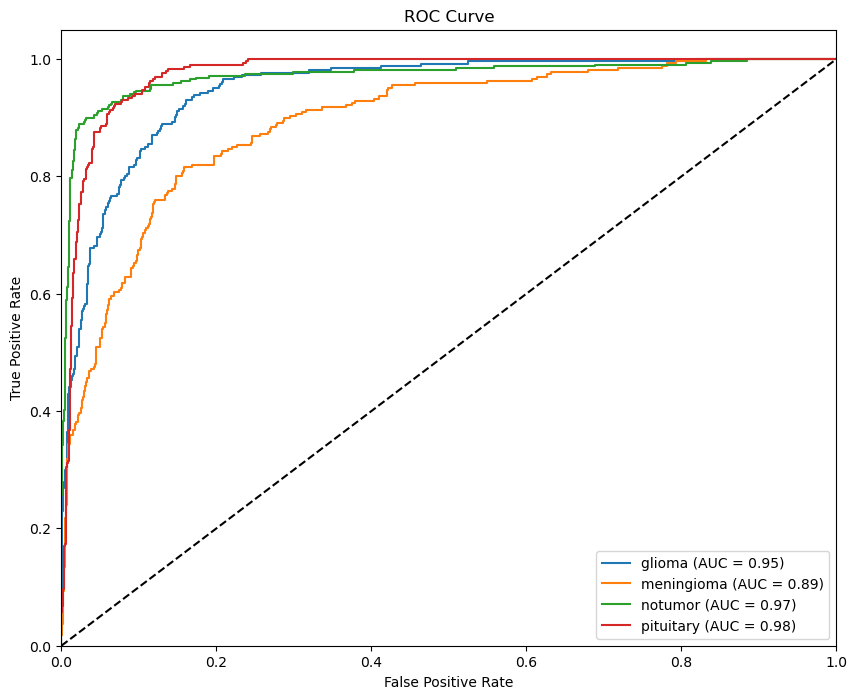


=== Test Set Performance ===
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.67      0.82      0.74       300
  meningioma       0.67      0.47      0.55       306
     notumor       0.88      0.81      0.84       405
   pituitary       0.77      0.92      0.84       300

    accuracy                           0.76      1311
   macro avg       0.75      0.76      0.74      1311
weighted avg       0.76      0.76      0.75      1311

Confusion Matrix:
 [[246  33   1  20]
 [ 84 143  43  36]
 [ 21  29 329  26]
 [ 14   8   1 277]]
Accuracy: 0.7590
Precision: 0.7592
Recall: 0.7590
F1-Score: 0.7512


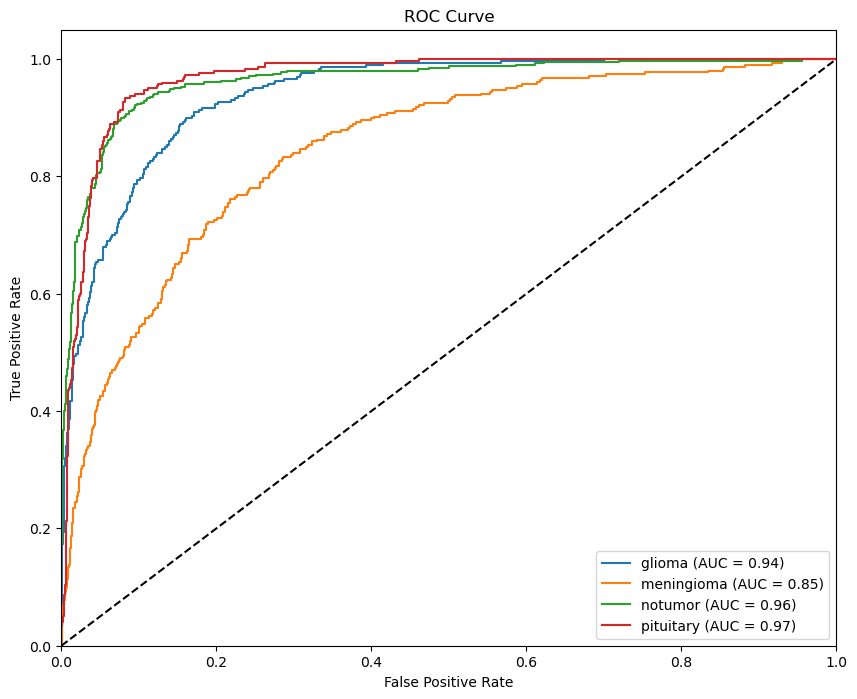

In [ ]:
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
#Model5 is trained based on the above best hyperparameter. In Part2, we will not include codes related to training models.

# Evaluate on Validation Set
print("=== Validation Set Performance ===")
y_pred_prob_val, y_pred_val = evaluate_model(model5, X_val, y_val, classes)
# Plot ROC curve for validation set
plot_roc_auc(y_val, y_pred_prob_val, classes)

# Evaluate on Test Set
print("\n=== Test Set Performance ===")
X_test, y_test = extract_data_from_generator(test_data)
# Evaluate on test set
y_pred_prob_test, y_pred_test = evaluate_model(model5, X_test, y_test, classes)
# Plot ROC curve for test set
plot_roc_auc(y_test, y_pred_prob_test, classes)

In [ ]:
# Trial 11:
# This code tried the following hyperparameters:
    # - Number of layers
    # - Number of filters
    # - Learning rate
    # - Batch size

# Fix random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

def create_model(trial):
    model = keras.Sequential()

    # Hyperparameter 1: Number of layers
    n_layers = trial.suggest_int('n_layers', 1, 3)  

    #Hyperparameter 2: Number of filters
    num_filters = trial.suggest_int('num_filters', 16, 64)  
    activation = 'relu'  

    # Add convolutional layers based on the number of layers
    for i in range(n_layers):
        # Define input shape only for the first layer
        model.add(layers.Conv2D(num_filters, (3, 3), activation=activation, padding='same', input_shape=(30, 30, 1) if i == 0 else None))
        # Add pooling after every convolutional layer
        model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation=activation))
    model.add(layers.Dense(4, activation='softmax'))

    # Hyperparameter 3: Learning rate
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)

    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

def objective(trial):
    model = create_model(trial)

    # Hyperparameter 4: Batch size
    batch_size = trial.suggest_int('batch_size', 16, 64)

    # Define an early stopping callback
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                        epochs=10, batch_size=batch_size, verbose=0, callbacks=[early_stopping])

    accuracy = history.history['val_accuracy'][-1]
    return accuracy

# Run the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

#Print the best hyperparameters foun
best_trial = study.best_trial
print("Best hyperparameters: ", best_trial.params)
print("Best accuracy: ", best_trial.value)


[I 2024-09-23 22:34:20,872] A new study created in memory with name: no-name-4af089d5-e66e-48b9-9339-105dd77eb0a0
[I 2024-09-23 22:34:44,242] Trial 0 finished with value: 0.7742782235145569 and parameters: {'n_layers': 2, 'num_filters': 50, 'learning_rate': 0.011361285032865712, 'batch_size': 42}. Best is trial 0 with value: 0.7742782235145569.
[I 2024-09-23 22:34:57,471] Trial 1 finished with value: 0.27646544575691223 and parameters: {'n_layers': 3, 'num_filters': 17, 'learning_rate': 1.3780055544748292e-05, 'batch_size': 39}. Best is trial 0 with value: 0.7742782235145569.
[I 2024-09-23 22:35:21,236] Trial 2 finished with value: 0.6465441584587097 and parameters: {'n_layers': 2, 'num_filters': 60, 'learning_rate': 0.02932733364987373, 'batch_size': 32}. Best is trial 0 with value: 0.7742782235145569.
[I 2024-09-23 22:35:32,626] Trial 3 finished with value: 0.22834645211696625 and parameters: {'n_layers': 3, 'num_filters': 21, 'learning_rate': 0.07311236346065149, 'batch_size': 49}. 

Best hyperparameters:  {'n_layers': 3, 'num_filters': 41, 'learning_rate': 0.00214622287193043, 'batch_size': 36}
Best accuracy:  0.8005249500274658


=== Validation Set Performance ===
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.79      0.71      0.75       261
  meningioma       0.67      0.71      0.69       267
     notumor       0.91      0.90      0.90       316
   pituitary       0.87      0.91      0.89       299

    accuracy                           0.81      1143
   macro avg       0.81      0.81      0.81      1143
weighted avg       0.82      0.81      0.81      1143

Confusion Matrix:
 [[185  66   4   6]
 [ 36 190  22  19]
 [  6  11 283  16]
 [  7  18   1 273]]
Accuracy: 0.8145
Precision: 0.8161
Recall: 0.8145
F1-Score: 0.8145


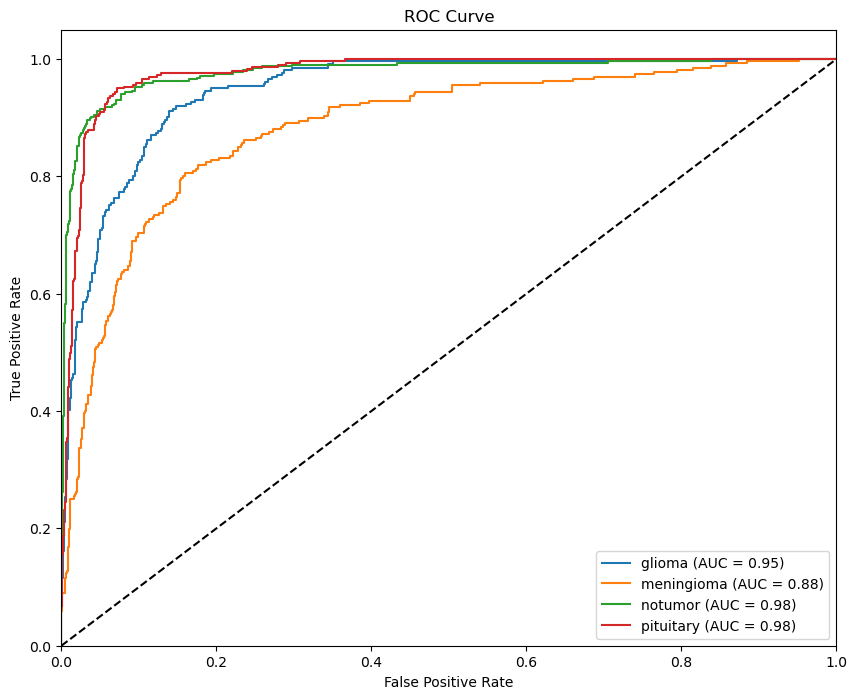


=== Test Set Performance ===
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.76      0.69      0.72       300
  meningioma       0.59      0.56      0.57       306
     notumor       0.85      0.89      0.87       405
   pituitary       0.79      0.86      0.82       300

    accuracy                           0.76      1311
   macro avg       0.75      0.75      0.75      1311
weighted avg       0.76      0.76      0.76      1311

Confusion Matrix:
 [[207  76   1  16]
 [ 48 171  55  32]
 [  6  19 360  20]
 [ 13  23   6 258]]
Accuracy: 0.7597
Precision: 0.7556
Recall: 0.7597
F1-Score: 0.7568


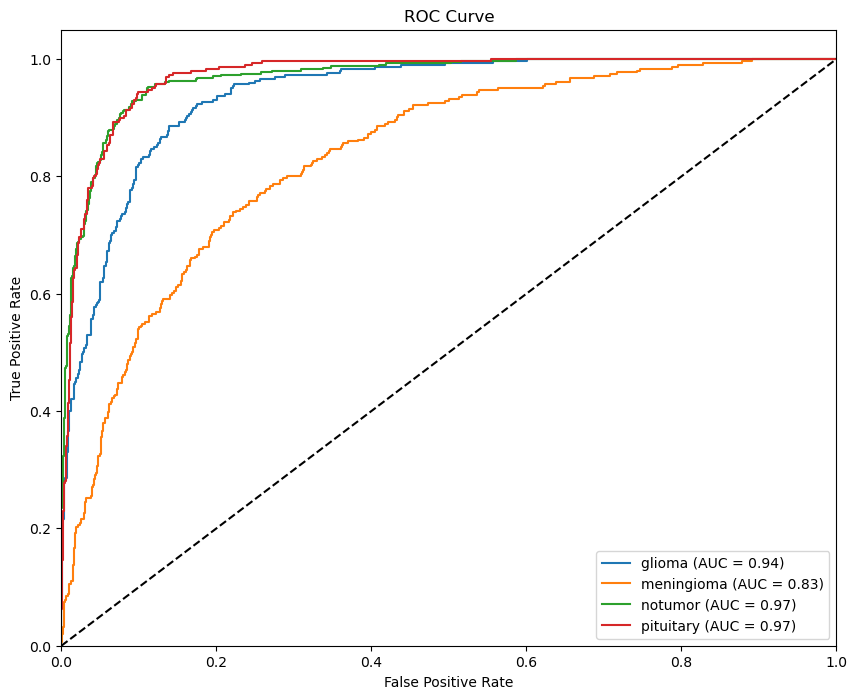

In [ ]:
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
#Model7 is trained based on the above best hyperparameter. In Part2, we will not include codes related to training models.

# Evaluate on Validation Set
print("=== Validation Set Performance ===")
y_pred_prob_val, y_pred_val = evaluate_model(model7, X_val, y_val, classes)
# Plot ROC curve for validation set
plot_roc_auc(y_val, y_pred_prob_val, classes)

# Evaluate on test set
print("\n=== Test Set Performance ===")
X_test, y_test = extract_data_from_generator(test_data)
# Evaluate on test set
y_pred_prob_test, y_pred_test = evaluate_model(model7, X_test, y_test, classes)
# Plot ROC curve for test set
plot_roc_auc(y_test, y_pred_prob_test, classes)

##### - Method 2: random search with k-fold cross-validation

In [ ]:
#Because scikit-learn is conflict with TensorFlow, this method is stimulating the random search with K-fold cross validation

# Define the function to create the model
def create_model(learning_rate=0.001, filters=32, optimizer='Adam', dropout_rate=0.2, kernel_size=(3, 3), activation='relu'):
    model = Sequential()

    # First convolutional layer
    model.add(layers.Conv2D(filters, kernel_size, activation=activation, padding='same', input_shape=(30, 30, 1)))
    model.add(layers.MaxPooling2D((2, 2)))

    # Second convolutional layer
    model.add(layers.Conv2D(filters, kernel_size, activation=activation))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten the layers
    model.add(layers.Flatten())

    # Dropout layer
    model.add(layers.Dropout(dropout_rate))

    # Dense layer
    model.add(layers.Dense(32, activation=activation))

    # Output layer for classification
    model.add(layers.Dense(4, activation='softmax'))

    # Optimizer type
    if optimizer == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'SGD':
        optimizer = SGD(learning_rate=learning_rate)
    elif optimizer == 'RMSprop':
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Define the hyperparameters to tune
param_grid = {
    'filters': [32, 64],
    'learning_rate': [0.001,0.002,0.003],
    'batch_size': [16, 32],
    'epochs': [10, 15],
    'optimizer': ['Adam', 'RMSprop'],
    'dropout_rate': [0.2, 0.3, 0.5],
    'kernel_size': [(3, 3), (5, 5)],
    'activation': ['relu', 'elu', 'swish']
}

# Create a list of hyperparameter combinations
param_combinations = [
    (f, lr, batch_size, epochs, optimizer, dropout_rate, kernel_size, activation)
    for f in param_grid['filters']
    for lr in param_grid['learning_rate']
    for batch_size in param_grid['batch_size']
    for epochs in param_grid['epochs']
    for optimizer in param_grid['optimizer']
    for dropout_rate in param_grid['dropout_rate']
    for kernel_size in param_grid['kernel_size']
    for activation in param_grid['activation']
]

# Sample random combinations from the grid
n_random_combinations = 5  
random_combinations = random.sample(param_combinations, n_random_combinations)

# Manual loop for random hyperparameter tuning with K-Fold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

best_accuracy = 0
best_params = {}

# Simulate the random search process with K-Fold
for f, lr, batch_size, epochs, optimizer, dropout_rate, kernel_size, activation in random_combinations:
    print(f"Training with filters={f}, learning_rate={lr}, batch_size={batch_size}, epochs={epochs}, optimizer={optimizer}, dropout_rate={dropout_rate}, kernel_size={kernel_size}, activation={activation}")
    
    fold_accuracies = []
    
    for train_index, val_index in kfold.split(X_train):
        X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]

        # Create the model
        model = create_model(learning_rate=lr, filters=f, optimizer=optimizer, dropout_rate=dropout_rate, kernel_size=kernel_size, activation=activation)

        # Train the model on the current fold
        history = model.fit(X_fold_train, y_fold_train, epochs=epochs, batch_size=batch_size, validation_data=(X_fold_val, y_fold_val), verbose=0)

        # Evaluate the model on the validation data
        val_loss, val_accuracy = model.evaluate(X_fold_val, y_fold_val, verbose=0)
        fold_accuracies.append(val_accuracy)

    # Calculate the mean accuracy over all folds
    mean_val_accuracy = np.mean(fold_accuracies)
    print(f"Mean Validation Accuracy: {mean_val_accuracy}")

    # Keep track of the best model
    if mean_val_accuracy > best_accuracy:
        best_accuracy = mean_val_accuracy
        best_params = {
            'filters': f,
            'learning_rate': lr,
            'batch_size': batch_size,
            'epochs': epochs,
            'optimizer': optimizer,
            'dropout_rate': dropout_rate,
            'kernel_size': kernel_size,
            'activation': activation
        }

# Print the best hyperparameters
print(f"Best Accuracy: {best_accuracy}")
print(f"Best Parameters: {best_params}")

# Train the model with the best parameters on the full training set (X_train + X_val)

# Combine the training and validation data
X_combined = np.concatenate([X_train, X_val], axis=0)
y_combined = np.concatenate([y_train, y_val], axis=0)

# Create the model using the best parameters
best_model = create_model(
    learning_rate=best_params['learning_rate'],
    filters=best_params['filters'],
    optimizer=best_params['optimizer'],
    dropout_rate=best_params['dropout_rate'],
    kernel_size=best_params['kernel_size'],
    activation=best_params['activation']
)

# Train the model on the combined training and validation data
best_model.fit(X_combined, y_combined, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = best_model.evaluate(test_data, verbose=0)

print(f"Test Accuracy: {test_accuracy}")

Training with filters=32, learning_rate=0.001, batch_size=16, epochs=10, optimizer=RMSprop, dropout_rate=0.3, kernel_size=(5, 5), activation=relu
Mean Validation Accuracy: 0.7870432138442993
Training with filters=64, learning_rate=0.001, batch_size=32, epochs=15, optimizer=RMSprop, dropout_rate=0.5, kernel_size=(5, 5), activation=elu
Mean Validation Accuracy: 0.786824643611908
Training with filters=32, learning_rate=0.002, batch_size=16, epochs=15, optimizer=RMSprop, dropout_rate=0.2, kernel_size=(5, 5), activation=swish
Mean Validation Accuracy: 0.7907695889472961
Training with filters=64, learning_rate=0.003, batch_size=16, epochs=10, optimizer=Adam, dropout_rate=0.5, kernel_size=(3, 3), activation=elu
Mean Validation Accuracy: 0.803895103931427
Training with filters=64, learning_rate=0.002, batch_size=32, epochs=10, optimizer=Adam, dropout_rate=0.5, kernel_size=(5, 5), activation=swish
Mean Validation Accuracy: 0.8117800116539001
Best Accuracy: 0.8117800116539001
Best Parameters: {'

##### - Method 3: manually


=== Test Set Performance ===
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.65      0.86      0.74       300
  meningioma       0.62      0.35      0.45       306
     notumor       0.87      0.82      0.84       405
   pituitary       0.74      0.90      0.81       300

    accuracy                           0.74      1311
   macro avg       0.72      0.73      0.71      1311
weighted avg       0.73      0.74      0.72      1311

Confusion Matrix:
 [[259  23   0  18]
 [100 106  49  51]
 [ 22  27 331  25]
 [ 17  14   0 269]]
Accuracy: 0.7361
Precision: 0.7331
Recall: 0.7361
F1 Score: 0.7200


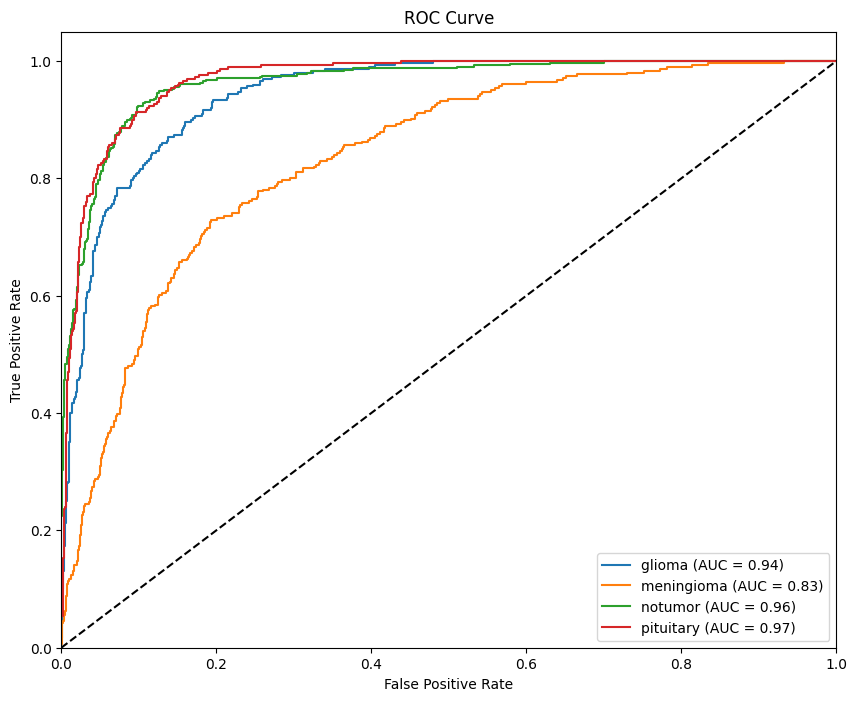


=== Test Set Confusion Matrix ===


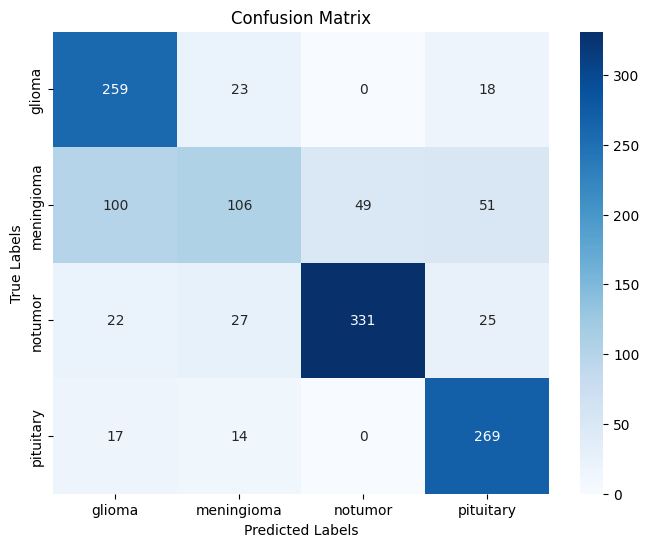

Weighted Precision: 0.7331
Weighted Recall: 0.7361
Macro Average AUC: 0.9273


In [ ]:
# Trial 1: Add one more convolutional layer

# Evaluate on Test Set
print("\n=== Test Set Performance ===")

# Evaluate on test set
y_pred_prob_test, y_pred_test = evaluate_model(model, X_test, y_test, classes)

# Plot ROC curve for test set
plot_roc_auc(y_test, y_pred_prob_test, classes)

# Plot confusion matrix for the test set
print("\n=== Test Set Confusion Matrix ===")
y_pred_test_classes = np.argmax(y_pred_prob_test, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
plot_confusion_matrix(y_test_classes, y_pred_test_classes, classes)

# Calculate weighted precision and recall
weighted_precision = precision_score(y_test_classes, y_pred_test_classes, average='weighted')
weighted_recall = recall_score(y_test_classes, y_pred_test_classes, average='weighted')

print(f"Weighted Precision: {weighted_precision:.4f}")
print(f"Weighted Recall: {weighted_recall:.4f}")

# Calculate macro average AUC
auc_macro = roc_auc_score(
    label_binarize(np.argmax(y_test, axis=1), classes=np.arange(len(classes))),
    y_pred_prob_test,
    average='macro',
    multi_class='ovr'
)
print(f"Macro Average AUC: {auc_macro:.4f}")


=== Test Set Performance ===
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.63      0.84      0.72       300
  meningioma       0.59      0.44      0.50       306
     notumor       0.90      0.77      0.83       405
   pituitary       0.78      0.87      0.82       300

    accuracy                           0.73      1311
   macro avg       0.73      0.73      0.72      1311
weighted avg       0.74      0.73      0.73      1311

Confusion Matrix:
 [[252  34   1  13]
 [100 135  33  38]
 [ 21  49 313  22]
 [ 28  11   0 261]]
Accuracy: 0.7330
Precision: 0.7389
Recall: 0.7330
F1 Score: 0.7279


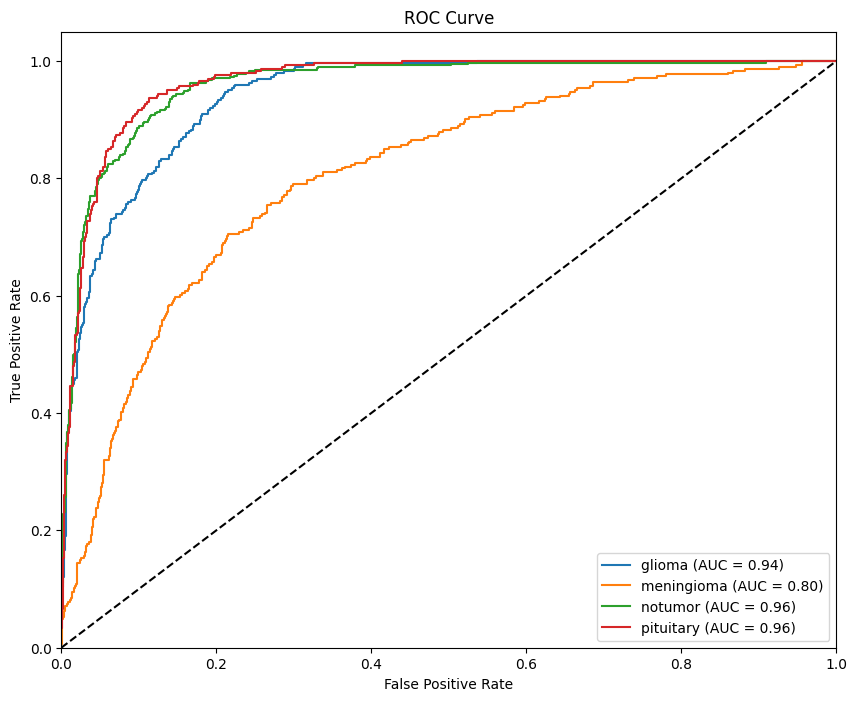


=== Test Set Confusion Matrix ===


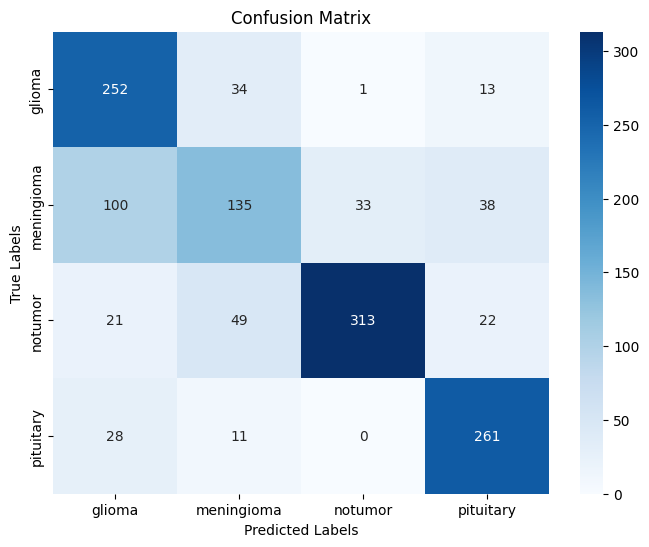

Weighted Precision: 0.7389
Weighted Recall: 0.7330
Macro Average AUC: 0.9178


In [ ]:
# Trial 2: Add two more convolutional layers

# Evaluate on Test Set
print("\n=== Test Set Performance ===")

# Evaluate on test set
y_pred_prob_test, y_pred_test = evaluate_model(model, X_test, y_test, classes)

# Plot ROC curve for test set
plot_roc_auc(y_test, y_pred_prob_test, classes)

# Plot confusion matrix for the test set
print("\n=== Test Set Confusion Matrix ===")
y_pred_test_classes = np.argmax(y_pred_prob_test, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
plot_confusion_matrix(y_test_classes, y_pred_test_classes, classes)

# Calculate weighted precision and recall
weighted_precision = precision_score(y_test_classes, y_pred_test_classes, average='weighted')
weighted_recall = recall_score(y_test_classes, y_pred_test_classes, average='weighted')

print(f"Weighted Precision: {weighted_precision:.4f}")
print(f"Weighted Recall: {weighted_recall:.4f}")

# Calculate macro average AUC
auc_macro = roc_auc_score(
    label_binarize(np.argmax(y_test, axis=1), classes=np.arange(len(classes))),
    y_pred_prob_test,
    average='macro',
    multi_class='ovr'
)
print(f"Macro Average AUC: {auc_macro:.4f}")


=== Test Set Performance ===
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.76      0.83      0.79       300
  meningioma       0.72      0.45      0.55       306
     notumor       0.85      0.90      0.88       405
   pituitary       0.77      0.94      0.85       300

    accuracy                           0.79      1311
   macro avg       0.77      0.78      0.77      1311
weighted avg       0.78      0.79      0.77      1311

Confusion Matrix:
 [[248  33   0  19]
 [ 64 138  61  43]
 [  8  12 364  21]
 [  8  10   1 281]]
Accuracy: 0.7864
Precision: 0.7805
Recall: 0.7864
F1 Score: 0.7741


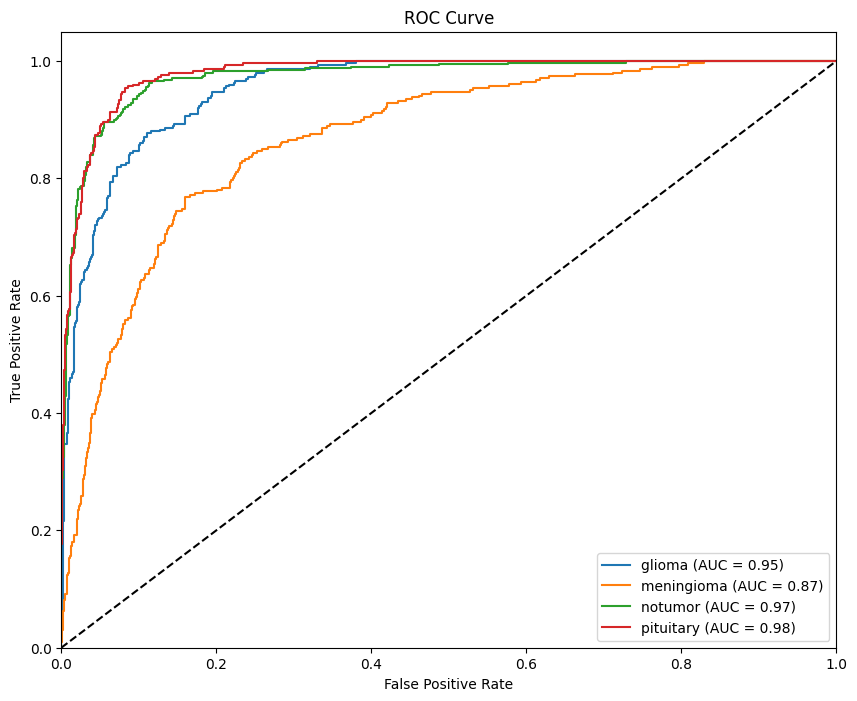


=== Test Set Confusion Matrix ===


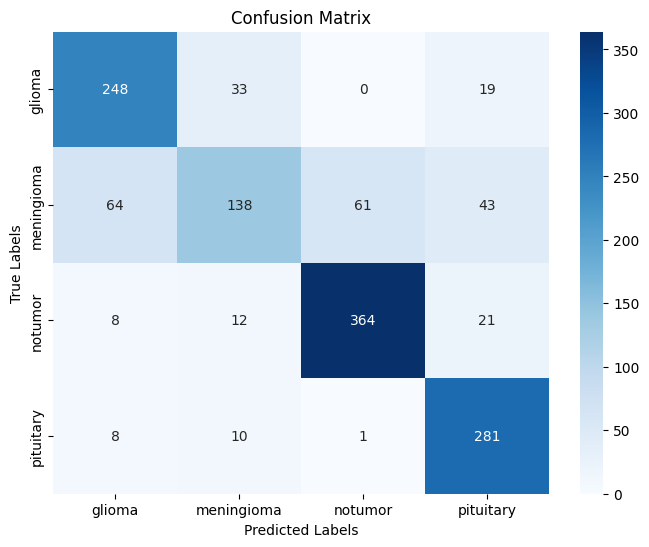

Weighted Precision: 0.7805
Weighted Recall: 0.7864
Macro Average AUC: 0.9437


In [ ]:
# Trial 3: Add filters for all layers:
# *   the first layer with 64 filters (instead of 32)
# *   the second layer with 64 filters (instead of 32)
# *   the third layer with 128 filters (instead of 64)

# Evaluate on Test Set
print("\n=== Test Set Performance ===")

# Evaluate on test set
y_pred_prob_test, y_pred_test = evaluate_model(model, X_test, y_test, classes)

# Plot ROC curve for test set
plot_roc_auc(y_test, y_pred_prob_test, classes)

# Plot confusion matrix for the test set
print("\n=== Test Set Confusion Matrix ===")
y_pred_test_classes = np.argmax(y_pred_prob_test, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
plot_confusion_matrix(y_test_classes, y_pred_test_classes, classes)

# Calculate weighted precision and recall
weighted_precision = precision_score(y_test_classes, y_pred_test_classes, average='weighted')
weighted_recall = recall_score(y_test_classes, y_pred_test_classes, average='weighted')

print(f"Weighted Precision: {weighted_precision:.4f}")
print(f"Weighted Recall: {weighted_recall:.4f}")

# Calculate macro average AUC
auc_macro = roc_auc_score(
    label_binarize(np.argmax(y_test, axis=1), classes=np.arange(len(classes))),
    y_pred_prob_test,
    average='macro',
    multi_class='ovr'
)
print(f"Macro Average AUC: {auc_macro:.4f}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 30, 30, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 13, 13, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 6, 6, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │          36,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 259,108 (1012.14 KB)

 Trainable params: 259,108 (1012.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.4621 - loss: 1.1525 - val_accuracy: 0.6220 - val_loss: 0.9086
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.7114 - loss: 0.7358 - val_accuracy: 0.7367 - val_loss: 0.6980
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.7735 - loss: 0.5997 - val_accuracy: 0.7472 - val_loss: 0.6555
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.8038 - loss: 0.5248 - val_accuracy: 0.7778 - val_loss: 0.5906
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.8244 - loss: 0.4576 - val_accuracy: 0.8014 - val_loss: 0.5521
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.8488 - loss: 0.4032 - val_accuracy: 0.8163 - val_loss: 0.5301
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.8741 - loss: 0.3517 - val_accuracy: 0.8241 - val_loss: 0.5094
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.8901 - loss: 0.3016 - val_accu

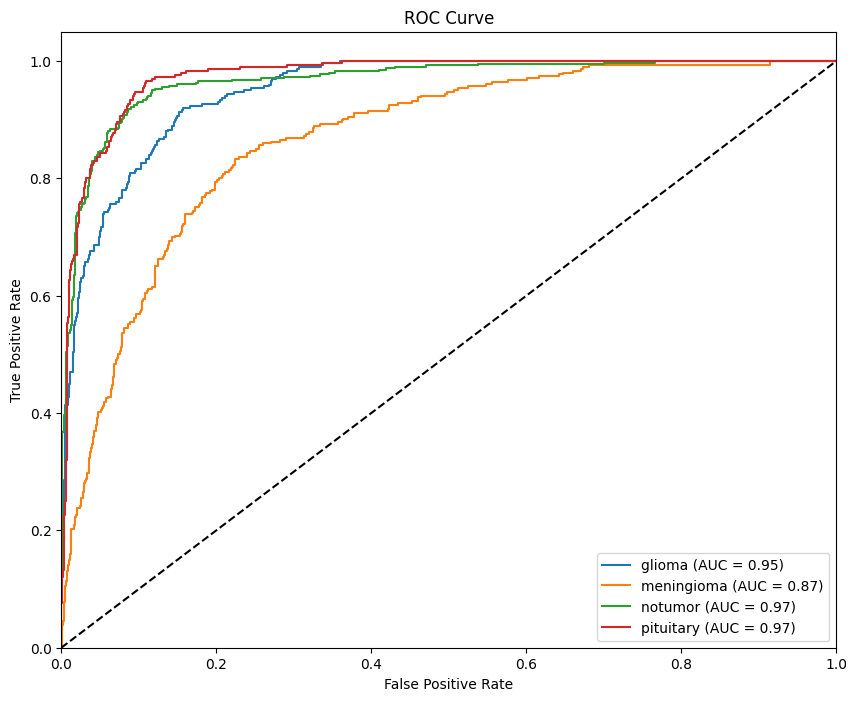


=== Test Set Confusion Matrix ===


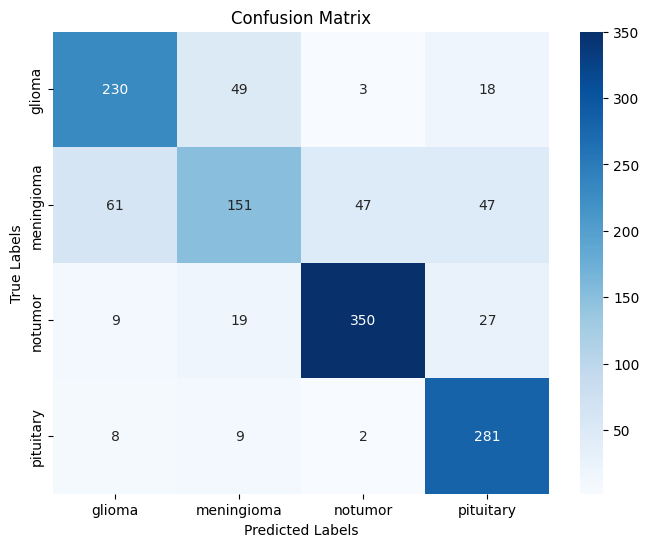

Weighted Precision: 0.7668
Weighted Recall: 0.7719
Macro Average AUC: 0.9393


In [ ]:
# Trial 4: Add filters only for the second layer (based on the model above)
# *   the second layer with 128 filters (instead of 64)

# Initialize the Sequential model
model = models.Sequential()

# First convolutional layer with 64 filters of size 3x3, followed by ReLU activation and padding='same'
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2d_4', input_shape=(30, 30, 1)))
# First max pooling layer with pool size 2x2
model.add(layers.MaxPooling2D((2, 2), name='max_pooling2d_4'))  

# Second convolutional layer with 128 filters of size 3x3, followed by ReLU activation and padding='same'
model.add(layers.Conv2D(128, (3, 3), activation='relu', name='conv2d_5'))
# Second max pooling layer with pool size 2x2
model.add(layers.MaxPooling2D((2, 2), name='max_pooling2d_5'))

# Add an additional convolutional layer with 128 filters of size 3x3, followed by ReLU activation and padding='same'
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2d_6')) 
model.add(layers.MaxPooling2D((2, 2), name='max_pooling2d_6'))  

# Flatten the 3D output from the convolutional layers to 1D
model.add(layers.Flatten(name='flatten_2'))

# First dense layer with 32 units and ReLU activation
model.add(layers.Dense(32, activation='relu', name='dense_4'))

# Final dense layer with 4 units (for 4 classes) and softmax activation
model.add(layers.Dense(4, activation='softmax', name='dense_5'))

# Compile the model
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Define an early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

# Evaluate the model on validation set
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_acc}")

# 2. Evaluate on Test Set
print("\n=== Test Set Performance ===")


# Evaluate on test set
y_pred_prob_test, y_pred_test = evaluate_model(model, X_test, y_test, classes)

# Plot ROC curve for test set
plot_roc_auc(y_test, y_pred_prob_test, classes)

# Plot confusion matrix for the test set
print("\n=== Test Set Confusion Matrix ===")
y_pred_test_classes = np.argmax(y_pred_prob_test, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
plot_confusion_matrix(y_test_classes, y_pred_test_classes, classes)

# Calculate weighted precision and recall
weighted_precision = precision_score(y_test_classes, y_pred_test_classes, average='weighted')
weighted_recall = recall_score(y_test_classes, y_pred_test_classes, average='weighted')

print(f"Weighted Precision: {weighted_precision:.4f}")
print(f"Weighted Recall: {weighted_recall:.4f}")

# Calculate macro average AUC
auc_macro = roc_auc_score(
    label_binarize(np.argmax(y_test, axis=1), classes=np.arange(len(classes))),
    y_pred_prob_test,
    average='macro',
    multi_class='ovr'
)
print(f"Macro Average AUC: {auc_macro:.4f}")



=== Test Set Performance ===
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.75      0.79      0.77       300
  meningioma       0.65      0.49      0.56       306
     notumor       0.85      0.87      0.86       405
   pituitary       0.78      0.90      0.84       300

    accuracy                           0.77      1311
   macro avg       0.76      0.77      0.76      1311
weighted avg       0.76      0.77      0.77      1311

Confusion Matrix:
 [[238  46   3  13]
 [ 55 151  57  43]
 [  8  24 354  19]
 [ 15  13   2 270]]
Accuracy: 0.7727
Precision: 0.7649
Recall: 0.7727
F1 Score: 0.7653


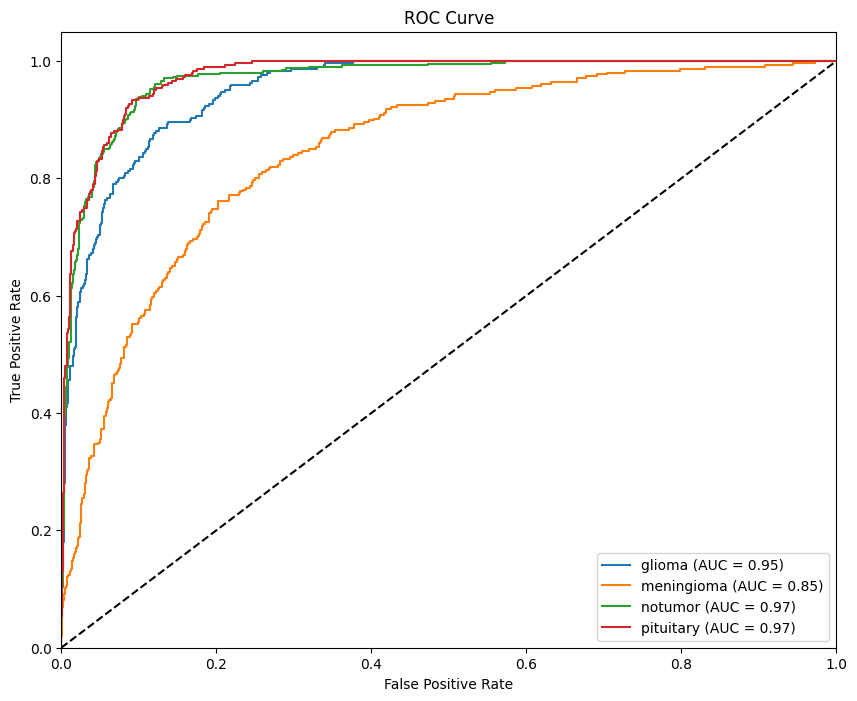


=== Test Set Confusion Matrix ===


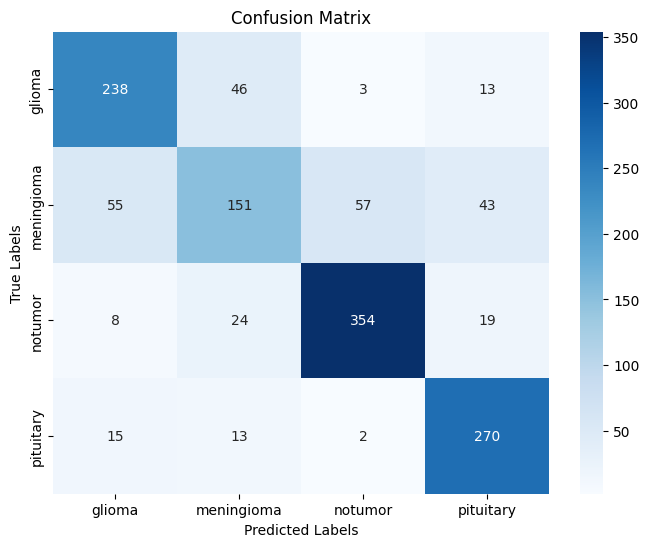

Weighted Precision: 0.7649
Weighted Recall: 0.7727
Macro Average AUC: 0.9360


In [ ]:
# Trial 5: Change filter size from 3×3 to 5×5 for all layers

# Evaluate on Test Set
print("\n=== Test Set Performance ===")

# Evaluate on test set
y_pred_prob_test, y_pred_test = evaluate_model(model, X_test, y_test, classes)

# Plot ROC curve for test set
plot_roc_auc(y_test, y_pred_prob_test, classes)

# Plot confusion matrix for the test set
print("\n=== Test Set Confusion Matrix ===")
y_pred_test_classes = np.argmax(y_pred_prob_test, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
plot_confusion_matrix(y_test_classes, y_pred_test_classes, classes)

# Calculate weighted precision and recall
weighted_precision = precision_score(y_test_classes, y_pred_test_classes, average='weighted')
weighted_recall = recall_score(y_test_classes, y_pred_test_classes, average='weighted')

print(f"Weighted Precision: {weighted_precision:.4f}")
print(f"Weighted Recall: {weighted_recall:.4f}")

# Calculate macro average AUC
auc_macro = roc_auc_score(
    label_binarize(np.argmax(y_test, axis=1), classes=np.arange(len(classes))),
    y_pred_prob_test,
    average='macro',
    multi_class='ovr'
)
print(f"Macro Average AUC: {auc_macro:.4f}")


=== Test Set Performance ===
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.83      0.73      0.78       300
  meningioma       0.68      0.62      0.65       306
     notumor       0.91      0.90      0.90       405
   pituitary       0.76      0.94      0.84       300

    accuracy                           0.80      1311
   macro avg       0.80      0.80      0.79      1311
weighted avg       0.81      0.80      0.80      1311

Confusion Matrix:
 [[219  62   0  19]
 [ 36 190  36  44]
 [  3  14 364  24]
 [  6  12   0 282]]
Accuracy: 0.8047
Precision: 0.8054
Recall: 0.8047
F1 Score: 0.8019


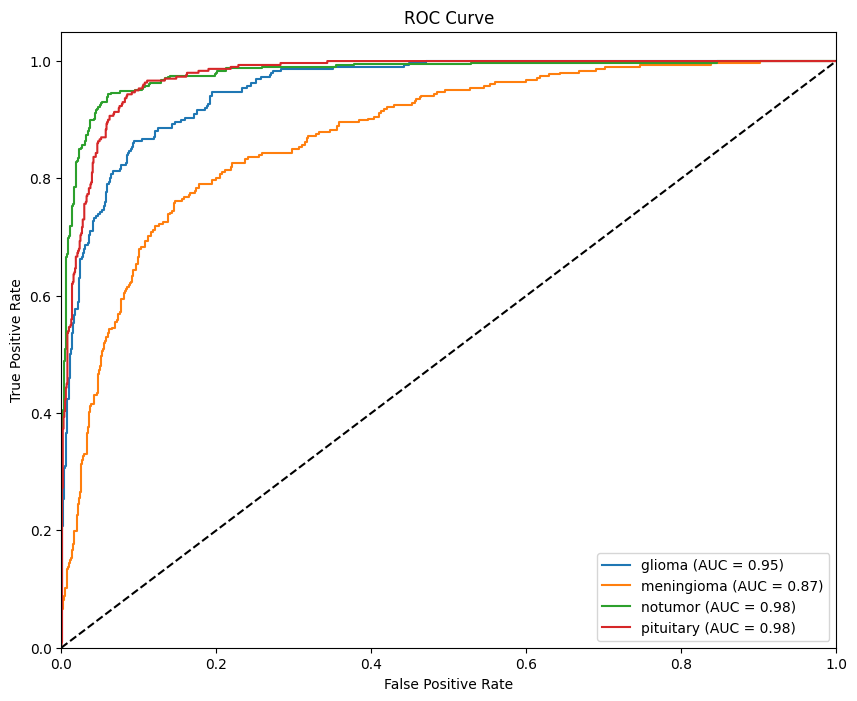


=== Test Set Confusion Matrix ===


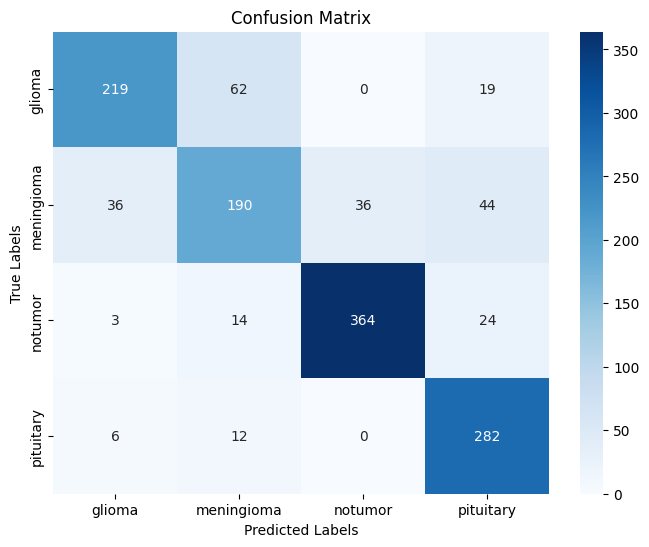

Weighted Precision: 0.8054
Weighted Recall: 0.8047
Macro Average AUC: 0.9459


In [ ]:
# Trial 6: Only change the filter size for the last(third) layer to 5×5

# Evaluate on Test Set
print("\n=== Test Set Performance ===")

# Evaluate on test set
y_pred_prob_test, y_pred_test = evaluate_model(model, X_test, y_test, classes)

# Plot ROC curve for test set
plot_roc_auc(y_test, y_pred_prob_test, classes)

# Plot confusion matrix for the test set
print("\n=== Test Set Confusion Matrix ===")
y_pred_test_classes = np.argmax(y_pred_prob_test, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
plot_confusion_matrix(y_test_classes, y_pred_test_classes, classes)

# Calculate weighted precision and recall
weighted_precision = precision_score(y_test_classes, y_pred_test_classes, average='weighted')
weighted_recall = recall_score(y_test_classes, y_pred_test_classes, average='weighted')

print(f"Weighted Precision: {weighted_precision:.4f}")
print(f"Weighted Recall: {weighted_recall:.4f}")

# Calculate macro average AUC
auc_macro = roc_auc_score(
    label_binarize(np.argmax(y_test, axis=1), classes=np.arange(len(classes))),
    y_pred_prob_test,
    average='macro',
    multi_class='ovr'
)
print(f"Macro Average AUC: {auc_macro:.4f}")


=== Test Set Performance ===
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.81      0.75      0.78       300
  meningioma       0.68      0.55      0.60       306
     notumor       0.87      0.89      0.88       405
   pituitary       0.76      0.95      0.84       300

    accuracy                           0.79      1311
   macro avg       0.78      0.78      0.78      1311
weighted avg       0.79      0.79      0.78      1311

Confusion Matrix:
 [[224  54   1  21]
 [ 43 167  51  45]
 [  6  15 361  23]
 [  3  11   2 284]]
Accuracy: 0.7902
Precision: 0.7865
Recall: 0.7902
F1 Score: 0.7841


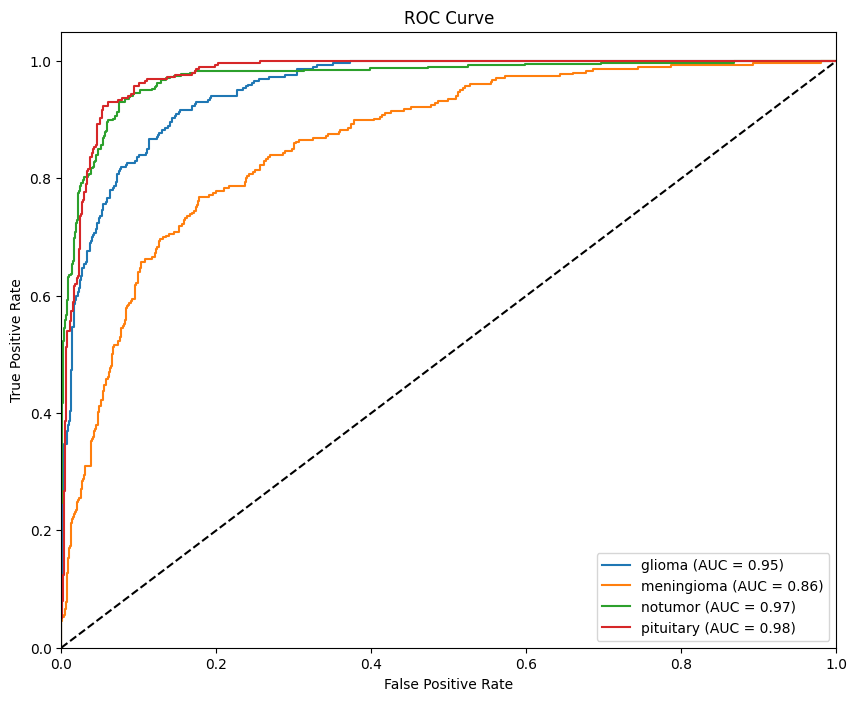


=== Test Set Confusion Matrix ===


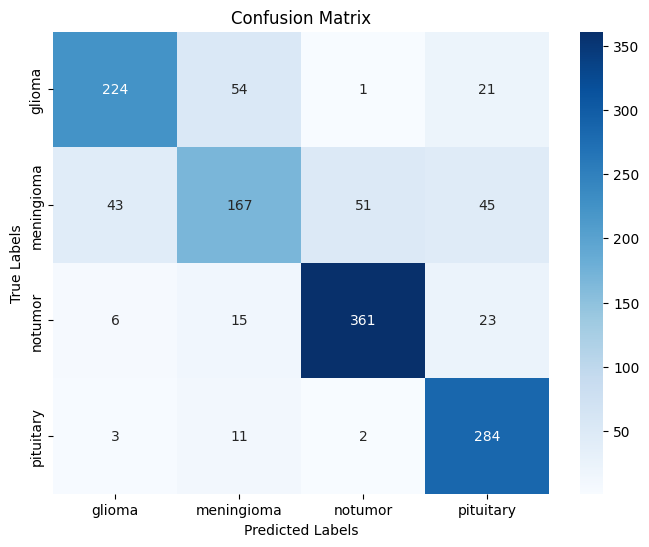

Weighted Precision: 0.7865
Weighted Recall: 0.7902
Macro Average AUC: 0.9417


In [ ]:
# Trial 7: Only change the filter size for the first layer to 5×5

# Evaluate on Test Set
print("\n=== Test Set Performance ===")

# Evaluate on test set
y_pred_prob_test, y_pred_test = evaluate_model(model, X_test, y_test, classes)

# Plot ROC curve for test set
plot_roc_auc(y_test, y_pred_prob_test, classes)

# Plot confusion matrix for the test set
print("\n=== Test Set Confusion Matrix ===")
y_pred_test_classes = np.argmax(y_pred_prob_test, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
plot_confusion_matrix(y_test_classes, y_pred_test_classes, classes)

# Calculate weighted precision and recall
weighted_precision = precision_score(y_test_classes, y_pred_test_classes, average='weighted')
weighted_recall = recall_score(y_test_classes, y_pred_test_classes, average='weighted')

print(f"Weighted Precision: {weighted_precision:.4f}")
print(f"Weighted Recall: {weighted_recall:.4f}")

# Calculate macro average AUC
auc_macro = roc_auc_score(
    label_binarize(np.argmax(y_test, axis=1), classes=np.arange(len(classes))),
    y_pred_prob_test,
    average='macro',
    multi_class='ovr'
)
print(f"Macro Average AUC: {auc_macro:.4f}")


=== Test Set Performance ===
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.82      0.70      0.75       300
  meningioma       0.64      0.65      0.65       306
     notumor       0.90      0.87      0.89       405
   pituitary       0.79      0.93      0.85       300

    accuracy                           0.79      1311
   macro avg       0.79      0.79      0.79      1311
weighted avg       0.80      0.79      0.79      1311

Confusion Matrix:
 [[210  70   2  18]
 [ 35 199  35  37]
 [  6  27 353  19]
 [  6  13   2 279]]
Accuracy: 0.7941
Precision: 0.7964
Recall: 0.7941
F1 Score: 0.7928


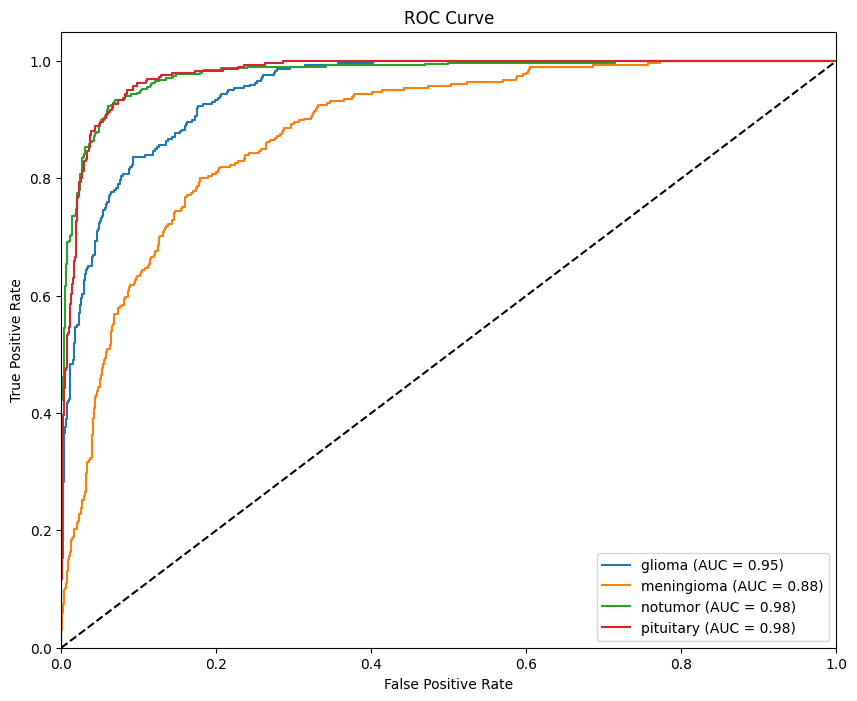


=== Test Set Confusion Matrix ===


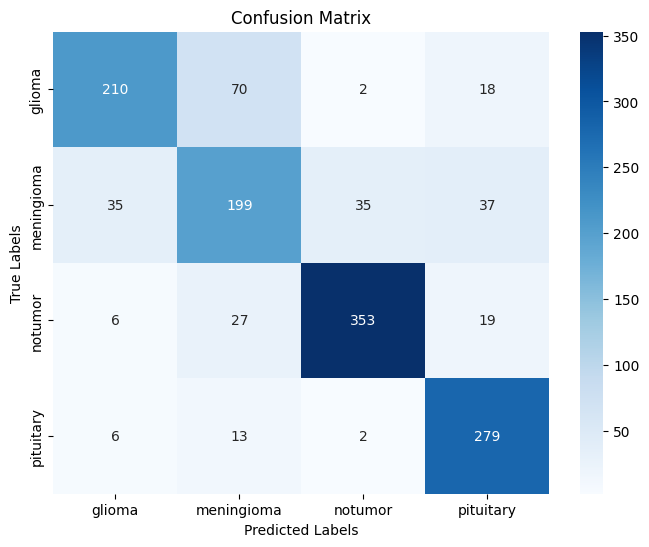

Weighted Precision: 0.7964
Weighted Recall: 0.7941
Macro Average AUC: 0.9478


In [ ]:
# Trial 8: Change learning rate - Learning rate scheduler

# Evaluate on Test Set
print("\n=== Test Set Performance ===")

# Evaluate on test set
y_pred_prob_test, y_pred_test = evaluate_model(model, X_test, y_test, classes)

# Plot ROC curve for test set
plot_roc_auc(y_test, y_pred_prob_test, classes)

# Plot confusion matrix for the test set
print("\n=== Test Set Confusion Matrix ===")
y_pred_test_classes = np.argmax(y_pred_prob_test, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
plot_confusion_matrix(y_test_classes, y_pred_test_classes, classes)

# Calculate weighted precision and recall
weighted_precision = precision_score(y_test_classes, y_pred_test_classes, average='weighted')
weighted_recall = recall_score(y_test_classes, y_pred_test_classes, average='weighted')

print(f"Weighted Precision: {weighted_precision:.4f}")
print(f"Weighted Recall: {weighted_recall:.4f}")

# Calculate macro average AUC
auc_macro = roc_auc_score(
    label_binarize(np.argmax(y_test, axis=1), classes=np.arange(len(classes))),
    y_pred_prob_test,
    average='macro',
    multi_class='ovr'
)
print(f"Macro Average AUC: {auc_macro:.4f}")


=== Test Set Performance ===
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.66      0.85      0.74       300
  meningioma       0.67      0.45      0.54       306
     notumor       0.88      0.86      0.87       405
   pituitary       0.81      0.89      0.85       300

    accuracy                           0.77      1311
   macro avg       0.76      0.76      0.75      1311
weighted avg       0.77      0.77      0.76      1311

Confusion Matrix:
 [[254  33   0  13]
 [ 92 137  46  31]
 [ 17  20 349  19]
 [ 20  13   0 267]]
Accuracy: 0.7681
Precision: 0.7674
Recall: 0.7681
F1 Score: 0.7593


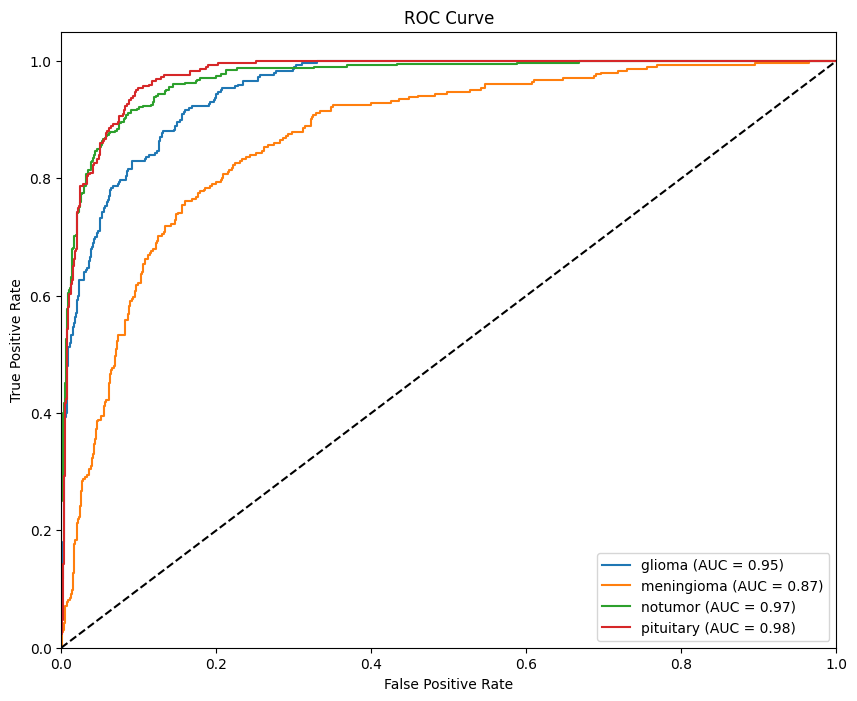


=== Test Set Confusion Matrix ===


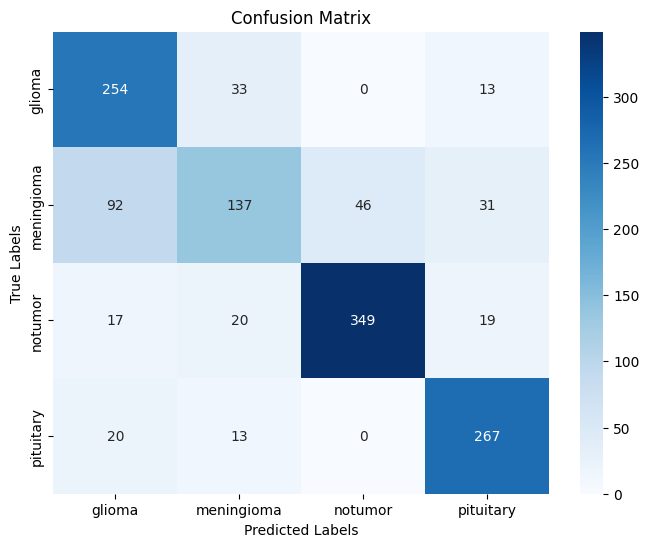

Weighted Precision: 0.7674
Weighted Recall: 0.7681
Macro Average AUC: 0.9425


In [ ]:
# Trial 9: Change learning rate - Learning rate decay (Adam)

# Evaluate on Test Set
print("\n=== Test Set Performance ===")

# Evaluate on test set
y_pred_prob_test, y_pred_test = evaluate_model(model, X_test, y_test, classes)

# Plot ROC curve for test set
plot_roc_auc(y_test, y_pred_prob_test, classes)

# Plot confusion matrix for the test set
print("\n=== Test Set Confusion Matrix ===")
y_pred_test_classes = np.argmax(y_pred_prob_test, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
plot_confusion_matrix(y_test_classes, y_pred_test_classes, classes)

# Calculate weighted precision and recall
weighted_precision = precision_score(y_test_classes, y_pred_test_classes, average='weighted')
weighted_recall = recall_score(y_test_classes, y_pred_test_classes, average='weighted')

print(f"Weighted Precision: {weighted_precision:.4f}")
print(f"Weighted Recall: {weighted_recall:.4f}")

# Calculate macro average AUC
auc_macro = roc_auc_score(
    label_binarize(np.argmax(y_test, axis=1), classes=np.arange(len(classes))),
    y_pred_prob_test,
    average='macro',
    multi_class='ovr'
)
print(f"Macro Average AUC: {auc_macro:.4f}")


=== Test Set Performance ===
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.86      0.52      0.65       300
  meningioma       0.54      0.80      0.65       306
     notumor       0.88      0.88      0.88       405
   pituitary       0.89      0.79      0.84       300

    accuracy                           0.76      1311
   macro avg       0.79      0.75      0.75      1311
weighted avg       0.80      0.76      0.76      1311

Confusion Matrix:
 [[157 123   8  12]
 [ 15 245  32  14]
 [  7  36 358   4]
 [  4  49   9 238]]
Accuracy: 0.7613
Precision: 0.7975
Recall: 0.7613
F1 Score: 0.7636


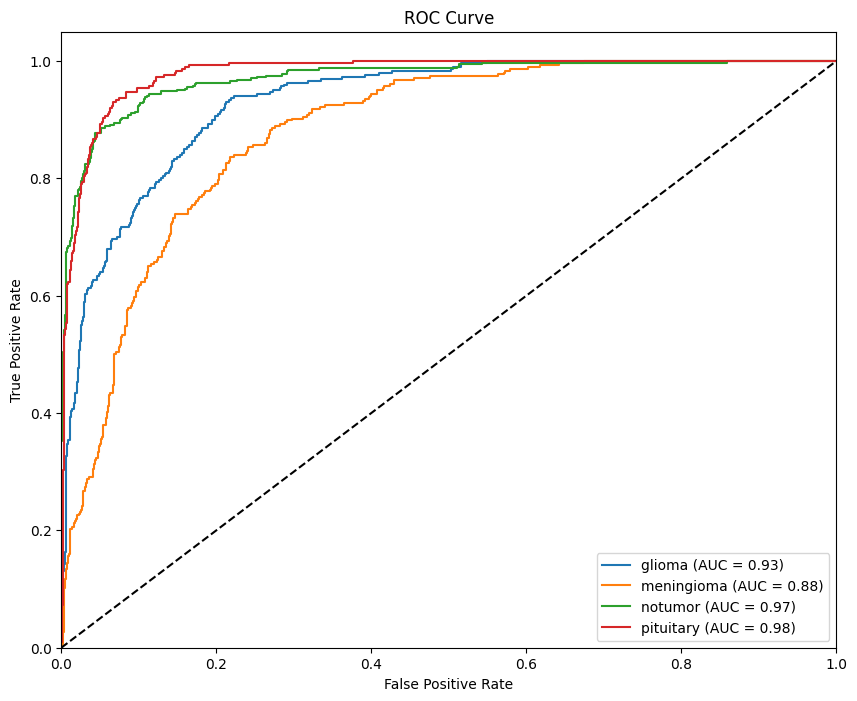


=== Test Set Confusion Matrix ===


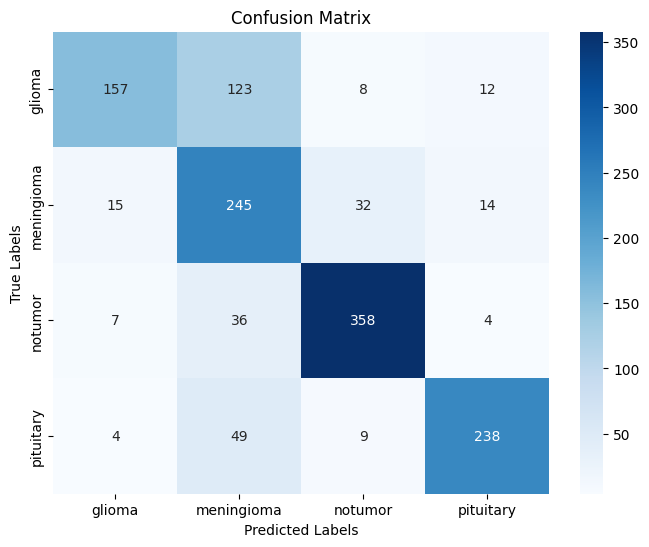

Weighted Precision: 0.7975
Weighted Recall: 0.7613
Macro Average AUC: 0.9403


In [ ]:
# Trial 10: Use tanh activation function instead of ReLU

# Evaluate on Test Set
print("\n=== Test Set Performance ===")

# Evaluate on test set
y_pred_prob_test, y_pred_test = evaluate_model(model, X_test, y_test, classes)

# Plot ROC curve for test set
plot_roc_auc(y_test, y_pred_prob_test, classes)

# Plot confusion matrix for the test set
print("\n=== Test Set Confusion Matrix ===")
y_pred_test_classes = np.argmax(y_pred_prob_test, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
plot_confusion_matrix(y_test_classes, y_pred_test_classes, classes)

# Calculate weighted precision and recall
weighted_precision = precision_score(y_test_classes, y_pred_test_classes, average='weighted')
weighted_recall = recall_score(y_test_classes, y_pred_test_classes, average='weighted')

print(f"Weighted Precision: {weighted_precision:.4f}")
print(f"Weighted Recall: {weighted_recall:.4f}")

# Calculate macro average AUC
auc_macro = roc_auc_score(
    label_binarize(np.argmax(y_test, axis=1), classes=np.arange(len(classes))),
    y_pred_prob_test,
    average='macro',
    multi_class='ovr'
)
print(f"Macro Average AUC: {auc_macro:.4f}")


=== Test Set Performance ===
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.71      0.87      0.78       300
  meningioma       0.75      0.52      0.62       306
     notumor       0.89      0.89      0.89       405
   pituitary       0.83      0.91      0.87       300

    accuracy                           0.80      1311
   macro avg       0.80      0.80      0.79      1311
weighted avg       0.80      0.80      0.80      1311

Confusion Matrix:
 [[260  25   1  14]
 [ 74 160  43  29]
 [ 18  15 360  12]
 [ 14  12   0 274]]
Accuracy: 0.8040
Precision: 0.8046
Recall: 0.8040
F1 Score: 0.7972


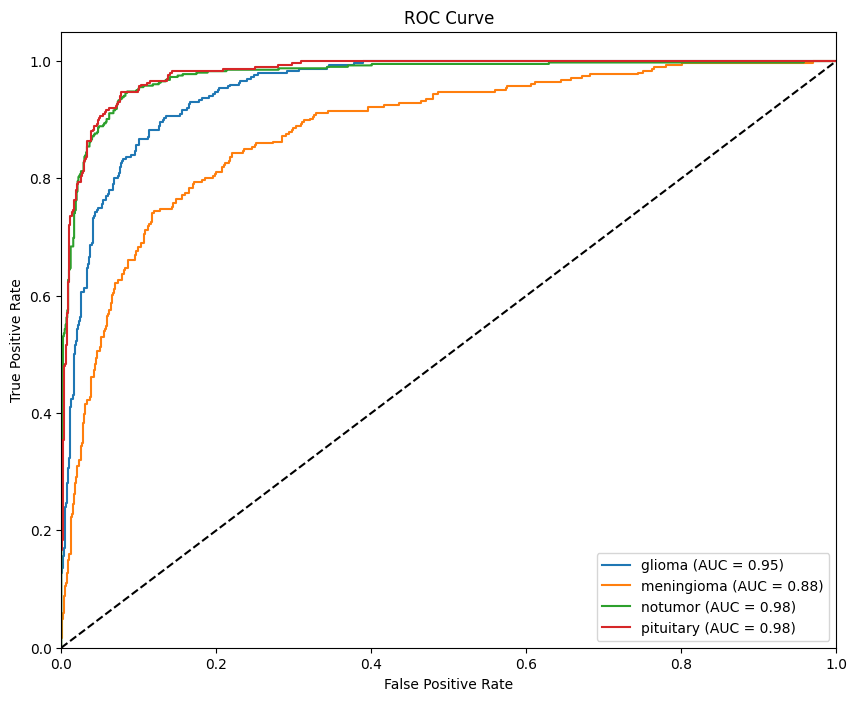


=== Test Set Confusion Matrix ===


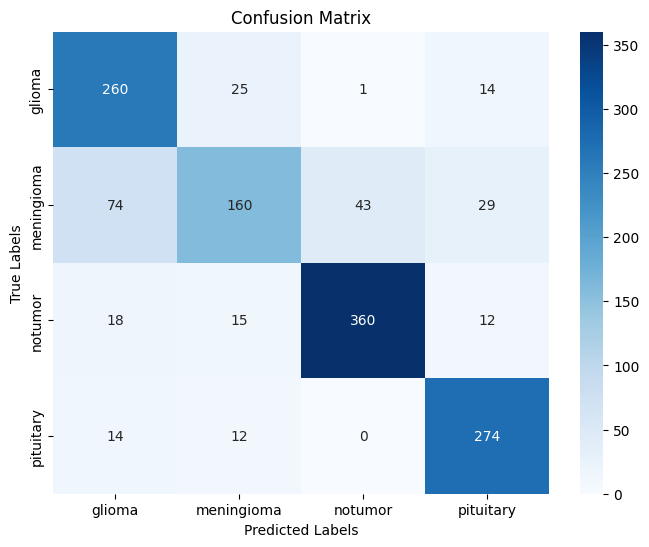

Weighted Precision: 0.8046
Weighted Recall: 0.8040
Macro Average AUC: 0.9480


In [ ]:
# Trial 11: Combine tanh and ReLU activation functions

# Evaluate on Test Set
print("\n=== Test Set Performance ===")

# Evaluate on test set
y_pred_prob_test, y_pred_test = evaluate_model(model, X_test, y_test, classes)

# Plot ROC curve for test set
plot_roc_auc(y_test, y_pred_prob_test, classes)

# Plot confusion matrix for the test set
print("\n=== Test Set Confusion Matrix ===")
y_pred_test_classes = np.argmax(y_pred_prob_test, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
plot_confusion_matrix(y_test_classes, y_pred_test_classes, classes)

# Calculate weighted precision and recall
weighted_precision = precision_score(y_test_classes, y_pred_test_classes, average='weighted')
weighted_recall = recall_score(y_test_classes, y_pred_test_classes, average='weighted')

print(f"Weighted Precision: {weighted_precision:.4f}")
print(f"Weighted Recall: {weighted_recall:.4f}")

# Calculate macro average AUC
auc_macro = roc_auc_score(
    label_binarize(np.argmax(y_test, axis=1), classes=np.arange(len(classes))),
    y_pred_prob_test,
    average='macro',
    multi_class='ovr'
)
print(f"Macro Average AUC: {auc_macro:.4f}")


=== Test Set Performance ===
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.86      0.49      0.63       300
  meningioma       0.53      0.78      0.63       306
     notumor       0.92      0.86      0.89       405
   pituitary       0.86      0.88      0.87       300

    accuracy                           0.76      1311
   macro avg       0.79      0.75      0.75      1311
weighted avg       0.80      0.76      0.76      1311

Confusion Matrix:
 [[148 138   1  13]
 [ 19 240  28  19]
 [  2  44 347  12]
 [  4  30   3 263]]
Accuracy: 0.7613
Precision: 0.7986
Recall: 0.7613
F1 Score: 0.7628


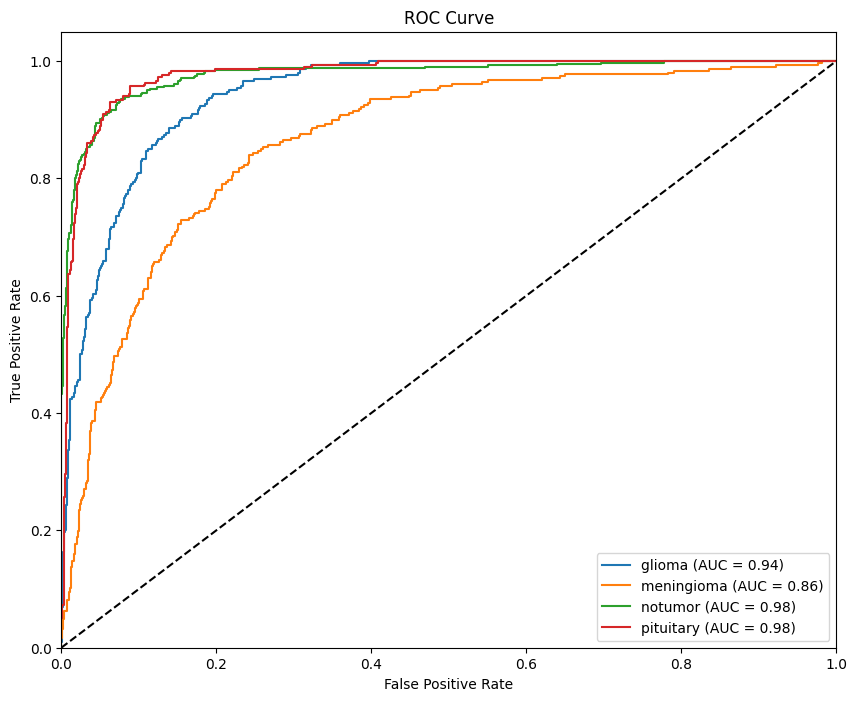


=== Test Set Confusion Matrix ===


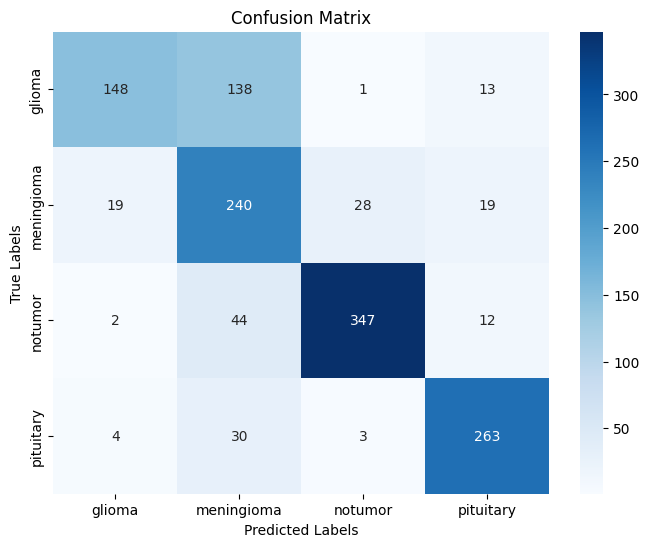

Weighted Precision: 0.7986
Weighted Recall: 0.7613
Macro Average AUC: 0.9404


In [ ]:
# Trial 12: Use Relu, LeakyRelu, and tanh activation functions

# Evaluate on Test Set
print("\n=== Test Set Performance ===")

# Evaluate on test set
y_pred_prob_test, y_pred_test = evaluate_model(model, X_test, y_test, classes)

# Plot ROC curve for test set
plot_roc_auc(y_test, y_pred_prob_test, classes)

# Plot confusion matrix for the test set
print("\n=== Test Set Confusion Matrix ===")
y_pred_test_classes = np.argmax(y_pred_prob_test, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
plot_confusion_matrix(y_test_classes, y_pred_test_classes, classes)

# Calculate weighted precision and recall
weighted_precision = precision_score(y_test_classes, y_pred_test_classes, average='weighted')
weighted_recall = recall_score(y_test_classes, y_pred_test_classes, average='weighted')

print(f"Weighted Precision: {weighted_precision:.4f}")
print(f"Weighted Recall: {weighted_recall:.4f}")

# Calculate macro average AUC
auc_macro = roc_auc_score(
    label_binarize(np.argmax(y_test, axis=1), classes=np.arange(len(classes))),
    y_pred_prob_test,
    average='macro',
    multi_class='ovr'
)
print(f"Macro Average AUC: {auc_macro:.4f}")


Training with batch size 32

Epoch 1/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.4628 - loss: 1.1408 - val_accuracy: 0.6667 - val_loss: 0.8247
Epoch 2/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7229 - loss: 0.7216 - val_accuracy: 0.7218 - val_loss: 0.7355
Epoch 3/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7745 - loss: 0.5903 - val_accuracy: 0.7480 - val_loss: 0.6597
Epoch 4/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8129 - loss: 0.4984 - val_accuracy: 0.7507 - val_loss: 0.6553
Epoch 5/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8393 - loss: 0.4373 - val_accuracy: 0.7717 - val_loss: 0.6228
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7757 - loss: 0.5882
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7431 - loss: 0.6315

Training with batch size 64

Epoch 1/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.8453 - loss: 0.3947 - val_accuracy: 0.7944 - val_loss: 0.4950
Epoch 2/5
72/72 ━━━━━━━━━━━

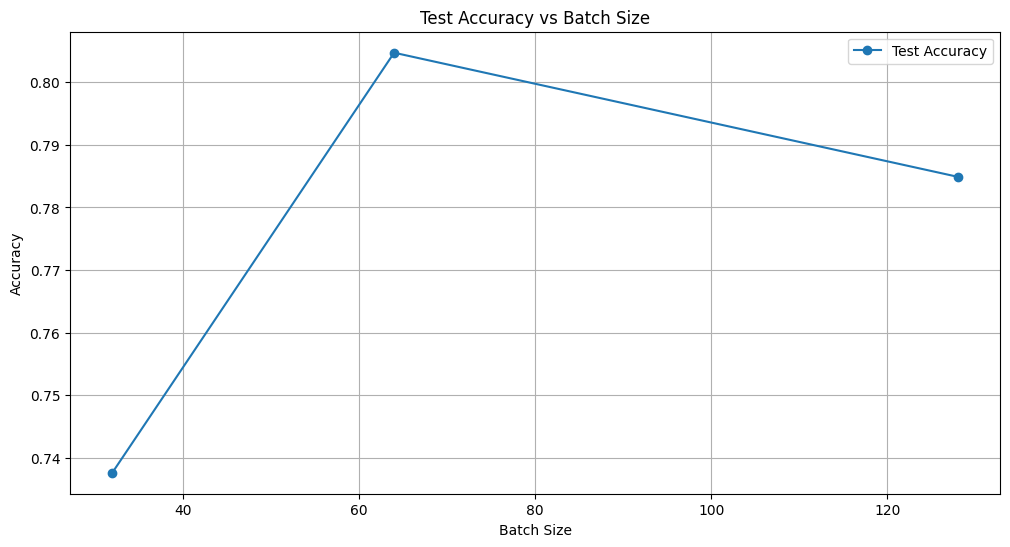


=== Test Set Performance ===
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.88      0.59      0.71       300
  meningioma       0.55      0.82      0.66       306
     notumor       0.91      0.90      0.90       405
   pituitary       0.92      0.77      0.84       300

    accuracy                           0.78      1311
   macro avg       0.81      0.77      0.78      1311
weighted avg       0.82      0.78      0.79      1311

Confusion Matrix:
 [[176 118   1   5]
 [ 15 252  29  10]
 [  1  36 363   5]
 [  7  53   8 232]]
Accuracy: 0.7803
Precision: 0.8209
Recall: 0.7803
F1 Score: 0.7858


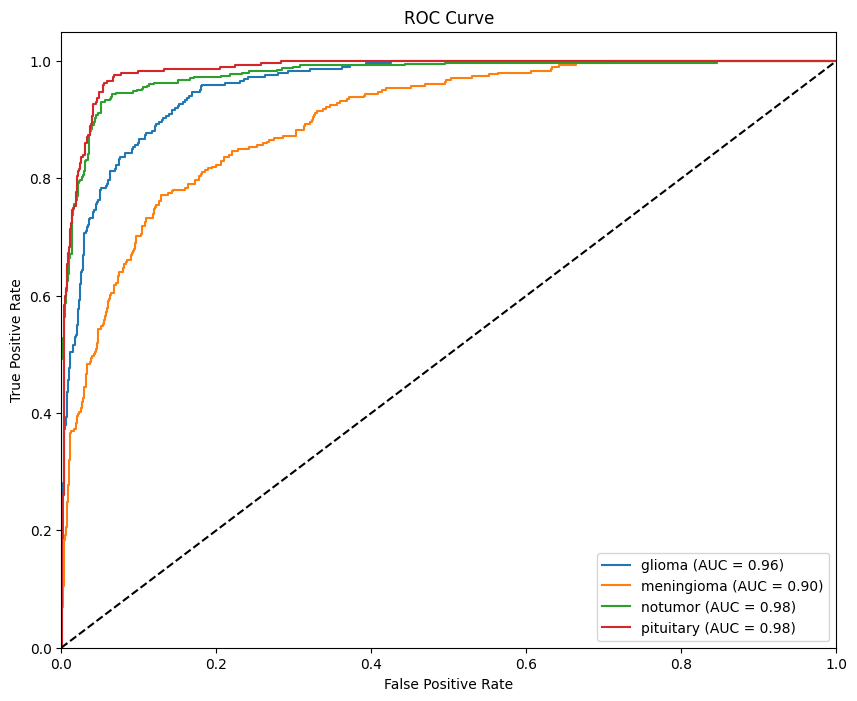

In [ ]:
# Trial 13: Change batch size to 64

# Initialize the Sequential model
model = keras.Sequential()

# Add layers as before
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2d_4', input_shape=(30, 30, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', name='conv2d_5'))
model.add(layers.MaxPooling2D((2, 2), name='max_pooling2d_5'))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2d_6'))
model.add(layers.MaxPooling2D((2, 2), name='max_pooling2d_6'))
model.add(layers.Flatten(name='flatten_2'))
model.add(layers.Dense(32, activation='relu', name='dense_4'))
model.add(layers.Dense(4, activation='softmax', name='dense_5'))

# Compile the model with learning rate decay
initial_learning_rate = 0.001
optimizer = Adam(learning_rate=initial_learning_rate)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with different batch sizes
batch_sizes = [32, 64, 128]  
epochs_per_batch_size = 5  

# Dictionary to store loss and accuracy for each batch size
history_dict = {'batch_size': [], 'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'test_acc': []}

for batch_size in batch_sizes:
    print(f"\nTraining with batch size {batch_size}\n")
    history = model.fit(X_train, y_train,
                        epochs=epochs_per_batch_size,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        verbose=1)

    # Store the final loss and accuracy for each batch size
    history_dict['batch_size'].append(batch_size)
    history_dict['train_loss'].append(history.history['loss'][-1])
    history_dict['val_loss'].append(history.history['val_loss'][-1])
    history_dict['train_acc'].append(history.history['accuracy'][-1])
    history_dict['val_acc'].append(history.history['val_accuracy'][-1])

    # Evaluate on the test set
    val_loss, val_acc = model.evaluate(X_val, y_val)
    test_loss, test_acc = model.evaluate(X_test, y_test)
    history_dict['test_acc'].append(test_acc)  # Store test accuracy

# Plot the test accuracy for different batch sizes
plt.figure(figsize=(12, 6))
plt.plot(history_dict['batch_size'], history_dict['test_acc'], label='Test Accuracy', marker='o')
plt.title('Test Accuracy vs Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


# Evaluate on Test Set
print("\n=== Test Set Performance ===")

X_test, y_test = extract_data_from_generator(test_data)

# Evaluate on test set
y_pred_prob_test, y_pred_test = evaluate_model(model, X_test, y_test, classes)

# Plot ROC curve for test set
plot_roc_auc(y_test, y_pred_prob_test, classes)


=== Test Set Performance ===
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.76      0.76      0.76       300
  meningioma       0.63      0.56      0.59       306
     notumor       0.81      0.91      0.86       405
   pituitary       0.87      0.83      0.85       300

    accuracy                           0.77      1311
   macro avg       0.77      0.76      0.76      1311
weighted avg       0.77      0.77      0.77      1311

Confusion Matrix:
 [[228  62   1   9]
 [ 46 171  72  17]
 [ 10  16 367  12]
 [ 16  21  13 250]]
Accuracy: 0.7750
Precision: 0.7707
Recall: 0.7750
F1 Score: 0.7714


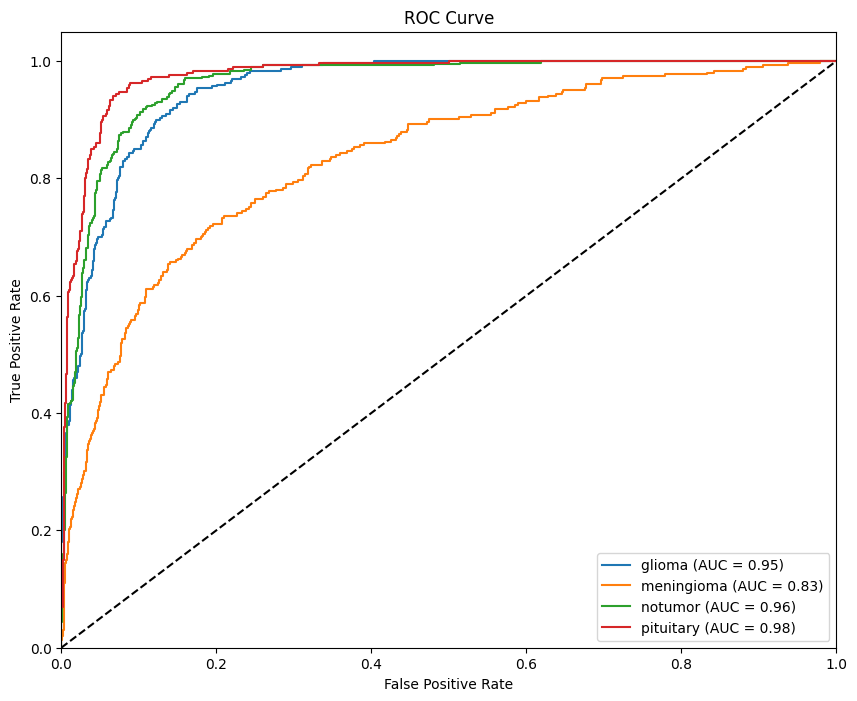


=== Test Set Confusion Matrix ===


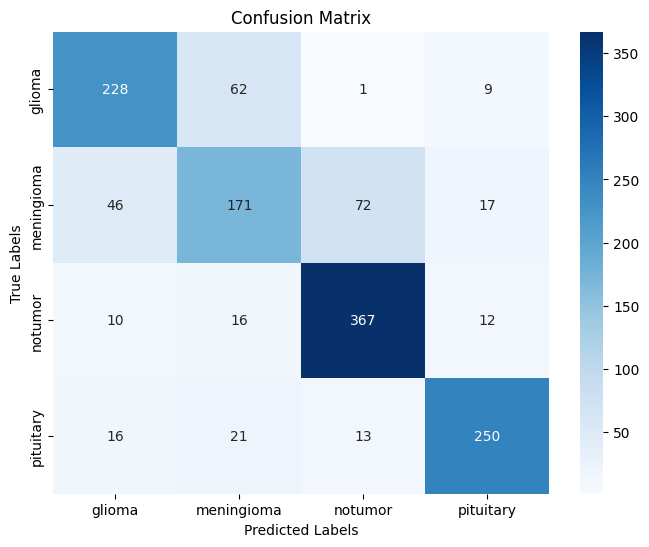

Weighted Precision: 0.7707
Weighted Recall: 0.7750
Macro Average AUC: 0.9315


In [ ]:
# Trial 14: 
# convelutional layers: 3
# activation function: ReLU & tanh
# batch size: 128
# epoch: 50
# L2 regularization
# Early Stopping
# Dropout rate: 0.5
# Learning Rate Decay (Adam)

# Evaluate on Test Set
print("\n=== Test Set Performance ===")

# Evaluate on test set
y_pred_prob_test, y_pred_test = evaluate_model(model, X_test, y_test, classes)

# Plot ROC curve for test set
plot_roc_auc(y_test, y_pred_prob_test, classes)

# Plot confusion matrix for the test set
print("\n=== Test Set Confusion Matrix ===")
y_pred_test_classes = np.argmax(y_pred_prob_test, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
plot_confusion_matrix(y_test_classes, y_pred_test_classes, classes)

# Calculate weighted precision and recall
weighted_precision = precision_score(y_test_classes, y_pred_test_classes, average='weighted')
weighted_recall = recall_score(y_test_classes, y_pred_test_classes, average='weighted')

print(f"Weighted Precision: {weighted_precision:.4f}")
print(f"Weighted Recall: {weighted_recall:.4f}")

# Calculate macro average AUC
auc_macro = roc_auc_score(
    label_binarize(np.argmax(y_test, axis=1), classes=np.arange(len(classes))),
    y_pred_prob_test,
    average='macro',
    multi_class='ovr'
)
print(f"Macro Average AUC: {auc_macro:.4f}")

##### - Method 4: Bayesian

In [ ]:
# Define the optimizer dictionary
optimizer_dict = {
    'Adam': Adam,
    'SGD': SGD,
    'RMSprop': RMSprop
}

# Define the model-building function
def create_model(learning_rate=0.001, filters=32, optimizer_name='Adam', dropout_rate=0.2, kernel_size=(3, 3), activation='relu'):
    model = Sequential()

    # First convolutional layer
    model.add(layers.Conv2D(filters, kernel_size, activation=activation, padding='same', input_shape=(30, 30, 1)))
    model.add(layers.MaxPooling2D((2, 2)))

    # Second convolutional layer
    model.add(layers.Conv2D(filters, kernel_size, activation=activation))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten the layers
    model.add(layers.Flatten())

    # Dropout layer
    model.add(layers.Dropout(dropout_rate))

    # Dense layer
    model.add(layers.Dense(32, activation=activation))

    # Output layer for classification
    model.add(layers.Dense(4, activation='softmax'))

    # Optimizer type
    optimizer_class = optimizer_dict.get(optimizer_name)
    optimizer = optimizer_class(learning_rate=learning_rate)

    # Compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Define the objective function
def objective(params):
    filters, learning_rate, optimizer_name, dropout_rate, epochs = params

    # Use the model-building function with the given parameters
    model = create_model(
        learning_rate=learning_rate,
        filters=filters,
        optimizer_name=optimizer_name,  
        dropout_rate=dropout_rate,  
        kernel_size=(3, 3),  
        activation='relu'  
    )

    # Train the model (using part of the training data for validation)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_val, y_val), verbose=0)

    # Evaluate the model on the validation set
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)

    return -val_accuracy  # Minimize the negative accuracy

# Define the hyperparameter search space, including learning rate
search_space = [
    Integer(32, 128),  # Number of filters
    Real(1e-5, 1e-2, prior='log-uniform'),  # Expanded Learning rate range
    Categorical(['Adam', 'SGD', 'RMSprop']),  # Optimizer type
    Real(0.2, 0.5),  # Dropout rate range
    Integer(5, 15)  # Number of epochs
]

# Perform Bayesian optimization using gp_minimize
result = gp_minimize(
    objective,  
    search_space,  
    n_calls=20,  
    random_state=42,  
    verbose=1
)

# Print the best hyperparameters
print(f"Best hyperparameters: {result.x}")

# Use the best hyperparameters to create the final model
best_filters, best_learning_rate, best_optimizer_name, best_dropout_rate, best_epochs = result.x

best_model = create_model(
    learning_rate=best_learning_rate,
    filters=best_filters,
    optimizer_name=best_optimizer_name,  # Best optimizer from result
    dropout_rate=best_dropout_rate  # Best dropout rate
)

# Train the best model on the full training set
best_model.fit(X_train, y_train, epochs=best_epochs, batch_size=32, verbose=1)

# Evaluate on test set
test_loss, test_accuracy = best_model.evaluate(test_data, verbose=0)
print(f"Test Accuracy: {test_accuracy}")

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 33.2463
Function value obtained: -0.6754
Current minimum: -0.6754
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 15.0623
Function value obtained: -0.2808
Current minimum: -0.6754
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 16.8220
Function value obtained: -0.8434
Current minimum: -0.8434
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 31.0945
Function value obtained: -0.8215
Current minimum: -0.8434
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 14.7565
Function value obtained: -0.3228
Current minimum: -0.8434
Iteration No: 6 star

#### 2.1.2 Resampling 

Epoch 1/10
457/457 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - accuracy: 0.9883 - loss: 0.0377 - val_accuracy: 0.8772 - val_loss: 0.5090
Epoch 2/10
457/457 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.9899 - loss: 0.0289 - val_accuracy: 0.8566 - val_loss: 0.6349
Epoch 3/10
457/457 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.9964 - loss: 0.0126 - val_accuracy: 0.8711 - val_loss: 0.5898

=== Test Set Performance After Oversampling ===
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.86      0.80      0.83       300
  meningioma       0.80      0.80      0.80       306
     notumor       0.93      0.96      0.94       405
   pituitary       0.90      0.93      0.91       300

    accuracy                           0.88      1311
   macro avg       0.87      0.87      0.87      1311
weighted avg       0.88      0.88      0.88      1311

Confusion Matrix:
 [[241  42   3  14]
 [ 25 244  24  13]
 [  5

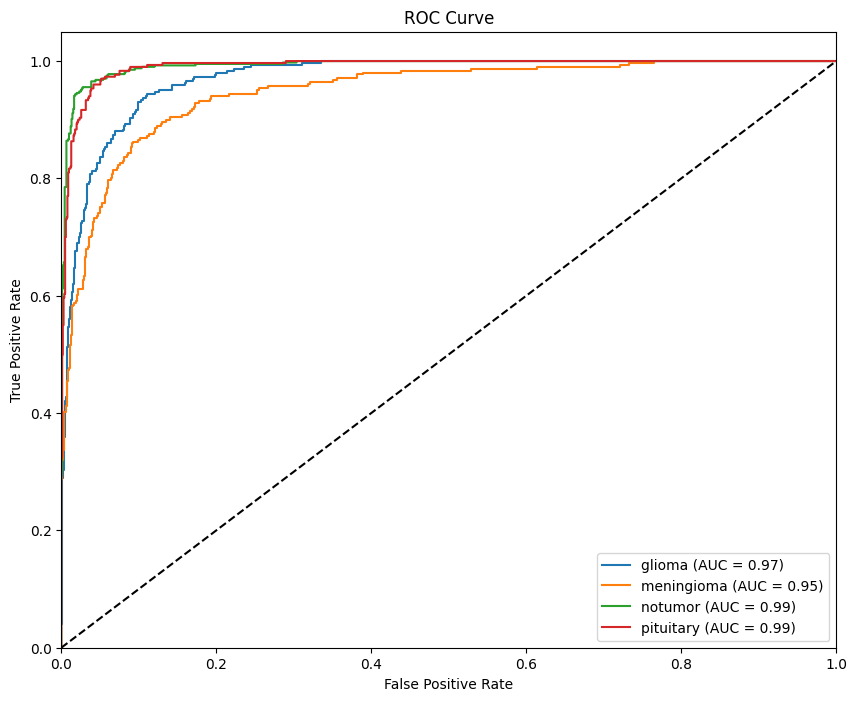

In [ ]:
# Trail1: Oversample meningioma on model_2_improved

# Concatenate training data and labels
X_train_val_combined = np.concatenate((X_train, X_val))
y_train_val_combined = np.concatenate((y_train, y_val))

# Convert labels from one-hot encoding to class indices
y_train_val_combined_classes = np.argmax(y_train_val_combined, axis=1)

# Separate the classes
X_meningioma = X_train_val_combined[y_train_val_combined_classes == 1]
y_meningioma = y_train_val_combined[y_train_val_combined_classes == 1]

# Find the number of observations in the majority class
class_distribution = np.bincount(y_train_val_combined_classes)
max_class_size = class_distribution.max()  # Max size of any class

# Oversample the meningioma class to match the size of the majority class
X_meningioma_oversampled, y_meningioma_oversampled = resample(X_meningioma, y_meningioma,
                                                              replace=True,  
                                                              n_samples=max_class_size,  
                                                              random_state=42)

# Combine oversampled meningioma class back with the rest of the training data
X_train_balanced = np.concatenate([X_train_val_combined, X_meningioma_oversampled])
y_train_balanced = np.concatenate([y_train_val_combined, y_meningioma_oversampled])

# Shuffle the dataset
from sklearn.utils import shuffle
X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_train_balanced, random_state=42)

# Rebuild and retrain model using the balanced dataset
model_2_improved.fit(
    X_train_balanced, y_train_balanced,  # Use oversampled training data
    validation_data=(X_test, y_test),    # Test data as validation data
    epochs=10,                           # Number of epochs
    batch_size=batch_size,               # Batch size
    callbacks=[early_stopping],          # Early stopping
    verbose=1                            # Verbose to show the progress
)

# Evaluate the model again
print("\n=== Test Set Performance After Oversampling ===")
y_pred_prob_test, y_pred_test = evaluate_model(model_2_improved, X_test, y_test, classes)

# Plot ROC curve for test set
plot_roc_auc(y_test, y_pred_prob_test, classes)

Epoch 1/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.9825 - loss: 0.0498 - val_accuracy: 0.8543 - val_loss: 0.5343
Epoch 2/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.9748 - loss: 0.0695 - val_accuracy: 0.8680 - val_loss: 0.5733
Epoch 3/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.9931 - loss: 0.0179 - val_accuracy: 0.8429 - val_loss: 0.7552

=== Test Set Performance After Oversampling ===
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.79      0.84      0.81       300
  meningioma       0.83      0.65      0.73       306
     notumor       0.87      0.99      0.92       405
   pituitary       0.92      0.90      0.91       300

    accuracy                           0.85      1311
   macro avg       0.85      0.84      0.84      1311
weighted avg       0.85      0.85      0.85      1311

Confusion Matrix:
 [[251  33   7   9]
 [ 47 200  47  12]
 [  2

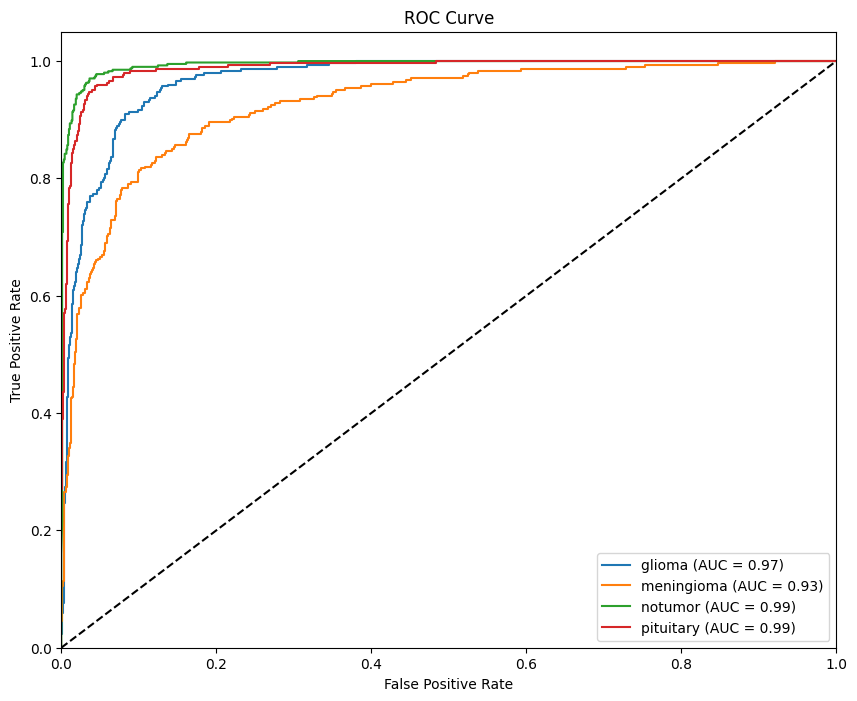

In [ ]:
# Trail2: Oversample on the three minority classes

# Concatenate training and validation data
X_train_val_combined = np.concatenate((X_train, X_val))
y_train_val_combined = np.concatenate((y_train, y_val))

# Convert one-hot encoded labels to class labels
y_train_val_combined_classes = np.argmax(y_train_val_combined, axis=1)

# Separate the classes
X_glioma = X_train_val_combined[y_train_val_combined_classes == 0]  # Class 0: glioma
y_glioma = y_train_val_combined[y_train_val_combined_classes == 0]

X_meningioma = X_train_val_combined[y_train_val_combined_classes == 1]  # Class 1: meningioma
y_meningioma = y_train_val_combined[y_train_val_combined_classes == 1]

X_pituitary = X_train_val_combined[y_train_val_combined_classes == 3]  # Class 3: pituitary
y_pituitary = y_train_val_combined[y_train_val_combined_classes == 3]

# Separate the majority class (no tumor, class 2)
X_no_tumor = X_train_val_combined[y_train_val_combined_classes == 2]
y_no_tumor = y_train_val_combined[y_train_val_combined_classes == 2]

# Find the majority class size
majority_class_size = len(X_no_tumor)

# Randomly oversample the minority classes to match the size of the majority class
X_glioma_oversampled, y_glioma_oversampled = resample(X_glioma, y_glioma, 
                                                      replace=True, 
                                                      n_samples=majority_class_size, 
                                                      random_state=42)

X_meningioma_oversampled, y_meningioma_oversampled = resample(X_meningioma, y_meningioma, 
                                                              replace=True, 
                                                              n_samples=majority_class_size, 
                                                              random_state=42)

X_pituitary_oversampled, y_pituitary_oversampled = resample(X_pituitary, y_pituitary, 
                                                            replace=True, 
                                                            n_samples=majority_class_size, 
                                                            random_state=42)

# Combine the oversampled classes and the majority class
X_train_balanced = np.concatenate([X_no_tumor, X_glioma_oversampled, X_meningioma_oversampled, X_pituitary_oversampled])
y_train_balanced = np.concatenate([y_no_tumor, y_glioma_oversampled, y_meningioma_oversampled, y_pituitary_oversampled])

# Shuffle the dataset to avoid any ordering bias
X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_train_balanced, random_state=42)

# Retrain the model using the balanced dataset
model_2_improved.fit(
    X_train_balanced, y_train_balanced,  # Use oversampled training data
    validation_data=(X_test, y_test),    # Use the original test data for validation
    epochs=10,                           # Number of epochs
    batch_size=batch_size,               # Batch size
    callbacks=[early_stopping],          # Early stopping
    verbose=1                            # Verbose to show the progress
)

# Evaluate the model performance after oversampling
print("\n=== Test Set Performance After Oversampling ===")
y_pred_prob_test, y_pred_test = evaluate_model(model_2_improved, X_test, y_test, classes)

# Plot ROC curve for test set
plot_roc_auc(y_test, y_pred_prob_test, classes)

Epoch 1/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9688 - loss: 0.0893 - val_accuracy: 0.8535 - val_loss: 0.6069
Epoch 2/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9839 - loss: 0.0460 - val_accuracy: 0.8337 - val_loss: 0.7615
Epoch 3/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9832 - loss: 0.0535 - val_accuracy: 0.8429 - val_loss: 0.6559

=== Test Set Performance After Undersampling ===
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.86      0.77      0.81       300
  meningioma       0.81      0.77      0.79       306
     notumor       0.98      0.88      0.93       405
   pituitary       0.76      0.99      0.86       300

    accuracy                           0.85      1311
   macro avg       0.85      0.85      0.85      1311
weighted avg       0.86      0.85      0.85      1311

Confusion Matrix:
 [[232  34   0  34]
 [ 28 236   7  35]
 [  

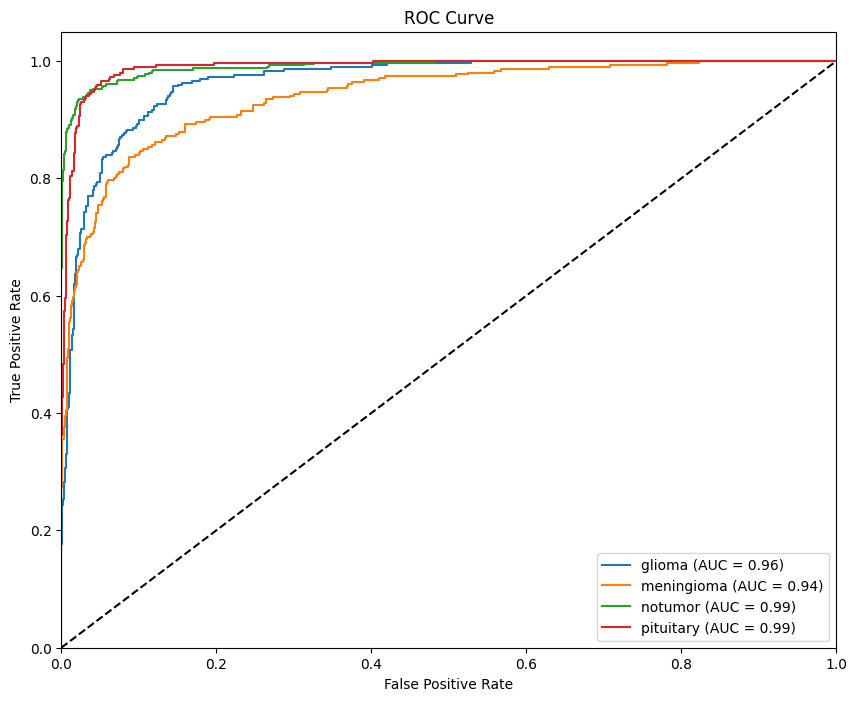

In [ ]:
#Trail 3: Undersample majority class: no tumor class

from sklearn.utils import resample, shuffle

# Concatenate training and validation data
X_train_val_combined = np.concatenate((X_train, X_val))
y_train_val_combined = np.concatenate((y_train, y_val))

# Convert one-hot encoded labels to class labels
y_train_val_combined_classes = np.argmax(y_train_val_combined, axis=1)

# Separate the majority class ("no tumor", class 2) and minority classes
X_no_tumor = X_train_val_combined[y_train_val_combined_classes == 2]  # Class 2: no tumor
y_no_tumor = y_train_val_combined[y_train_val_combined_classes == 2]

X_glioma = X_train_val_combined[y_train_val_combined_classes == 0]  # Class 0: glioma
y_glioma = y_train_val_combined[y_train_val_combined_classes == 0]

X_meningioma = X_train_val_combined[y_train_val_combined_classes == 1]  # Class 1: meningioma
y_meningioma = y_train_val_combined[y_train_val_combined_classes == 1]

X_pituitary = X_train_val_combined[y_train_val_combined_classes == 3]  # Class 3: pituitary
y_pituitary = y_train_val_combined[y_train_val_combined_classes == 3]

# Find the size of the smallest class (minority class)
minority_class_size = min(len(X_glioma), len(X_meningioma), len(X_pituitary))

# Randomly undersample the majority class to match the size of the smallest class
X_no_tumor_undersampled, y_no_tumor_undersampled = resample(X_no_tumor, y_no_tumor,
                                                            replace=False,  # No replacement for undersampling
                                                            n_samples=minority_class_size,  # Match to minority class size
                                                            random_state=42)

# Combine the undersampled majority class with the minority classes
X_train_balanced = np.concatenate([X_no_tumor_undersampled, X_glioma, X_meningioma, X_pituitary])
y_train_balanced = np.concatenate([y_no_tumor_undersampled, y_glioma, y_meningioma, y_pituitary])

# Shuffle the balanced dataset
X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_train_balanced, random_state=42)

# Retrain the model using the balanced dataset
model_2_improved.fit(
    X_train_balanced, y_train_balanced,  # Use undersampled training data
    validation_data=(X_test, y_test),    # Use the original test data for validation
    epochs=10,                           # Number of epochs
    batch_size=batch_size,               # Batch size
    callbacks=[early_stopping],          # Early stopping
    verbose=1                            # Verbose to see the training progress
)

# Evaluate the model performance after undersampling
print("\n=== Test Set Performance After Undersampling ===")
y_pred_prob_test, y_pred_test = evaluate_model(model_2_improved, X_test, y_test, classes)

# Plot ROC curve for test set
plot_roc_auc(y_test, y_pred_prob_test, classes)

Epoch 1/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.9897 - loss: 0.0321 - val_accuracy: 0.8673 - val_loss: 0.5502
Epoch 2/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.9940 - loss: 0.0204 - val_accuracy: 0.8490 - val_loss: 0.6508
Epoch 3/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.9888 - loss: 0.0280 - val_accuracy: 0.8612 - val_loss: 0.6558

=== Test Set Performance After Undersampling ===
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.90      0.71      0.79       300
  meningioma       0.78      0.79      0.78       306
     notumor       0.92      0.97      0.94       405
   pituitary       0.86      0.97      0.91       300

    accuracy                           0.87      1311
   macro avg       0.86      0.86      0.86      1311
weighted avg       0.87      0.87      0.86      1311

Confusion Matrix:
 [[212  62   5  21]
 [ 17 241  28  20]
 [  

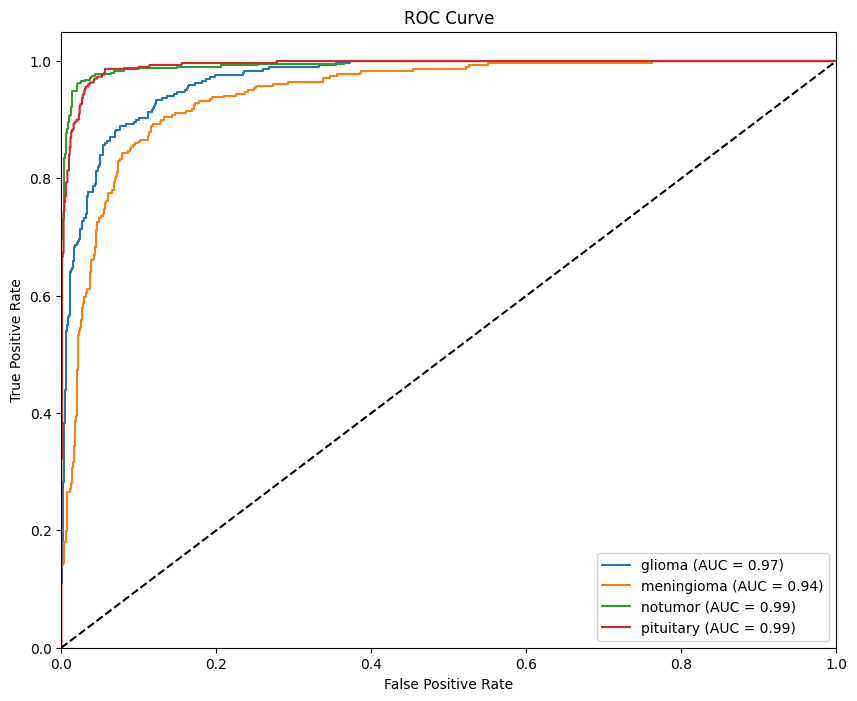

In [ ]:
# Trail 4: Undersample 3 majority classes

# Concatenate training and validation data
X_train_val_combined = np.concatenate((X_train, X_val))
y_train_val_combined = np.concatenate((y_train, y_val))

# Convert one-hot encoded labels to class labels
y_train_val_combined_classes = np.argmax(y_train_val_combined, axis=1)

# Separate the classes
X_glioma = X_train_val_combined[y_train_val_combined_classes == 0]  # Class 0: glioma (no undersampling)
y_glioma = y_train_val_combined[y_train_val_combined_classes == 0]

X_meningioma = X_train_val_combined[y_train_val_combined_classes == 1]  # Class 1: meningioma
y_meningioma = y_train_val_combined[y_train_val_combined_classes == 1]

X_no_tumor = X_train_val_combined[y_train_val_combined_classes == 2]  # Class 2: no tumor
y_no_tumor = y_train_val_combined[y_train_val_combined_classes == 2]

X_pituitary = X_train_val_combined[y_train_val_combined_classes == 3]  # Class 3: pituitary
y_pituitary = y_train_val_combined[y_train_val_combined_classes == 3]

# Find the size of the smallest class among meningioma, no tumor, and pituitary
smallest_class_size = min(len(X_meningioma), len(X_no_tumor), len(X_pituitary))

# Randomly undersample the three majority classes to match the size of the smallest class
X_meningioma_undersampled, y_meningioma_undersampled = resample(X_meningioma, y_meningioma,
                                                                replace=False,  # No replacement for undersampling
                                                                n_samples=smallest_class_size,  # Match to smallest class
                                                                random_state=42)

X_no_tumor_undersampled, y_no_tumor_undersampled = resample(X_no_tumor, y_no_tumor,
                                                            replace=False,
                                                            n_samples=smallest_class_size,
                                                            random_state=42)

X_pituitary_undersampled, y_pituitary_undersampled = resample(X_pituitary, y_pituitary,
                                                              replace=False,
                                                              n_samples=smallest_class_size,
                                                              random_state=42)

# Combine the undersampled classes with the glioma class (which is not undersampled)
X_train_balanced = np.concatenate([X_glioma, X_meningioma_undersampled, X_no_tumor_undersampled, X_pituitary_undersampled])
y_train_balanced = np.concatenate([y_glioma, y_meningioma_undersampled, y_no_tumor_undersampled, y_pituitary_undersampled])

# Shuffle the dataset to avoid any ordering bias
X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_train_balanced, random_state=42)

# Retrain the model using the balanced dataset
model_2_improved.fit(
    X_train_balanced, y_train_balanced,  # Use undersampled training data
    validation_data=(X_test, y_test),    # Use the original test data for validation
    epochs=10,                           # Number of epochs
    batch_size=batch_size,               # Batch size
    callbacks=[early_stopping],          # Early stopping
    verbose=1                            # Verbose to see the training progress
)

# Evaluate the model performance after undersampling
print("\n=== Test Set Performance After Undersampling ===")
y_pred_prob_test, y_pred_test = evaluate_model(model_2_improved, X_test, y_test, classes)

# Plot ROC curve for test set
plot_roc_auc(y_test, y_pred_prob_test, classes)

Epoch 1/10
524/524 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - accuracy: 0.9896 - loss: 0.0309 - val_accuracy: 0.8711 - val_loss: 0.5546
Epoch 2/10
524/524 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.9936 - loss: 0.0221 - val_accuracy: 0.8734 - val_loss: 0.5316
Epoch 3/10
524/524 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - accuracy: 0.9987 - loss: 0.0066 - val_accuracy: 0.8696 - val_loss: 0.6066

=== Test Set Performance After Oversampling ===
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.80      0.85      0.82       300
  meningioma       0.83      0.71      0.77       306
     notumor       0.95      0.95      0.95       405
   pituitary       0.87      0.95      0.91       300

    accuracy                           0.87      1311
   macro avg       0.86      0.87      0.86      1311
weighted avg       0.87      0.87      0.87      1311

Confusion Matrix:
 [[255  31   0  14]
 [ 49 217  19  21]
 [  6

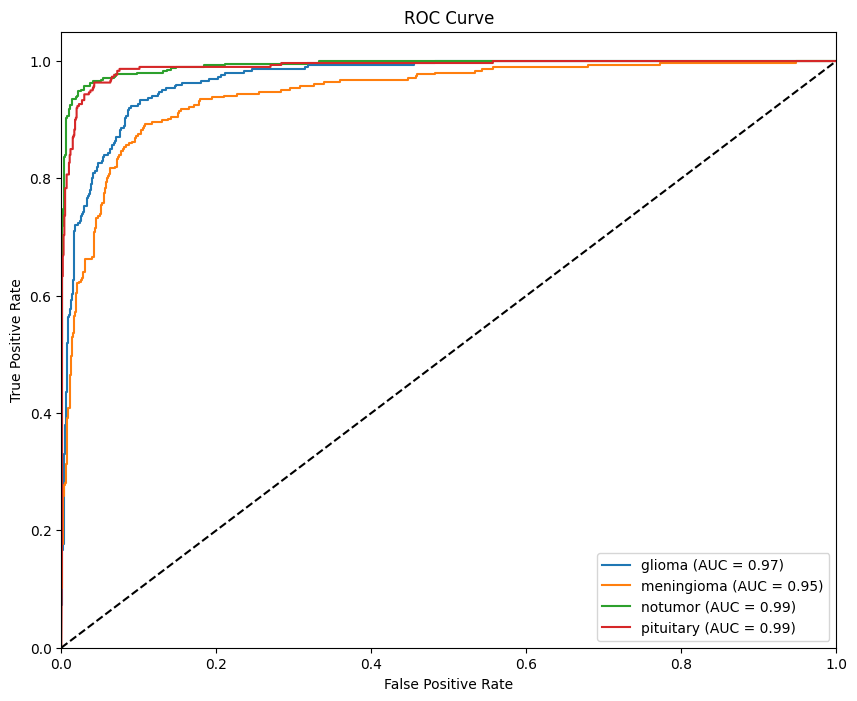

In [ ]:
# Trail 5: Double glioma and meningioma

# Concatenate training and validation data
X_train_val_combined = np.concatenate((X_train, X_val))
y_train_val_combined = np.concatenate((y_train, y_val))

# Convert one-hot encoded labels to class labels
y_train_val_combined_classes = np.argmax(y_train_val_combined, axis=1)

# Separate the classes
X_glioma = X_train_val_combined[y_train_val_combined_classes == 0]  # Class 0: glioma
y_glioma = y_train_val_combined[y_train_val_combined_classes == 0]

X_meningioma = X_train_val_combined[y_train_val_combined_classes == 1]  # Class 1: meningioma
y_meningioma = y_train_val_combined[y_train_val_combined_classes == 1]

X_no_tumor = X_train_val_combined[y_train_val_combined_classes == 2]  # Class 2: no tumor
y_no_tumor = y_train_val_combined[y_train_val_combined_classes == 2]

X_pituitary = X_train_val_combined[y_train_val_combined_classes == 3]  # Class 3: pituitary
y_pituitary = y_train_val_combined[y_train_val_combined_classes == 3]

# Double the size of the glioma and meningioma classes
X_glioma_oversampled, y_glioma_oversampled = resample(X_glioma, y_glioma,
                                                      replace=True,  # Oversample with replacement
                                                      n_samples=len(X_glioma) * 2,  # Double the size of glioma
                                                      random_state=42)

X_meningioma_oversampled, y_meningioma_oversampled = resample(X_meningioma, y_meningioma,
                                                              replace=True,  # Oversample with replacement
                                                              n_samples=len(X_meningioma) * 2,  # Double the size of meningioma
                                                              random_state=42)

# Combine the oversampled classes with the no tumor and pituitary classes (no oversampling for these classes)
X_train_balanced = np.concatenate([X_glioma_oversampled, X_meningioma_oversampled, X_no_tumor, X_pituitary])
y_train_balanced = np.concatenate([y_glioma_oversampled, y_meningioma_oversampled, y_no_tumor, y_pituitary])

# Shuffle the dataset to avoid any ordering bias
X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_train_balanced, random_state=42)

# Retrain the model using the balanced dataset
model_2_improved.fit(
    X_train_balanced, y_train_balanced,  # Use oversampled training data
    validation_data=(X_test, y_test),    # Use the original test data for validation
    epochs=10,                           # Number of epochs
    batch_size=batch_size,               # Batch size
    callbacks=[early_stopping],          # Early stopping
    verbose=1                            # Verbose to see the training progress
)

# Evaluate the model performance after oversampling
print("\n=== Test Set Performance After Oversampling ===")
y_pred_prob_test, y_pred_test = evaluate_model(model_2_improved, X_test, y_test, classes)

# Plot ROC curve for test set
plot_roc_auc(y_test, y_pred_prob_test, classes)

#### 2.1.3 Class Weights

In [ ]:
# Trial 1: class weights   -doesn't perform well, similar while with weights a bit worse

# Compute class weights
y_train_final_classes = np.argmax(y_train_final, axis=1)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_final_classes), y=y_train_final_classes)
class_weights_dict = dict(enumerate(class_weights))

# Print class weights
print("Class weights:", class_weights_dict)

# Compile and train the model with class weights
model_2_improved.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train with class weights
model_2_improved.fit(
    X_train_final, y_train_final,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=batch_size,
    callbacks=[early_stopping],
    class_weight=class_weights_dict,
    verbose=1
)

# Predict class labels
y_pred_test_with_weights = np.argmax(model_2_improved.predict(X_test), axis=1)

# Calculate precision, recall, and accuracy with class weights
precision_with_weights = precision_score(y_test_classes, y_pred_test_with_weights, average='weighted')
recall_with_weights = recall_score(y_test_classes, y_pred_test_with_weights, average='weighted')
accuracy_with_weights = np.mean(y_pred_test_with_weights == y_test_classes)

print(f"Precision with class weights: {precision_with_weights:.4f}")
print(f"Recall with class weights: {recall_with_weights:.4f}")
print(f"Accuracy with class weights: {accuracy_with_weights:.4f}")

Class weights: {0: 1.080999242997729, 1: 1.0664675130694548, 2: 0.8952978056426333, 3: 0.9800960878517502}
Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - accuracy: 0.9440 - loss: 0.1535 - val_accuracy: 0.8513 - val_loss: 0.4366
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.9721 - loss: 0.0847 - val_accuracy: 0.8223 - val_loss: 0.7132
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.9705 - loss: 0.0941 - val_accuracy: 0.8246 - val_loss: 0.7039
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Precision with class weights: 0.8540
Recall with class weights: 0.8513
Accuracy with class weights: 0.8513


In [ ]:
#Performance comparison

print("=== Performance Comparison ===")
print(f"Precision without class weights: {precision_no_weights:.4f}")
print(f"Precision with class weights:    {precision_with_weights:.4f}")
print(f"Recall without class weights:    {recall_no_weights:.4f}")
print(f"Recall with class weights:       {recall_with_weights:.4f}")
print(f"Accuracy without class weights:  {accuracy_no_weights:.4f}")
print(f"Accuracy with class weights:     {accuracy_with_weights:.4f}")

=== Performance Comparison ===
Precision without class weights: 0.8555
Precision with class weights:    0.8540
Recall without class weights:    0.8551
Recall with class weights:       0.8513
Accuracy without class weights:  0.8551
Accuracy with class weights:     0.8513



=== Test Set Performance ===
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.78      0.77      0.78       300
  meningioma       0.67      0.67      0.67       306
     notumor       0.93      0.85      0.89       405
   pituitary       0.82      0.93      0.88       300

    accuracy                           0.81      1311
   macro avg       0.80      0.81      0.80      1311
weighted avg       0.81      0.81      0.81      1311

Confusion Matrix:
 [[231  56   0  13]
 [ 47 206  24  29]
 [ 10  32 345  18]
 [  7  13   0 280]]
Accuracy: 0.8101
Precision: 0.8131
Recall: 0.8101
F1-Score: 0.8102


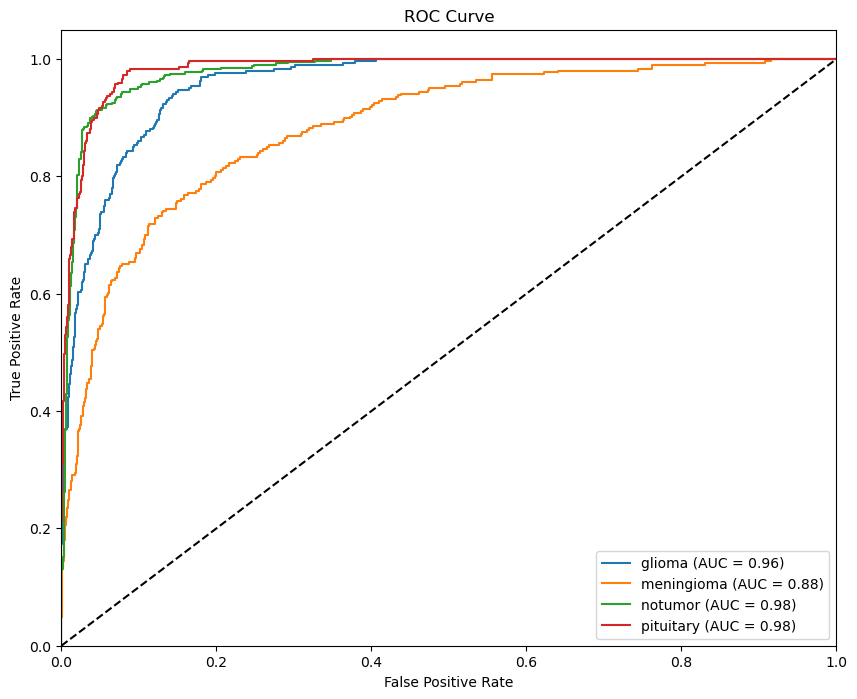

In [ ]:
# Trial 2: Penalizing majority + oversample
#This model is trained on hyperparameter: {'filters_0': 171, 'kernel_size_0': 3, 'filters_1': 124, 'kernel_size_1': 3, 'filters_2': 231, 'kernel_size_2': 5, 'filters_3': 183, 'kernel_size_3': 3, 'dropout_rate': 0.04055175925029486, 'units_dense': 162, 'learning_rate': 0.00031907383956506684, 'batch_size': 16}
#In Part2, we will not include codes related to training models.

# Evaluate on Test Set
print("\n=== Test Set Performance ===")
# Evaluate on test set
y_pred_prob_test, y_pred_test = evaluate_model(model, X_test, y_test, classes)
# Plot ROC curve for test set
plot_roc_auc(y_test, y_pred_prob_test, classes)

#### 2.1.4 Augmentation

In [ ]:
# Define target class index for augmentation and oversampling
target_class_indices = [1]

# Model Creation Function
def create_model(learning_rate=0.001, filters=32, optimizer='Adam', dropout_rate=0.2, kernel_size=(3, 3), activation='relu'):
    model = Sequential()
    model.add(layers.Conv2D(filters, kernel_size, activation=activation, padding='same', input_shape=(30, 30, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(filters, kernel_size, activation=activation))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(32, activation=activation))
    model.add(layers.Dense(4, activation='softmax'))

    if optimizer == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'SGD':
        optimizer = SGD(learning_rate=learning_rate)
    elif optimizer == 'RMSprop':
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Learning Rate Finder
def lr_finder(model, X_train, y_train, initial_lr=1e-5, final_lr=1e-1, num_epochs=20, batch_size=32):
    lrs = []
    losses = []
    lr_schedule = np.logspace(np.log10(initial_lr), np.log10(final_lr), num_epochs)
    
    for lr in lr_schedule:
        model.optimizer.learning_rate.assign(lr)
        history = model.fit(X_train, y_train, epochs=1, batch_size=batch_size, verbose=0)
        lrs.append(lr)
        losses.append(history.history['loss'][0])
        
    return lrs, losses

# K-Fold Hyperparameter Tuning
kfold = KFold(n_splits=3, shuffle=True, random_state=42)
best_accuracy = 0
best_params = {}

param_grid = {
    'filters': [32, 64],
    'batch_size': [16, 32],
    'epochs': [10, 15],
    'optimizer': ['Adam', 'RMSprop'],
    'dropout_rate': [0.2, 0.3, 0.5],
    'kernel_size': [(3, 3), (5, 5)],
    'activation': ['relu', 'elu', 'swish']
}

# Create parameter combinations
param_combinations = [
    (f, batch_size, epochs, optimizer, dropout_rate, kernel_size, activation)
    for f in param_grid['filters']
    for batch_size in param_grid['batch_size']
    for epochs in param_grid['epochs']
    for optimizer in param_grid['optimizer']
    for dropout_rate in param_grid['dropout_rate']
    for kernel_size in param_grid['kernel_size']
    for activation in param_grid['activation']
]

# Randomly select parameter combinations
n_random_combinations = 10
random_combinations = random.sample(param_combinations, n_random_combinations)

# Hyperparameter tuning loop
for f, batch_size, epochs, optimizer, dropout_rate, kernel_size, activation in random_combinations:
    print(f"Training with filters={f}, batch_size={batch_size}, epochs={epochs}, optimizer={optimizer}, dropout_rate={dropout_rate}, kernel_size={kernel_size}, activation={activation}")
    
    fold_accuracies = []
    
    for train_index, val_index in kfold.split(X_train):
        X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]

        # Oversample for specified classes
        X_fold_train, y_fold_train = oversample_classes(X_fold_train, y_fold_train, target_class_indices, multiplier=1.5)

        # Only augment data for class 1
        X_fold_train, y_fold_train = augment_class_data(X_fold_train, y_fold_train, class_index= 1, augment_factor=0)

        # Create a model instance for the learning rate finder
        model = create_model(filters=f, optimizer=optimizer, dropout_rate=dropout_rate, kernel_size=kernel_size, activation=activation)

        # Perform learning rate finder
        lrs, losses = lr_finder(model, X_fold_train, y_fold_train)

        # Determine the best learning rate from the losses
        best_lr = lrs[np.argmin(losses)]

        # Use the best learning rate for training
        model = create_model(learning_rate=best_lr, filters=f, optimizer=optimizer, dropout_rate=dropout_rate, kernel_size=kernel_size, activation=activation)

        history = model.fit(X_fold_train, y_fold_train, epochs=epochs, batch_size=batch_size, validation_data=(X_fold_val, y_fold_val), verbose=0)

        val_loss, val_accuracy = model.evaluate(X_fold_val, y_fold_val, verbose=0)
        fold_accuracies.append(val_accuracy)

    mean_val_accuracy = np.mean(fold_accuracies)
    print(f"Mean Validation Accuracy: {mean_val_accuracy}")

    if mean_val_accuracy > best_accuracy:
        best_accuracy = mean_val_accuracy
        best_params = {
            'filters': f,
            'learning_rate': best_lr,
            'batch_size': batch_size,
            'epochs': epochs,
            'optimizer': optimizer,
            'dropout_rate': dropout_rate,
            'kernel_size': kernel_size,
            'activation': activation
        }

# Output best hyperparameters
print(f"Best Accuracy: {best_accuracy}")
print(f"Best Parameters: {best_params}")

# Use best parameters to train the final model
best_model = create_model(
    learning_rate=best_params['learning_rate'],
    filters=best_params['filters'],
    optimizer=best_params['optimizer'],
    dropout_rate=best_params['dropout_rate'],
    kernel_size=best_params['kernel_size'],
    activation=best_params['activation']
)

best_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1)

# Evaluate model performance on the test set
test_loss, test_accuracy = best_model.evaluate(test_data, verbose=0)
print(f"Test Accuracy: {test_accuracy}")

# Make predictions on the test set
y_pred = best_model.predict(test_data)

# Convert predictions and true labels to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(test_labels, axis=1)

# Generate classification report
report = classification_report(y_true_classes, y_pred_classes)
print("Classification Report:\n", report)

# Calculate and display class-wise accuracy
class_labels = np.unique(y_true_classes)
class_accuracies = {}

for label in class_labels:
    label_indices = np.where(y_true_classes == label)[0]
    class_accuracy = accuracy_score(y_true_classes[label_indices], y_pred_classes[label_indices])
    class_accuracies[label] = class_accuracy

print("\nClass-wise Accuracy:")
for label, accuracy in class_accuracies.items():
    print(f"Class {label}: {accuracy:.4f}")

# Print test accuracy
print(f"Test Accuracy: {test_accuracy}")

Training with filters=32, batch_size=32, epochs=10, optimizer=Adam, dropout_rate=0.3, kernel_size=(3, 3), activation=elu
Mean Validation Accuracy: 0.76471875111262
Training with filters=32, batch_size=16, epochs=15, optimizer=RMSprop, dropout_rate=0.2, kernel_size=(3, 3), activation=relu
Mean Validation Accuracy: 0.7833223938941956
Training with filters=32, batch_size=32, epochs=10, optimizer=Adam, dropout_rate=0.5, kernel_size=(3, 3), activation=relu
Mean Validation Accuracy: 0.7739111383756002
Training with filters=64, batch_size=32, epochs=10, optimizer=Adam, dropout_rate=0.5, kernel_size=(3, 3), activation=swish
Mean Validation Accuracy: 0.7811337312062582
Training with filters=64, batch_size=32, epochs=10, optimizer=RMSprop, dropout_rate=0.2, kernel_size=(5, 5), activation=elu
Mean Validation Accuracy: 0.7553075154622396
Training with filters=64, batch_size=16, epochs=10, optimizer=Adam, dropout_rate=0.5, kernel_size=(5, 5), activation=elu
Mean Validation Accuracy: 0.7728168169657

### **2.2 Transfer Learning**

#### **2.2.1 VGG16**

##### - PlanA: directly resize image

Epoch 1/10
143/143 [==============================] - 85s 576ms/step - loss: 1.2669 - accuracy: 0.4196 - val_loss: 1.1097 - val_accuracy: 0.5258
Epoch 2/10
143/143 [==============================] - 82s 573ms/step - loss: 1.1224 - accuracy: 0.5040 - val_loss: 1.0555 - val_accuracy: 0.5459
Epoch 3/10
143/143 [==============================] - 78s 550ms/step - loss: 1.0829 - accuracy: 0.5244 - val_loss: 1.0346 - val_accuracy: 0.5477
Epoch 4/10
143/143 [==============================] - 76s 534ms/step - loss: 1.0458 - accuracy: 0.5465 - val_loss: 1.0319 - val_accuracy: 0.5442
Epoch 5/10
143/143 [==============================] - 78s 548ms/step - loss: 1.0379 - accuracy: 0.5564 - val_loss: 1.0143 - val_accuracy: 0.5792
Epoch 6/10
143/143 [==============================] - 79s 552ms/step - loss: 1.0094 - accuracy: 0.5634 - val_loss: 1.0000 - val_accuracy: 0.5547
Epoch 7/10
143/143 [==============================] - 78s 550ms/step - loss: 1.0000 - accuracy: 0.5750 - val_loss: 0.9923 - val_ac

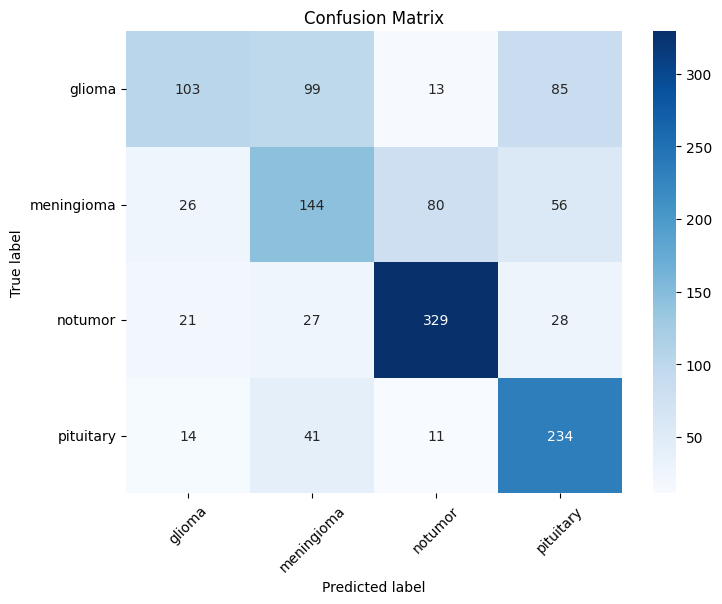

In [ ]:
# 32*32*3 trial 1:
#  - First dense layer: 128 neurons, ReLU activation
#  - First dropout layer: dropout rate 0.5
#  - Output dense layer: 4 neurons, softmax activation

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze all layers until fully connected layers
for layer in base_model.layers:
    layer.trainable = False

# Initialize the Sequential model
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))

# Compile the model with learning rate decay
initial_learning_rate = 0.001
optimizer = Adam(learning_rate=initial_learning_rate)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(train_images_rgb, y_train, epochs=10, validation_data=(X_val_rgb, y_val), callbacks=[early_stopping])

# Evaluate the model on the test set
test_images, test_labels = extract_data_from_generator(test_data)
test_images_rgb = convert_to_rgb(test_images)

test_loss, test_acc = model.evaluate(test_images_rgb, test_labels)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

# Make predictions on the test set
y_pred = model.predict(test_images_rgb)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(test_labels, axis=1)

# Generate classification report
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print(classification_report(y_true_classes, y_pred_classes, target_names=list(train_data.class_indices.keys())))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues,
            xticklabels=list(train_data.class_indices.keys()),
            yticklabels=list(train_data.class_indices.keys()))
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

Data directory: /content/drive/MyDrive/DeepLearning/archive
Training directory: /content/drive/MyDrive/DeepLearning/archive/Training
Testing directory: /content/drive/MyDrive/DeepLearning/archive/Testing
Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Data loading completed successfully.
Number of training samples: 5712
Number of test samples: 1311
Class names: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Training data shape: (4569, 32, 32, 1), Training labels shape: (4569, 4)
Validation data shape: (1143, 32, 32, 1), Validation labels shape: (1143, 4)
Train images RGB shape: (4569, 32, 32, 3)
Validation images RGB shape: (1143, 32, 32, 3)
Applying SMOTE to balance the training data...
After SMOTE, training data shape: (5088, 32, 32, 3), Training labels shape: (5088, 4)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Funct

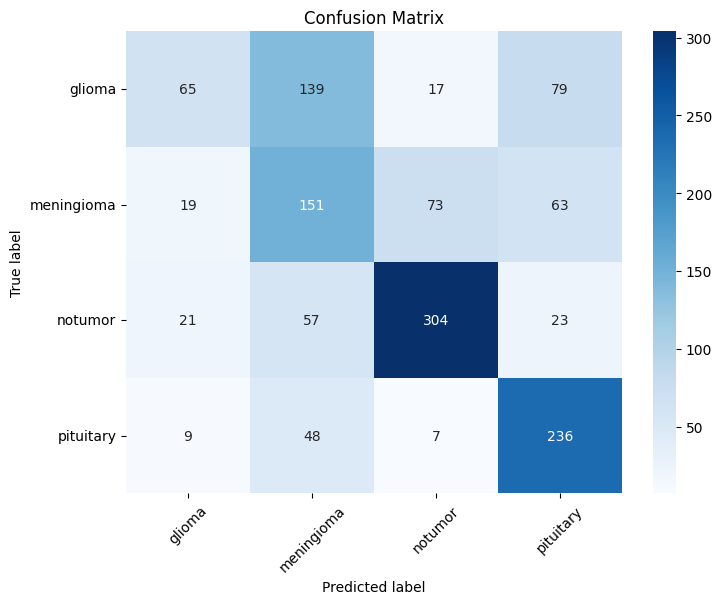

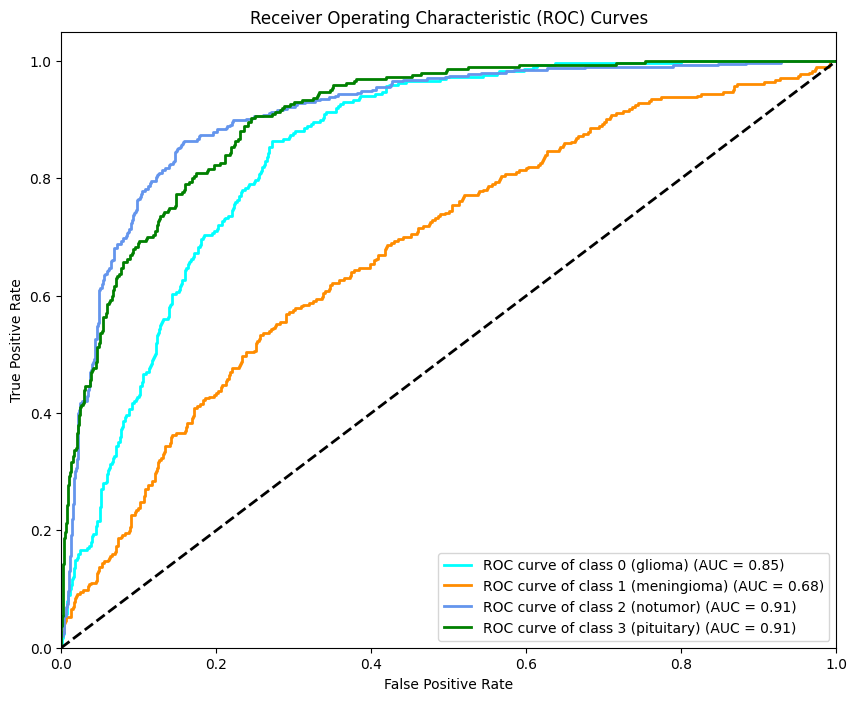

Macro AUC: 0.8363464603697078
Micro AUC: 0.8411838415503933


In [ ]:
# 32*32*3 trial 2:

# Define the hyperparameters
hyperparameters = {
    'learning_rate': 0.001,
    'batch_size': 32,
    'epochs': 20,
    'dropout_rate': 0.5,
    'dense_units_1': 128,
    'dense_units_2': 64,
    'dense_units_3': 32,
    'patience': 3,
    'weight_decay': 0.001
}

#Preprocessing steps
def get_images(train_dir: str, test_dir: str):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        preprocessing_function=add_noise,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    test_datagen = ImageDataGenerator(
        rescale=1./255,
        preprocessing_function=add_noise
    )

    img_height, img_width = image_res, image_res
    batch_size = hyperparameters['batch_size']

    train_data = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        color_mode='grayscale'
    )

    test_data = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        color_mode='grayscale'
    )

    return train_data, test_data

train_data, test_data = get_images(train_images_dir, test_images_dir)
print("Data loading completed successfully.")
print(f"Number of training samples: {train_data.samples}")
print(f"Number of test samples: {test_data.samples}")
print(f"Class names: {train_data.class_indices}")

#Split train set into train set and validation set
def extract_data_from_generator(data_generator):
    images, labels = [], []
    steps = len(data_generator)
    for _ in range(steps):
        batch_images, batch_labels = next(data_generator)
        images.append(batch_images)
        labels.append(batch_labels)
    images = np.concatenate(images)
    labels = np.concatenate(labels)
    return images, labels

train_images, train_labels = extract_data_from_generator(train_data)

X_train, X_val, y_train, y_val = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42, shuffle=True
)

print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Validation labels shape: {y_val.shape}")

#Convert grayscale to RGB
def convert_to_rgb(images):
    return np.repeat(images, 3, axis=-1)

train_images_rgb = convert_to_rgb(X_train)
X_val_rgb = convert_to_rgb(X_val)

print(f"Train images RGB shape: {train_images_rgb.shape}")
print(f"Validation images RGB shape: {X_val_rgb.shape}")

X_train_flat = train_images_rgb.reshape(train_images_rgb.shape[0], -1)
y_train_flat = y_train.argmax(axis=1)

print("Applying SMOTE to balance the training data...")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_flat, y_train_flat)

X_train_smote = X_train_smote.reshape(-1, image_res, image_res, 3)
y_train_smote = tf.keras.utils.to_categorical(y_train_smote, num_classes=4)

print(f"After SMOTE, training data shape: {X_train_smote.shape}, Training labels shape: {y_train_smote.shape}")

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_res, image_res, 3))

# Freeze all layers until fully connected layers
for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(
    hyperparameters['dense_units_1'],
    activation='relu',
    kernel_regularizer=regularizers.l2(hyperparameters['weight_decay'])
))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(hyperparameters['dropout_rate']))
model.add(layers.Dense(
    hyperparameters['dense_units_2'],
    activation='relu',
    kernel_regularizer=regularizers.l2(hyperparameters['weight_decay'])
))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(hyperparameters['dropout_rate']))
model.add(layers.Dense(
    hyperparameters['dense_units_3'],
    activation='relu',
    kernel_regularizer=regularizers.l2(hyperparameters['weight_decay'])
))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(hyperparameters['dropout_rate']))
model.add(layers.Dense(4, activation='softmax'))

optimizer = Adam(learning_rate=hyperparameters['learning_rate'])

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Define an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=hyperparameters['patience'], restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

callbacks = [early_stopping, model_checkpoint, reduce_lr]

print("Starting model training...")
history = model.fit(
    X_train_smote, y_train_smote,
    epochs=hyperparameters['epochs'],
    batch_size=hyperparameters['batch_size'],
    validation_data=(X_val_rgb, y_val),
    callbacks=callbacks
)

test_images, test_labels = extract_data_from_generator(test_data)
test_images_rgb = convert_to_rgb(test_images)

#Evaluation
print("Evaluating model on the test set...")
test_loss, test_acc = model.evaluate(test_images_rgb, test_labels, batch_size=hyperparameters['batch_size'])

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

y_pred = model.predict(test_images_rgb)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(test_labels, axis=1)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=list(train_data.class_indices.keys())))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues,
            xticklabels=list(train_data.class_indices.keys()),
            yticklabels=list(train_data.class_indices.keys()))
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

n_classes = 4
y_true = label_binarize(y_true_classes, classes=range(n_classes))
y_score = y_pred

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} ({list(train_data.class_indices.keys())[i]}) (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

macro_auc = roc_auc_score(y_true, y_score, average='macro', multi_class='ovr')
micro_auc = roc_auc_score(y_true, y_score, average='micro', multi_class='ovr')

print(f"Macro AUC: {macro_auc}")
print(f"Micro AUC: {micro_auc}")


Data directory: /content/drive/MyDrive/DeepLearning/archive
Training directory: /content/drive/MyDrive/DeepLearning/archive/Training
Testing directory: /content/drive/MyDrive/DeepLearning/archive/Testing
Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Data loading completed successfully.
Number of training samples: 5712
Number of test samples: 1311
Class names: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Training data shape: (4569, 64, 64, 1), Training labels shape: (4569, 4)
Validation data shape: (1143, 64, 64, 1), Validation labels shape: (1143, 4)
Train images RGB shape: (4569, 64, 64, 3)
Validation images RGB shape: (1143, 64, 64, 3)
58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/10
143/143 [==============================] - 305s 2s/step - loss: 0.9473 - accuracy: 0.6063 - val_loss: 0.6722 - val_accuracy: 0.7524
Epoch 2/10
143/143 [==============================] - 298s 2s/step - loss: 0.7228 - accuracy

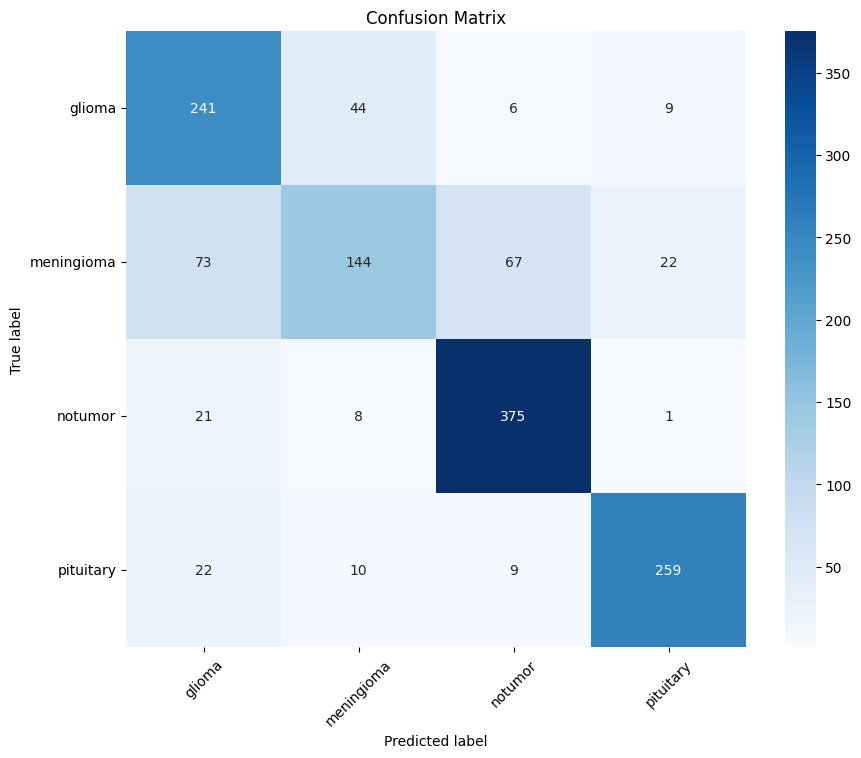

In [ ]:
# 64*64*3 Trail 3: Resize image to (64,64)

print(f"Data directory: {data_dir}")
print(f"Training directory: {train_images_dir}")
print(f"Testing directory: {test_images_dir}")

def add_noise(img):
    std_coeff = 70 * np.random.random()
    noise = np.random.normal(0, std_coeff, img.shape)
    img += noise
    img = np.clip(img, 0., 255.)
    return img

image_res = 64 #Resize

def get_images(train_dir: str, test_dir: str):
    datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=add_noise)

    img_height, img_width = image_res, image_res
    batch_size = 32

    train_data = datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        color_mode='grayscale'
    )

    test_data = datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        color_mode='grayscale'
    )

    return train_data, test_data

train_data, test_data = get_images(train_images_dir, test_images_dir)
print("Data loading completed successfully.")
print(f"Number of training samples: {train_data.samples}")
print(f"Number of test samples: {test_data.samples}")
print(f"Class names: {train_data.class_indices}")

def extract_data_from_generator(data_generator):
    images, labels = [], []
    steps = len(data_generator)
    for _ in range(steps):
        batch_images, batch_labels = next(data_generator)
        images.append(batch_images)
        labels.append(batch_labels)
    images = np.concatenate(images)
    labels = np.concatenate(labels)
    return images, labels

train_images, train_labels = extract_data_from_generator(train_data)

X_train, X_val, y_train, y_val = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42, shuffle=True
)

print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Validation labels shape: {y_val.shape}")

def convert_to_rgb(images):
    return np.repeat(images, 3, axis=-1)

#Convert grayscale to RGB
train_images_rgb = convert_to_rgb(X_train)
X_val_rgb = convert_to_rgb(X_val)

print(f"Train images RGB shape: {train_images_rgb.shape}")
print(f"Validation images RGB shape: {X_val_rgb.shape}")

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
# Freeze all layers until fully connected layers
for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))

initial_learning_rate = 0.001
optimizer = Adam(learning_rate=initial_learning_rate)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Define an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    train_images_rgb, y_train,
    epochs=10,
    validation_data=(X_val_rgb, y_val),
    callbacks=[early_stopping]
)

test_images, test_labels = extract_data_from_generator(test_data)
test_images_rgb = convert_to_rgb(test_images)

test_loss, test_acc = model.evaluate(test_images_rgb, test_labels)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model.predict(test_images_rgb)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(test_labels, axis=1)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

print(classification_report(y_true_classes, y_pred_classes, target_names=list(train_data.class_indices.keys())))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues,
            xticklabels=list(train_data.class_indices.keys()),
            yticklabels=list(train_data.class_indices.keys()))
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

Data directory: /content/drive/MyDrive/DeepLearning/archive
Training directory: /content/drive/MyDrive/DeepLearning/archive/Training
Testing directory: /content/drive/MyDrive/DeepLearning/archive/Testing
Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Data loading completed successfully.
Number of training samples: 5712
Number of test samples: 1311
Class names: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Training data shape: (4569, 96, 96, 1), Training labels shape: (4569, 4)
Validation data shape: (1143, 96, 96, 1), Validation labels shape: (1143, 4)
Train images RGB shape: (4569, 96, 96, 3)
Validation images RGB shape: (1143, 96, 96, 3)
Epoch 1/10
143/143 [==============================] - 687s 5s/step - loss: 0.8584 - accuracy: 0.6503 - val_loss: 0.5541 - val_accuracy: 0.7953
Epoch 2/10
143/143 [==============================] - 686s 5s/step - loss: 0.6451 - accuracy: 0.7483 - val_loss: 0.4851 - val_accuracy: 0.8285
Epoch 3/10
143

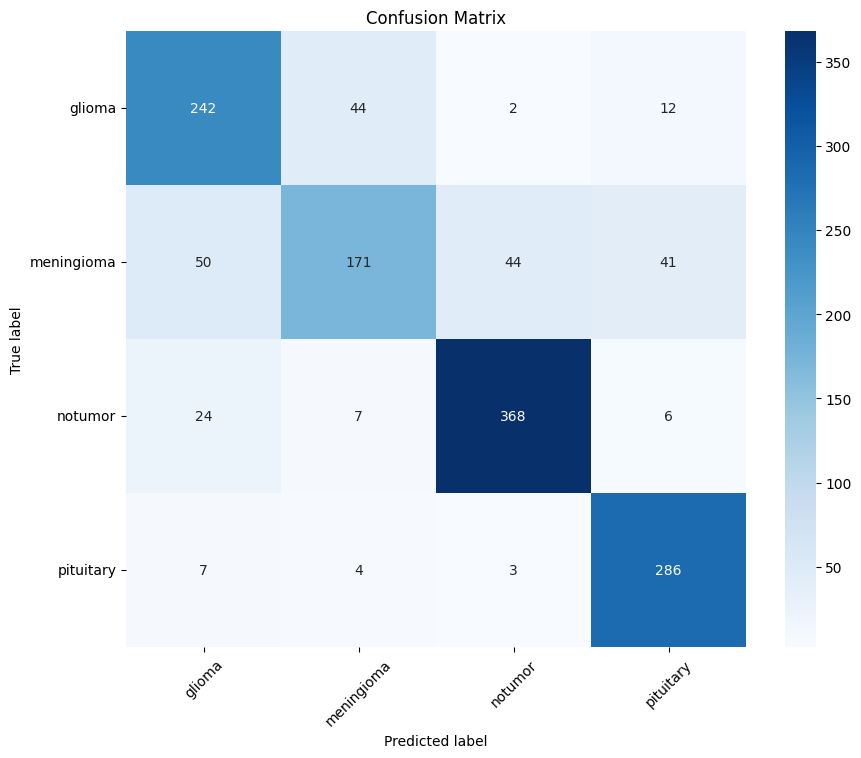

In [ ]:
# 96*96*3 Trail 4: Resize image to (96,96)

print(f"Data directory: {data_dir}")
print(f"Training directory: {train_images_dir}")
print(f"Testing directory: {test_images_dir}")

def add_noise(img):
    std_coeff = 70 * np.random.random()
    noise = np.random.normal(0, std_coeff, img.shape)
    img += noise
    img = np.clip(img, 0., 255.)
    return img

image_res = 96 #Resize

def get_images(train_dir: str, test_dir: str):
    datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=add_noise)

    img_height, img_width = image_res, image_res
    batch_size = 32

    train_data = datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        color_mode='grayscale'
    )

    test_data = datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        color_mode='grayscale'
    )

    return train_data, test_data

train_data, test_data = get_images(train_images_dir, test_images_dir)
print("Data loading completed successfully.")
print(f"Number of training samples: {train_data.samples}")
print(f"Number of test samples: {test_data.samples}")
print(f"Class names: {train_data.class_indices}")

def extract_data_from_generator(data_generator):
    images, labels = [], []
    steps = len(data_generator)
    for _ in range(steps):
        batch_images, batch_labels = next(data_generator)
        images.append(batch_images)
        labels.append(batch_labels)
    images = np.concatenate(images)
    labels = np.concatenate(labels)
    return images, labels

train_images, train_labels = extract_data_from_generator(train_data)

X_train, X_val, y_train, y_val = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42, shuffle=True
)

print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Validation labels shape: {y_val.shape}")

def convert_to_rgb(images):
    return np.repeat(images, 3, axis=-1)

# Freeze all layers until fully connected layers
train_images_rgb = convert_to_rgb(X_train)
X_val_rgb = convert_to_rgb(X_val)

print(f"Train images RGB shape: {train_images_rgb.shape}")
print(f"Validation images RGB shape: {X_val_rgb.shape}")

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# Freeze all layers until fully connected layers
for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))

initial_learning_rate = 0.001
optimizer = Adam(learning_rate=initial_learning_rate)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Define an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    train_images_rgb, y_train,
    epochs=10,
    validation_data=(X_val_rgb, y_val),
    callbacks=[early_stopping]
)

test_images, test_labels = extract_data_from_generator(test_data)
test_images_rgb = convert_to_rgb(test_images)

test_loss, test_acc = model.evaluate(test_images_rgb, test_labels)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model.predict(test_images_rgb)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(test_labels, axis=1)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

print(classification_report(y_true_classes, y_pred_classes, target_names=list(train_data.class_indices.keys())))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues,
            xticklabels=list(train_data.class_indices.keys()),
            yticklabels=list(train_data.class_indices.keys()))
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

##### - PlanB: resize images based on 30\*30\*1

In [ ]:
# Resize the images to 32*32*3

early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True)

history = model.fit(
    X_train_rgb, y_train_resampled,
    validation_data=(X_test_rgb, y_test),
    epochs=13,  
    batch_size=8,  
    callbacks=[early_stopping],
    verbose=1
)

# Step 6: Evaluate Model
test_loss, test_accuracy = model.evaluate(X_test_rgb, y_test)
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")

Epoch 1/13
719/719 [==============================] - 38s 53ms/step - loss: 0.0815 - accuracy: 0.7115 - val_loss: 0.0845 - val_accuracy: 0.7002
Epoch 2/13
719/719 [==============================] - 38s 52ms/step - loss: 0.0778 - accuracy: 0.7222 - val_loss: 0.0889 - val_accuracy: 0.6712
Epoch 3/13
719/719 [==============================] - 44s 61ms/step - loss: 0.0754 - accuracy: 0.7262 - val_loss: 0.0810 - val_accuracy: 0.7010
Epoch 4/13
719/719 [==============================] - 38s 52ms/step - loss: 0.0724 - accuracy: 0.7377 - val_loss: 0.0772 - val_accuracy: 0.7147
Epoch 5/13
719/719 [==============================] - 39s 54ms/step - loss: 0.0700 - accuracy: 0.7398 - val_loss: 0.0813 - val_accuracy: 0.7262
Epoch 6/13
719/719 [==============================] - 39s 54ms/step - loss: 0.0683 - accuracy: 0.7487 - val_loss: 0.0850 - val_accuracy: 0.7010
Epoch 7/13
41/41 [==============================] - 5s 131ms/step - loss: 0.0772 - accuracy: 0.7147
Test Accuracy: 0.7147215604782104
Te

In [ ]:
# resize images to 80*80*3

early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True)

history = model.fit(
    X_train_rgb, y_train_resampled,
    validation_data=(X_test_rgb, y_test),
    epochs=10,  # Use the same number of epochs as model_3
    batch_size=16,  # Batch size from model_3
    callbacks=[early_stopping],
    verbose=1
)

# Step 6: Evaluate Model
test_loss, test_accuracy = model.evaluate(X_test_rgb, y_test)
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")

Epoch 1/10
360/360 [==============================] - 156s 435ms/step - loss: 0.0653 - accuracy: 0.7602 - val_loss: 0.0906 - val_accuracy: 0.6690
Epoch 2/10
360/360 [==============================] - 161s 448ms/step - loss: 0.0643 - accuracy: 0.7576 - val_loss: 0.0838 - val_accuracy: 0.6888
Epoch 3/10
360/360 [==============================] - 165s 459ms/step - loss: 0.0612 - accuracy: 0.7645 - val_loss: 0.0861 - val_accuracy: 0.6880
Epoch 4/10
360/360 [==============================] - 157s 438ms/step - loss: 0.0597 - accuracy: 0.7727 - val_loss: 0.0879 - val_accuracy: 0.6957
Epoch 5/10
360/360 [==============================] - 152s 424ms/step - loss: 0.0582 - accuracy: 0.7783 - val_loss: 0.0837 - val_accuracy: 0.6995
Epoch 6/10
360/360 [==============================] - 151s 421ms/step - loss: 0.0561 - accuracy: 0.7830 - val_loss: 0.0906 - val_accuracy: 0.6720
Epoch 7/10
360/360 [==============================] - 167s 463ms/step - loss: 0.0534 - accuracy: 0.7955 - val_loss: 0.0952 -

#### **2.2.2 ResNet50**

##### - PlanA: directly resize image


=== Test Set Performance ===
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.50      0.54      0.52       300
  meningioma       0.44      0.31      0.37       306
     notumor       0.72      0.48      0.58       405
   pituitary       0.51      0.84      0.64       300

    accuracy                           0.54      1311
   macro avg       0.54      0.55      0.52      1311
weighted avg       0.56      0.54      0.53      1311

Confusion Matrix:
 [[162  58   2  78]
 [ 63  96  65  82]
 [ 82  47 196  80]
 [ 18  19  10 253]]
Accuracy: 0.5393
Precision: 0.5551
Recall: 0.5393
F1-Score: 0.5285


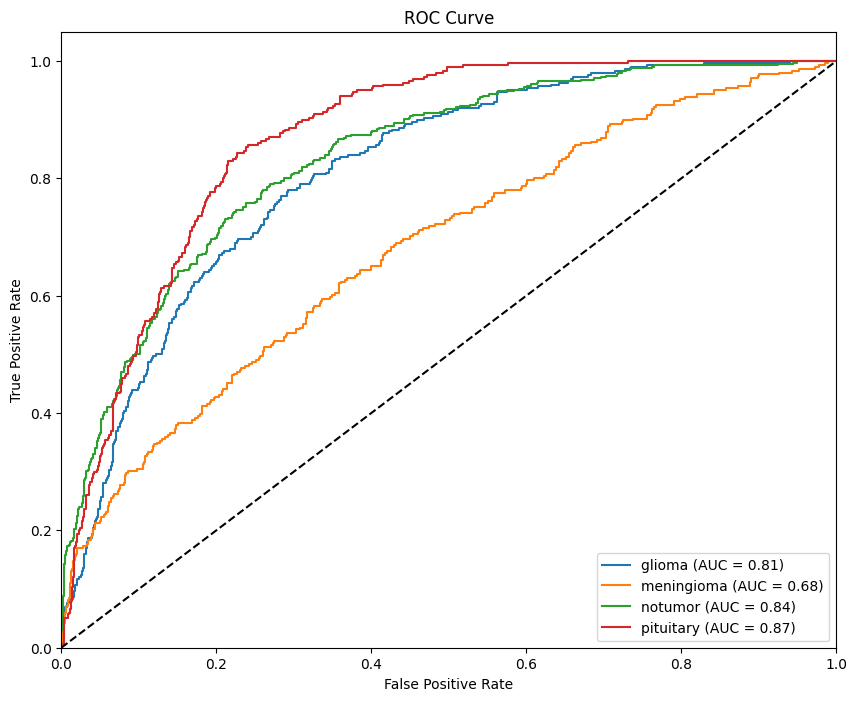

In [ ]:
# Trial 1: Directly change the image into 32*32*3 
#In Part2, we will not include codes related to training models.

# Evaluate on Test Set
print("\n=== Test Set Performance ===")

X_test, y_test = extract_data_from_generator(test_data)

# Evaluate on test set
y_pred_prob_test, y_pred_test = evaluate_model(transfer_model_32, X_test, y_test, classes)

# Plot ROC curve for test set
plot_roc_auc(y_test, y_pred_prob_test, classes)

In [ ]:
# Trial 2: Changing image to (32,32,3) and applied best hyperparameter
# Hyperparameter tuning on 32*32*3 images
    # - Learning rate
    # - Optimizer type
    # - Batch size
    # - Number of dense layers
    # - Dropout rate
    # - Units per layer
    # - Loss function

def objective(trial):
    # Hyperparameters to tune
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    optimizer_type = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    num_dense_layers = trial.suggest_int('num_dense_layers', 1, 5)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)
    units_per_layer = trial.suggest_categorical('units_per_layer', [128, 256, 512])
    loss_type = trial.suggest_categorical('loss', ['categorical_crossentropy', 'focal_loss'])
    
    #Momentum for SGD
    if optimizer_type == 'SGD':
        momentum = trial.suggest_uniform('momentum', 0.5, 0.9)

    # Optimizer type
    if optimizer_type == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_type == 'SGD':
        optimizer = SGD(learning_rate=learning_rate, momentum=momentum)
    elif optimizer_type == 'RMSprop':
        optimizer = RMSprop(learning_rate=learning_rate)

    # Loss function
    if loss_type == 'focal_loss':
        loss = focal_loss(gamma=2., alpha=0.25)
    else:
        loss = CategoricalCrossentropy()

    # ResNet50 base model
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    
    # Freeze all layers until fully connected layers
    for layer in base_model.layers:
        if not isinstance(layer, layers.Dense):
            layer.trainable = False
        else:
            break
    
    # Input and fully connected layers
    input_layer = Input(shape=(32, 32, 3))
    x = base_model(input_layer)
    x = Flatten()(x)
    
    # Add the fully connected layers based on the num_dense_layers hyperparameter
    for i in range(num_dense_layers):
        x = Dense(units_per_layer, activation='relu')(x)
        x = Dropout(dropout_rate)(x)
    
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # Create the model
    model = Model(inputs=input_layer, outputs=predictions)
    
    # Compile the model
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                        epochs=10, batch_size=batch_size, verbose=0)
    
    # Evaluate on validation set
    score = model.evaluate(X_val, y_val, verbose=0)
    return score[1]  # Return validation accuracy

# Run the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Print the best hyperparameters
print(f"Best hyperparameters: {study.best_params}")

[I 2024-09-27 22:37:55,078] A new study created in memory with name: no-name-ce47954b-fcaa-4749-a990-a06c7090d11a
[I 2024-09-27 22:39:26,755] Trial 0 finished with value: 0.48206475377082825 and parameters: {'learning_rate': 0.001101004484368292, 'optimizer': 'RMSprop', 'batch_size': 32, 'num_dense_layers': 1, 'dropout_rate': 0.3429187204875244, 'units_per_layer': 256, 'loss': 'focal_loss'}. Best is trial 0 with value: 0.48206475377082825.
[I 2024-09-27 22:40:59,314] Trial 1 finished with value: 0.45756781101226807 and parameters: {'learning_rate': 7.468615484491381e-05, 'optimizer': 'SGD', 'batch_size': 32, 'num_dense_layers': 2, 'dropout_rate': 0.415360651311901, 'units_per_layer': 512, 'loss': 'categorical_crossentropy', 'momentum': 0.5794553917357715}. Best is trial 0 with value: 0.48206475377082825.
[I 2024-09-27 22:42:31,570] Trial 2 finished with value: 0.47856518626213074 and parameters: {'learning_rate': 0.00016985408578774086, 'optimizer': 'SGD', 'batch_size': 32, 'num_dense_

Best hyperparameters: {'learning_rate': 3.0347044837617356e-05, 'optimizer': 'Adam', 'batch_size': 16, 'num_dense_layers': 3, 'dropout_rate': 0.3043751651864073, 'units_per_layer': 512, 'loss': 'categorical_crossentropy'}



=== Test Set Performance ===
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.58      0.55      0.57       300
  meningioma       0.46      0.30      0.36       306
     notumor       0.63      0.70      0.66       405
   pituitary       0.58      0.73      0.65       300

    accuracy                           0.58      1311
   macro avg       0.56      0.57      0.56      1311
weighted avg       0.57      0.58      0.57      1311

Confusion Matrix:
 [[166  69  18  47]
 [ 52  92 101  61]
 [ 50  24 283  48]
 [ 18  14  49 219]]
Accuracy: 0.5797
Precision: 0.5682
Recall: 0.5797
F1-Score: 0.5674


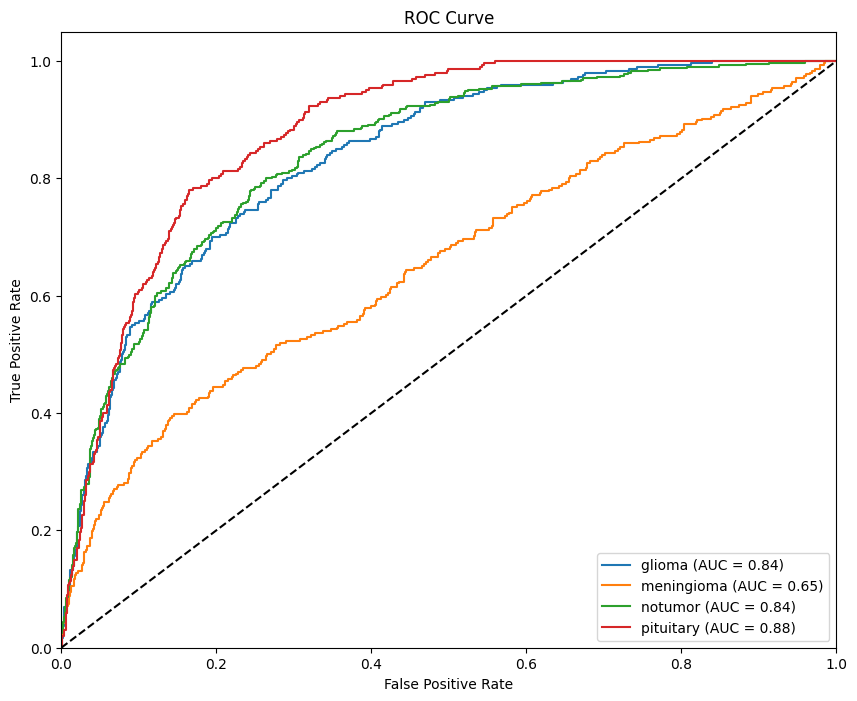

In [ ]:
# Evaluate on Test Set after tuning
print("\n=== Test Set Performance ===")

X_test, y_test = extract_data_from_generator(test_data)

# Evaluate on test set
y_pred_prob_test, y_pred_test = evaluate_model(transfer_model_32_tuned, X_test, y_test, classes)

# Plot ROC curve for test set
plot_roc_auc(y_test, y_pred_prob_test, classes)


=== Test Set Performance ===
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.54      0.33      0.41       300
  meningioma       0.35      0.32      0.33       306
     notumor       0.58      0.55      0.56       405
   pituitary       0.49      0.76      0.60       300

    accuracy                           0.49      1311
   macro avg       0.49      0.49      0.48      1311
weighted avg       0.50      0.49      0.48      1311

Confusion Matrix:
 [[ 99  94  15  92]
 [ 34  98  99  75]
 [ 36  80 221  68]
 [ 14   8  49 229]]
Accuracy: 0.4935
Precision: 0.4962
Recall: 0.4935
F1-Score: 0.4821


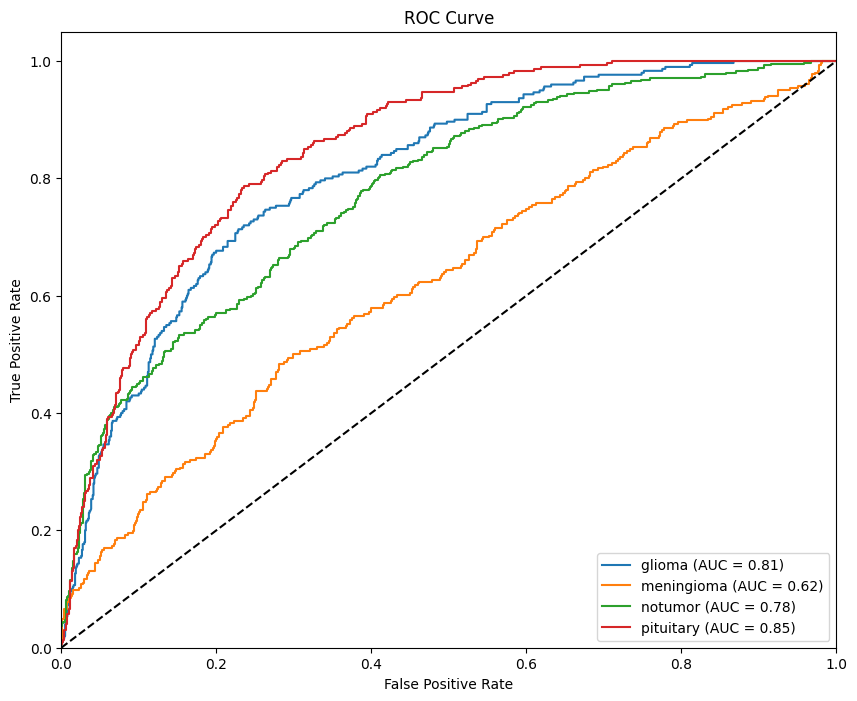

In [ ]:
# Trail 3: Add two more dense layers

# Evaluate on Test Set
print("\n=== Test Set Performance ===")

# Evaluate on test set
y_pred_prob_test, y_pred_test = evaluate_model(transfer_model_32_tuned, X_test, y_test, classes)

# Plot ROC curve for test set
plot_roc_auc(y_test, y_pred_prob_test, classes)


=== Test Set Performance ===
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 178ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.55      0.82      0.66       300
  meningioma       0.64      0.27      0.38       306
     notumor       0.84      0.68      0.75       405
   pituitary       0.68      0.90      0.77       300

    accuracy                           0.67      1311
   macro avg       0.67      0.67      0.64      1311
weighted avg       0.69      0.67      0.65      1311

Confusion Matrix:
 [[246  28   1  25]
 [116  84  53  53]
 [ 62  17 277  49]
 [ 27   3   0 270]]
Accuracy: 0.6690
Precision: 0.6875
Recall: 0.6690
F1-Score: 0.6493


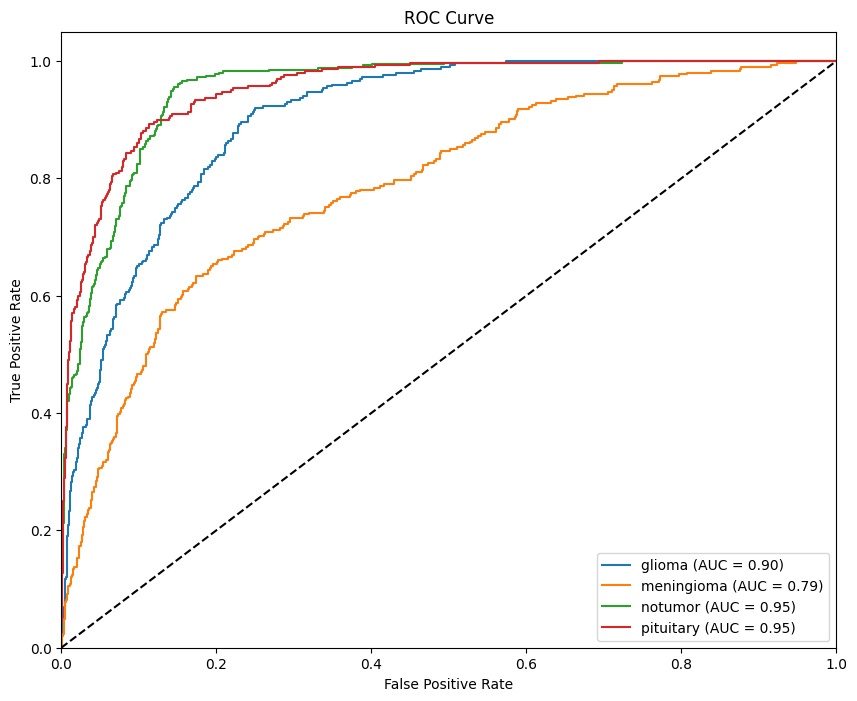

In [ ]:
# Trail 4: Directly change the images into (96*96*3)

# Evaluate on Test Set
print("\n=== Test Set Performance ===")

X_test, y_test = extract_data_from_generator(test_data)

# Evaluate on test set
y_pred_prob_test, y_pred_test = evaluate_model(transfer_model_96, X_test, y_test, classes)

# Plot ROC curve for test set
plot_roc_auc(y_test, y_pred_prob_test, classes)


=== Test Set Performance ===
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 197ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.73      0.72      0.73       300
  meningioma       0.65      0.46      0.54       306
     notumor       0.81      0.91      0.86       405
   pituitary       0.80      0.91      0.85       300

    accuracy                           0.76      1311
   macro avg       0.75      0.75      0.74      1311
weighted avg       0.75      0.76      0.75      1311

Confusion Matrix:
 [[217  53   8  22]
 [ 55 142  71  38]
 [ 12  15 368  10]
 [ 12  10   5 273]]
Accuracy: 0.7628
Precision: 0.7521
Recall: 0.7628
F1-Score: 0.7523


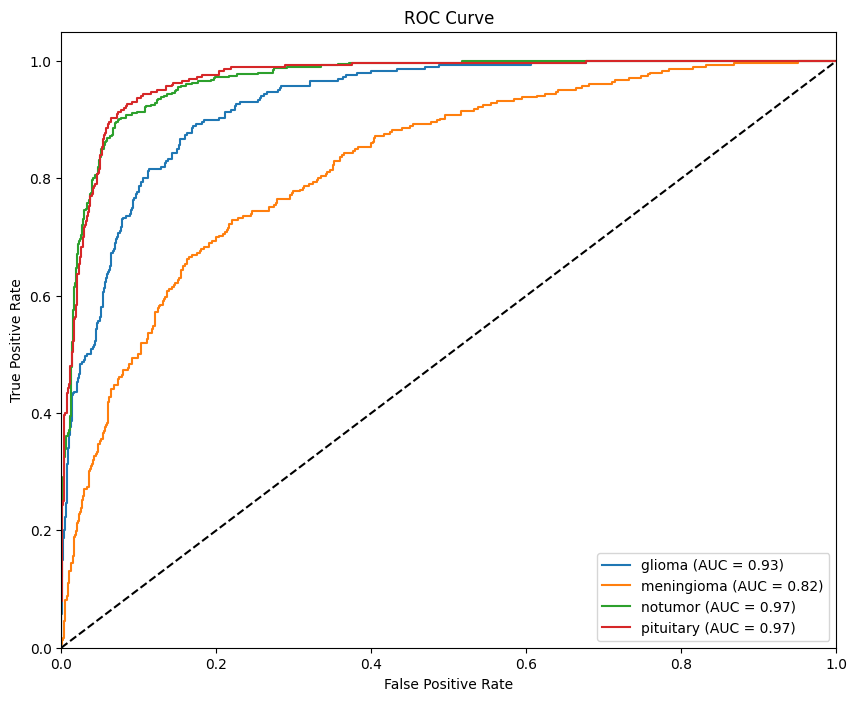

In [ ]:
# Trial 5: Changing image to (96,96,3) and applied best hyperparameter
print("\n=== Test Set Performance ===")

X_test, y_test = extract_data_from_generator(test_data)

# Evaluate on test set
y_pred_prob_test, y_pred_test = evaluate_model(transfer_model_96_tuned, X_test, y_test, classes)

# Plot ROC curve for test set
plot_roc_auc(y_test, y_pred_prob_test, classes)


=== Test Set Performance ===
41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 276ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.78      0.61      0.69       300
  meningioma       0.60      0.49      0.54       306
     notumor       0.78      0.96      0.86       405
   pituitary       0.81      0.89      0.85       300

    accuracy                           0.75      1311
   macro avg       0.74      0.74      0.73      1311
weighted avg       0.75      0.75      0.74      1311

Confusion Matrix:
 [[183  80  13  24]
 [ 39 151  81  35]
 [  6   7 387   5]
 [  6  14  13 267]]
Accuracy: 0.7536
Precision: 0.7454
Recall: 0.7536
F1-Score: 0.7428


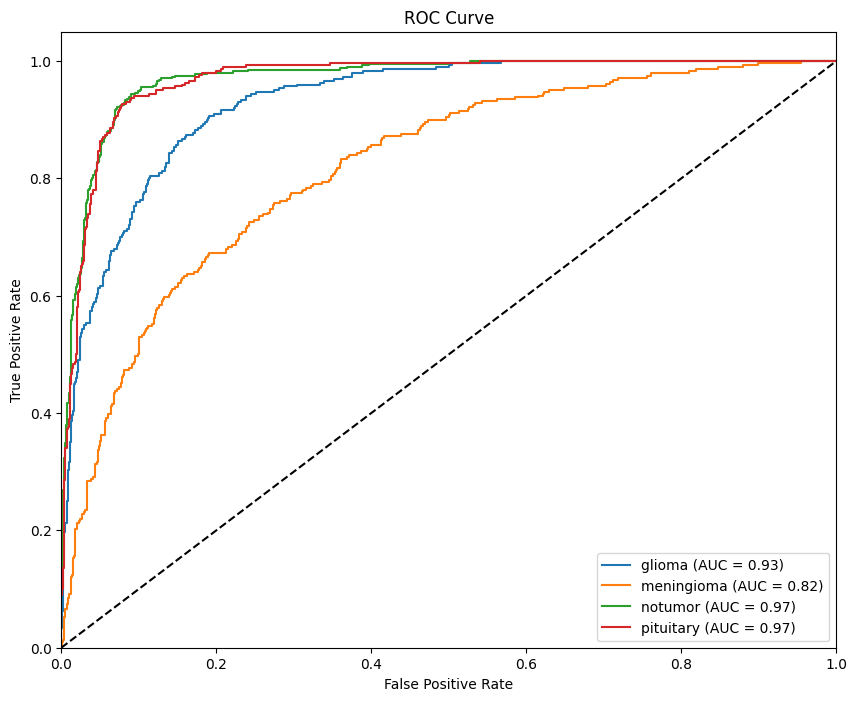

In [ ]:
# Trail 6: Add two more layers

# Evaluate on Test Set
print("\n=== Test Set Performance ===")

# Evaluate on test set
y_pred_prob_test, y_pred_test = evaluate_model(transfer_model_96_tuned, X_test, y_test, classes)

# Plot ROC curve for test set
plot_roc_auc(y_test, y_pred_prob_test, classes)

##### - PlanB: resize images based on 30\*30\*1

-- Lambda


=== Test Set Performance ===
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.00      0.00      0.00       300
  meningioma       0.00      0.00      0.00       306
     notumor       0.31      1.00      0.47       405
   pituitary       0.00      0.00      0.00       300

    accuracy                           0.31      1311
   macro avg       0.08      0.25      0.12      1311
weighted avg       0.10      0.31      0.15      1311

Confusion Matrix:
 [[  0   0 300   0]
 [  0   0 306   0]
 [  0   0 405   0]
 [  0   0 300   0]]
Accuracy: 0.3089
Precision: 0.0954
Recall: 0.3089
F1-Score: 0.1458


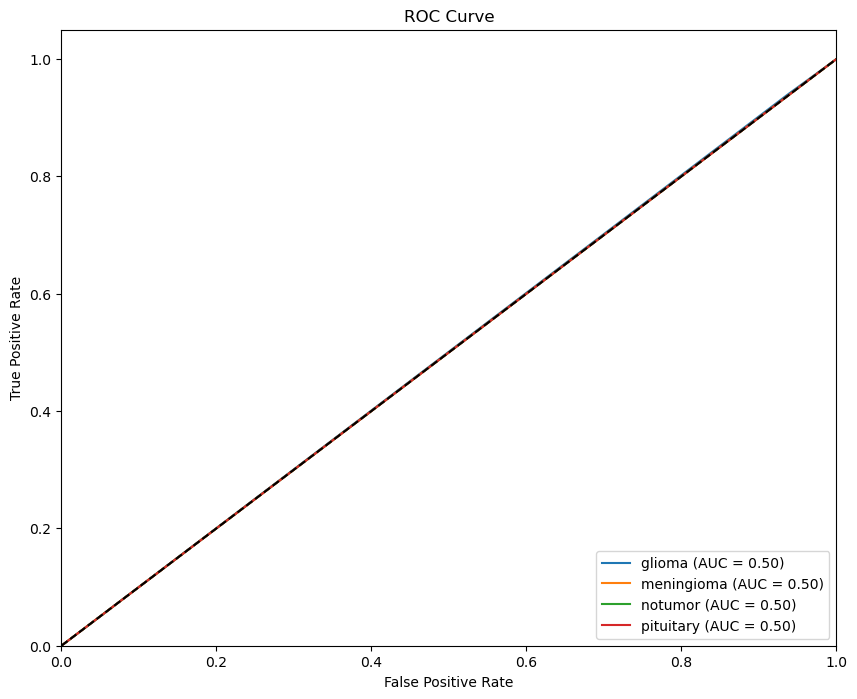

In [ ]:
# Trail 1: Using Lambda to change image to (32,32) + Best hyperparameters above 

# Evaluate on Test Set
print("\n=== Test Set Performance ===")
# Evaluate on test set
y_pred_prob_test, y_pred_test = evaluate_model(model_trans3_1, X_test, y_test, classes)
# Plot ROC curve for test set
plot_roc_auc(y_test, y_pred_prob_test, classes)


=== Test Set Performance ===
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 501ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.57      0.63      0.60       300
  meningioma       0.33      0.25      0.28       306
     notumor       0.58      0.58      0.58       405
   pituitary       0.55      0.62      0.58       300

    accuracy                           0.53      1311
   macro avg       0.51      0.52      0.51      1311
weighted avg       0.51      0.53      0.52      1311

Confusion Matrix:
 [[190  63  15  32]
 [ 56  77 114  59]
 [ 54  56 236  59]
 [ 35  40  39 186]]
Accuracy: 0.5256
Precision: 0.5131
Recall: 0.5256
F1-Score: 0.5173


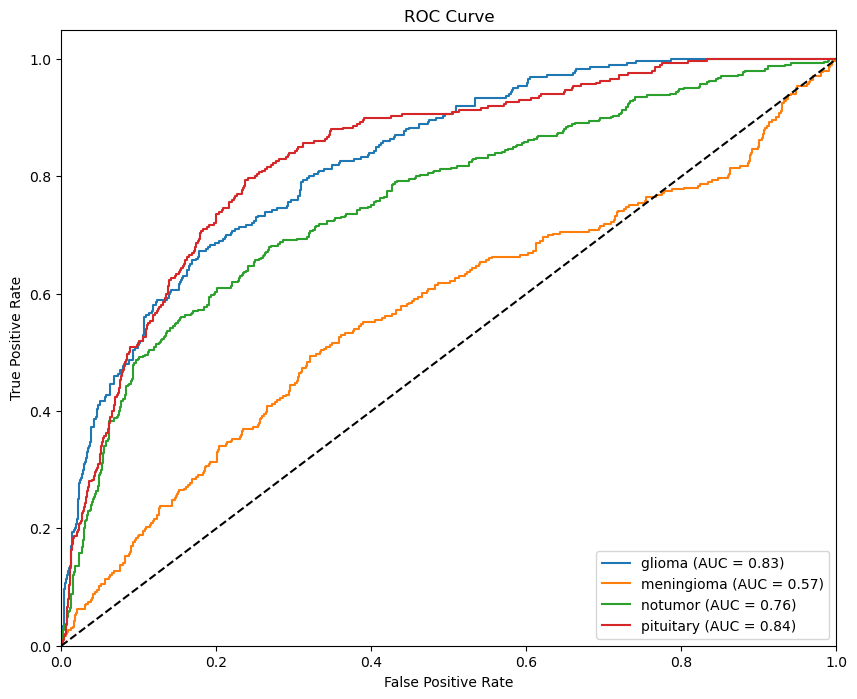

In [ ]:
# Trail 2: Using Lambda to change image to (96,96) + Best hyperparameters above 

# Evaluate on Test Set
print("\n=== Test Set Performance ===")
# Evaluate on test set
y_pred_prob_test, y_pred_test = evaluate_model(model_trans6, X_test, y_test, classes)
# Plot ROC curve for test set
plot_roc_auc(y_test, y_pred_prob_test, classes)

-- ZeroPadding


=== Test Set Performance ===
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.68      0.58      0.63       300
  meningioma       0.52      0.31      0.39       306
     notumor       0.71      0.82      0.76       405
   pituitary       0.64      0.84      0.72       300

    accuracy                           0.65      1311
   macro avg       0.64      0.64      0.63      1311
weighted avg       0.64      0.65      0.64      1311

Confusion Matrix:
 [[175  53  11  61]
 [ 54  95 105  52]
 [ 18  21 334  32]
 [ 12  13  22 253]]
Accuracy: 0.6537
Precision: 0.6405
Recall: 0.6537
F1-Score: 0.6353


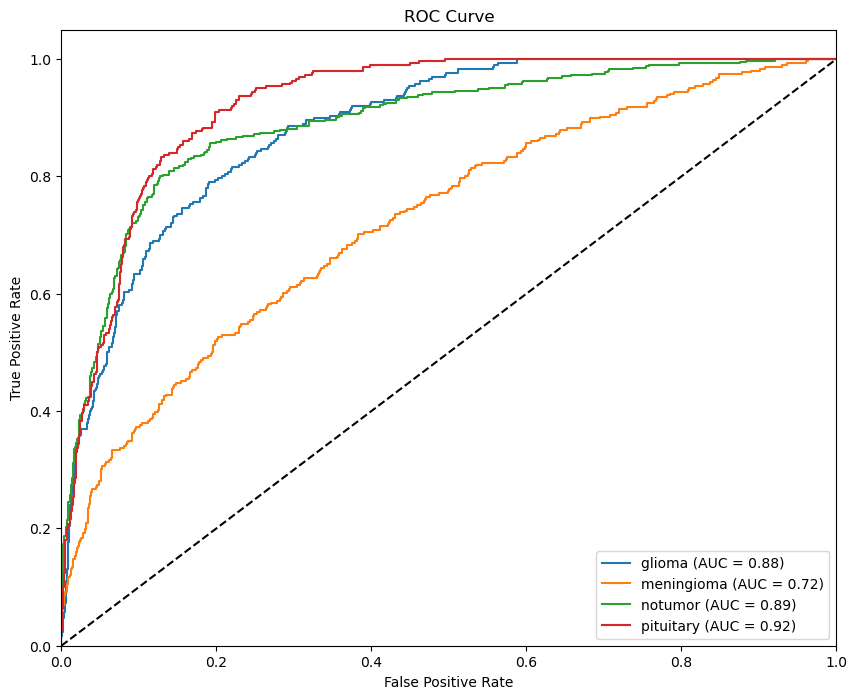

In [ ]:
# # Trail 3: Using zero padding to change image to (32,32) + Best hyperparameters above 

# Evaluate on Test Set
print("\n=== Test Set Performance ===")
# Evaluate on test set
y_pred_prob_test, y_pred_test = evaluate_model(model_trans3_2, X_test, y_test, classes)
# Plot ROC curve for test set
plot_roc_auc(y_test, y_pred_prob_test, classes)


=== Test Set Performance ===
41/41 ━━━━━━━━━━━━━━━━━━━━ 26s 588ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.71      0.61      0.66       300
  meningioma       0.45      0.40      0.42       306
     notumor       0.73      0.76      0.74       405
   pituitary       0.71      0.84      0.77       300

    accuracy                           0.66      1311
   macro avg       0.65      0.65      0.65      1311
weighted avg       0.65      0.66      0.65      1311

Confusion Matrix:
 [[184  73   6  37]
 [ 36 121 104  45]
 [ 23  52 307  23]
 [ 17  25   6 252]]
Accuracy: 0.6590
Precision: 0.6519
Recall: 0.6590
F1-Score: 0.6529


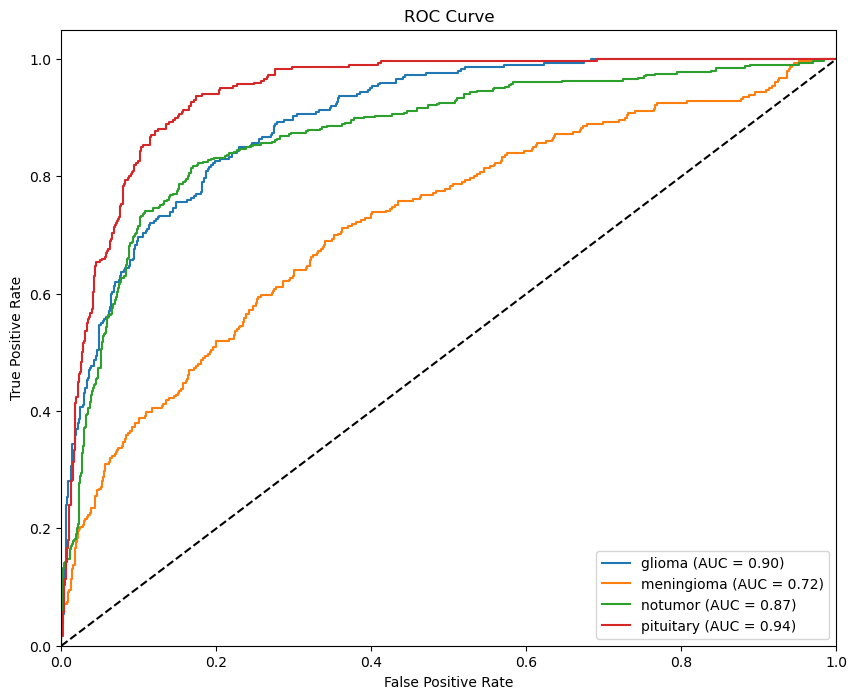

In [ ]:
# Trail 4: Using zero padding to change image to (96,96) + Best hyperparameters above 

# Evaluate on Test Set
print("\n=== Test Set Performance ===")
# Evaluate on test set
y_pred_prob_test, y_pred_test = evaluate_model(model_trans7, X_test, y_test, classes)
# Plot ROC curve for test set
plot_roc_auc(y_test, y_pred_prob_test, classes)

#### **2.2.3 DenseNet121**

##### - PlanA: directly resize image

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.5776 - loss: 0.9732
Test Loss: 0.7529561519622803
Test Accuracy: 0.6857360601425171
41/41 ━━━━━━━━━━━━━━━━━━━━ 30s 350ms/step
              precision    recall  f1-score   support

      glioma       0.70      0.49      0.58       300
  meningioma       0.54      0.51      0.53       306
     notumor       0.77      0.84      0.80       405
   pituitary       0.69      0.84      0.76       300

    accuracy                           0.69      1311
   macro avg       0.68      0.67      0.67      1311
weighted avg       0.68      0.69      0.68      1311



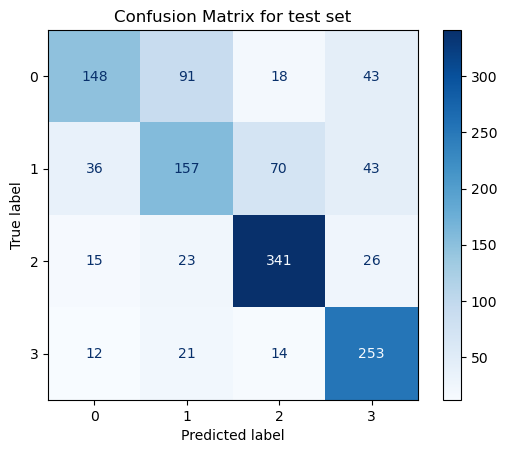

In [ ]:
# Trail 1: Directly change the image to (32,32,3)

test_images, test_labels = extract_data_from_generator(test_data)
test_images = convert_to_rgb(test_images)

# Evaluate test set
test_loss, test_acc = model.evaluate(test_images, test_labels)

# Loss and accuracy of test set
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

# ROC curve and confusion matrix
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Result
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(test_labels, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(test_labels.argmax(axis=1), y_pred.argmax(axis=1))

# Class report
print(classification_report(y_true_classes, y_pred_classes, target_names=list(train_data.class_indices.keys())))

# Plot confusion matrix
cmp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=test_data.class_indices.values())
cmp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for test set')
plt.show()

##### - PlanB: resize images based on 30\*30\*1 (Aspect-Ratio-Preserving Image Resizing with Padding)

In [ ]:
# Padding and Resize
def pad_and_resize(images, target_size=(32, 32)):
    padded_images = []
    for img in images:
        padded_img = tf.image.resize_with_pad(img, target_size[0], target_size[1])
        padded_images.append(padded_img)
    return np.array(padded_images)

# From grayscale to RGB channel
def convert_to_rgb(images):
    return np.repeat(images, 3, axis=-1)



# Padding and resize image from (30,30) to (32,32)
X_train_padded = pad_and_resize(X_train, target_size=(32, 32))
X_val_padded = pad_and_resize(X_val, target_size=(32, 32))
X_test_padded = pad_and_resize(X_test, target_size=(32, 32))

# Changing grayscale to RGB channel
X_train_rgb = convert_to_rgb(X_train_padded)
X_val_rgb = convert_to_rgb(X_val_padded)
X_test_rgb = convert_to_rgb(X_test_padded)

# Checking shape and channel
print(f"Train images RGB shape: {X_train_rgb.shape}")
print(f"Validation images RGB shape: {X_val_rgb.shape}")
print(f"Test images RGB shape: {X_test_rgb.shape}")

Train images RGB shape: (4569, 32, 32, 3)
Validation images RGB shape: (1143, 32, 32, 3)
Test images RGB shape: (1311, 32, 32, 3)


Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - accuracy: 0.3774 - loss: 1.4128 - val_accuracy: 0.6177 - val_loss: 0.9310
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.5968 - loss: 0.9597 - val_accuracy: 0.6422 - val_loss: 0.8635
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.6360 - loss: 0.8680 - val_accuracy: 0.6544 - val_loss: 0.8314
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.6653 - loss: 0.8007 - val_accuracy: 0.6693 - val_loss: 0.8112
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.6934 - loss: 0.7577 - val_accuracy: 0.6675 - val_loss: 0.7996
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.6902 - loss: 0.7375 - val_accuracy: 0.6745 - val_loss: 0.7863
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.7124 - loss: 0.7119 - val_accuracy: 0.6710 - val_loss: 0.7817
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.7163 - loss: 0.7039 - val_acc

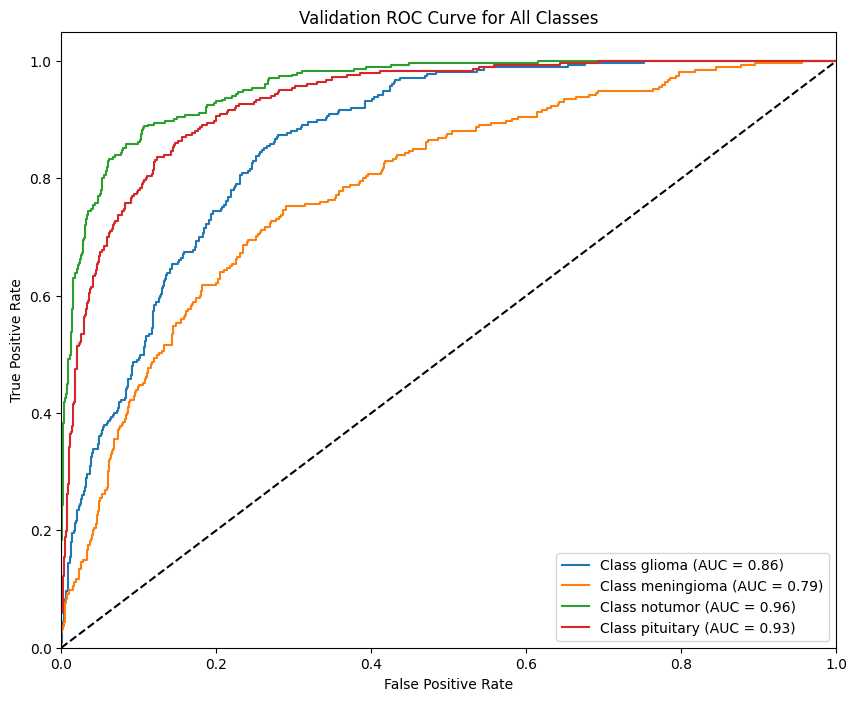

Validation Confusion Matrix:
[[194  42  10  31]
 [ 99 100  34  42]
 [ 24  11 250  20]
 [ 19  23  19 225]]
Validation Classification Report:
              precision    recall  f1-score   support

      glioma       0.58      0.70      0.63       277
  meningioma       0.57      0.36      0.44       275
     notumor       0.80      0.82      0.81       305
   pituitary       0.71      0.79      0.75       286

    accuracy                           0.67      1143
   macro avg       0.66      0.67      0.66      1143
weighted avg       0.67      0.67      0.66      1143



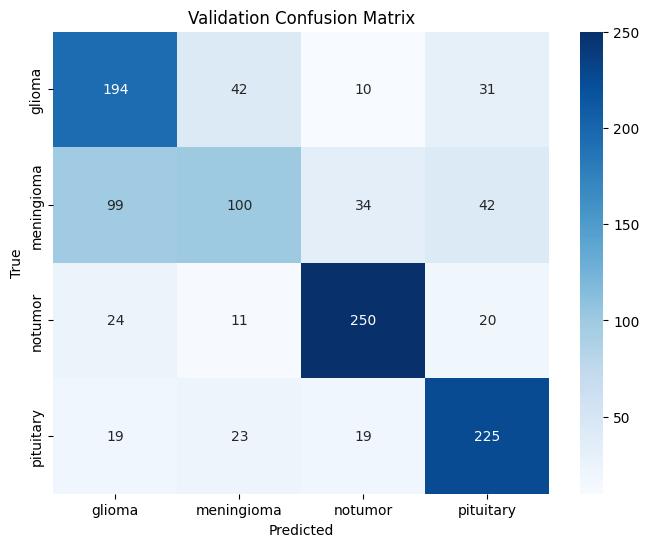

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6731 - loss: 0.7888
Validation Accuracy: 0.6727908849716187
Validation Loss: 0.7721266746520996
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
Test AUC Score: 0.8867


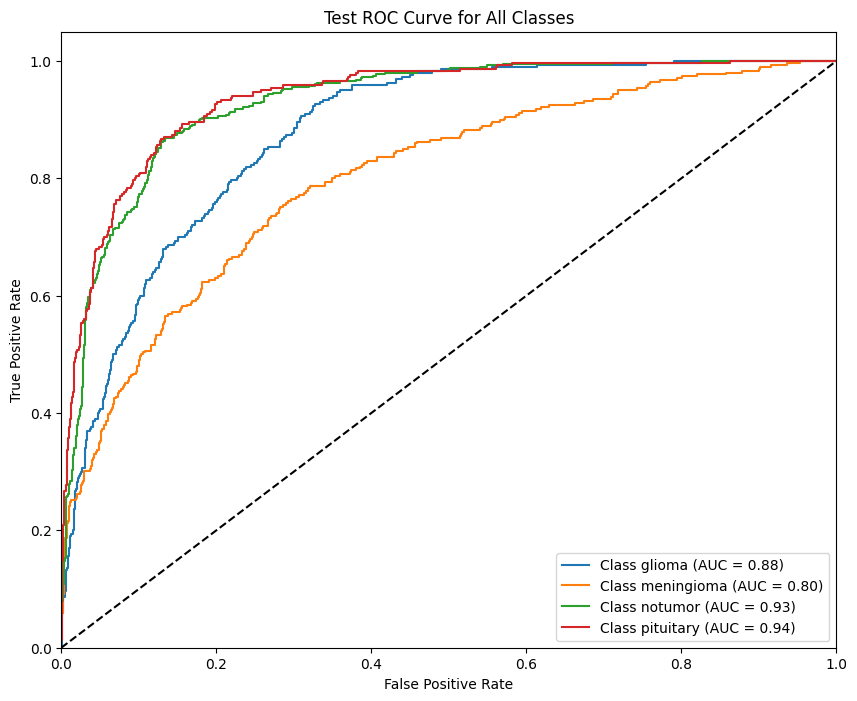

Test Confusion Matrix:
[[201  47  17  35]
 [ 78 136  61  31]
 [ 36  25 315  29]
 [ 33  17  13 237]]
Test Classification Report:
              precision    recall  f1-score   support

      glioma       0.58      0.67      0.62       300
  meningioma       0.60      0.44      0.51       306
     notumor       0.78      0.78      0.78       405
   pituitary       0.71      0.79      0.75       300

    accuracy                           0.68      1311
   macro avg       0.67      0.67      0.66      1311
weighted avg       0.68      0.68      0.67      1311



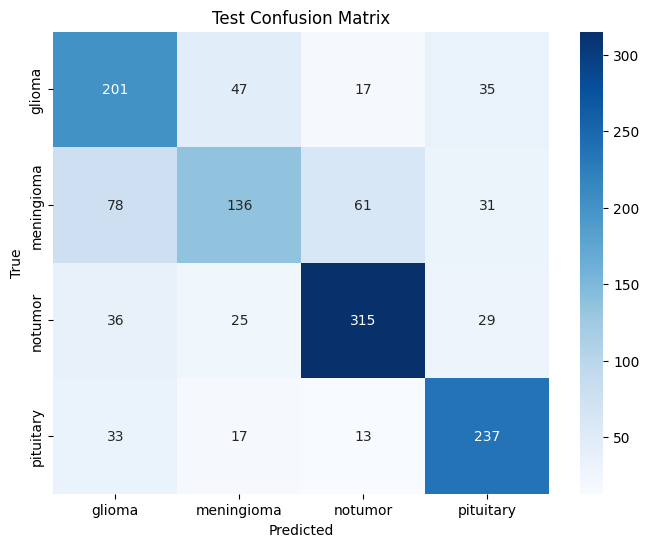

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6422 - loss: 0.8414
Test Accuracy: 0.6781083345413208
Test Loss: 0.775825023651123


In [ ]:
# Pre-trained DenseNet121, set input size = (32,32,3)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(32, 32, 3))  

# Freeze all layers until fully connected layers
for layer in base_model.layers:
    layer.trainable = False

# Use Sequential model to add custom layers
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())  
model.add(Dense(1024, activation='swish'))  
model.add(Dropout(0.5))  
model.add(Dense(4, activation='softmax'))  

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_rgb, y_train, epochs=10, validation_data=(X_val_rgb, y_val))

# Evaluation
def evaluate_and_plot_roc(model, X_data_rgb, y_true, dataset_name, classes):

    y_pred_prob = model.predict(X_data_rgb)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_classes = np.argmax(y_true, axis=1)

    # Calculate AUC score
    auc_score = roc_auc_score(y_true, y_pred_prob, multi_class='ovr')
    print(f"{dataset_name} AUC Score: {auc_score:.4f}")

    # Plot ROC curve
    y_true_bin = label_binarize(y_true_classes, classes=range(len(classes)))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    plt.figure(figsize=(10, 8))
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

    # Baseline for a random classifier
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{dataset_name} ROC Curve for All Classes')
    plt.legend(loc='lower right')
    plt.show()

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true_classes, y_pred)
    print(f"{dataset_name} Confusion Matrix:")
    print(conf_matrix)

    # Class report
    print(f"{dataset_name} Classification Report:")
    print(classification_report(y_true_classes, y_pred, target_names=classes))

    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{dataset_name} Confusion Matrix')
    plt.show()

    # Evaluation on dataset
    loss, acc = model.evaluate(X_data_rgb, y_true)
    print(f"{dataset_name} Accuracy: {acc}")
    print(f"{dataset_name} Loss: {loss}")

# Evaluate on validation set
evaluate_and_plot_roc(model, X_val_rgb, y_val, "Validation", classes=['glioma', 'meningioma', 'notumor', 'pituitary'])

# Evaluate on test set
evaluate_and_plot_roc(model, X_test_rgb, y_test, "Test", classes=['glioma', 'meningioma', 'notumor', 'pituitary'])

[I 2024-09-28 10:08:30,114] A new study created in memory with name: no-name-8d71a98d-a4e0-41fc-a1ec-9b132a8c21d7


[I 2024-09-28 10:10:08,583] Trial 0 finished with value: 0.7121610045433044 and parameters: {'learning_rate': 0.00040891121574397263, 'dense_units': 1728, 'dropout_rate': 0.5007736413781743, 'batch_size': 18}. Best is trial 0 with value: 0.7121610045433044.
[I 2024-09-28 10:11:34,058] Trial 1 finished with value: 0.668416440486908 and parameters: {'learning_rate': 1.2394694730018267e-05, 'dense_units': 1550, 'dropout_rate': 0.5840019522337063, 'batch_size': 24}. Best is trial 0 with value: 0.7121610045433044.
[I 2024-09-28 10:12:54,817] Trial 2 finished with value: 0.7104111909866333 and parameters: {'learning_rate': 4.742393510347584e-05, 'dense_units': 1768, 'dropout_rate': 0.5636266769498964, 'batch_size': 27}. Best is trial 0 with value: 0.7121610045433044.
[I 2024-09-28 10:14:25,226] Trial 3 finished with value: 0.7034120559692383 and parameters: {'learning_rate': 2.7949988280569966e-05, 'dense_units': 1452, 'dropout_rate': 0.5753957707034689, 'batch_size': 19}. Best is trial 0 wi

Best hyperparameters:  {'learning_rate': 0.00024364400984267382, 'dense_units': 1688, 'dropout_rate': 0.5661201919420064, 'batch_size': 27}
Epoch 1/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - accuracy: 0.4770 - loss: 1.3210 - val_accuracy: 0.6430 - val_loss: 0.8480
Epoch 2/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.6306 - loss: 0.8879 - val_accuracy: 0.6868 - val_loss: 0.7746
Epoch 3/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.6782 - loss: 0.7930 - val_accuracy: 0.6964 - val_loss: 0.7450
Epoch 4/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.6813 - loss: 0.7325 - val_accuracy: 0.7034 - val_loss: 0.7471
Epoch 5/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.7059 - loss: 0.7106 - val_accuracy: 0.7139 - val_loss: 0.7329
Epoch 6/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.7182 - loss: 0.6791 - val_accuracy: 0.7183 - val_loss: 0.7195
Epoch 7/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.7352 - loss: 0.651

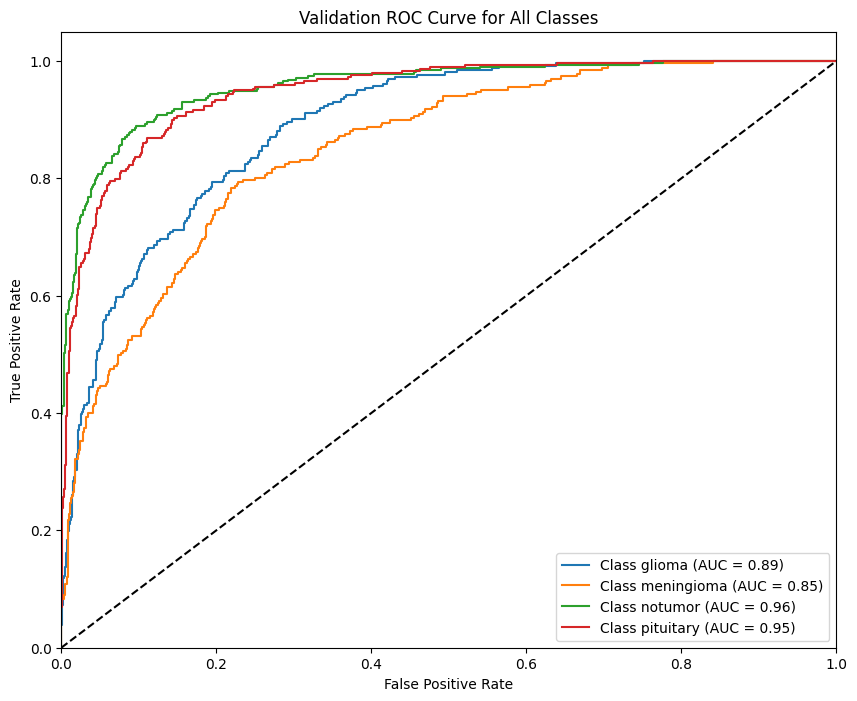

Validation Confusion Matrix:
[[161  55   9  36]
 [ 51 141  27  48]
 [ 13  15 258  30]
 [ 12  14  12 261]]
Validation Classification Report:
              precision    recall  f1-score   support

      glioma       0.68      0.62      0.65       261
  meningioma       0.63      0.53      0.57       267
     notumor       0.84      0.82      0.83       316
   pituitary       0.70      0.87      0.77       299

    accuracy                           0.72      1143
   macro avg       0.71      0.71      0.71      1143
weighted avg       0.72      0.72      0.71      1143



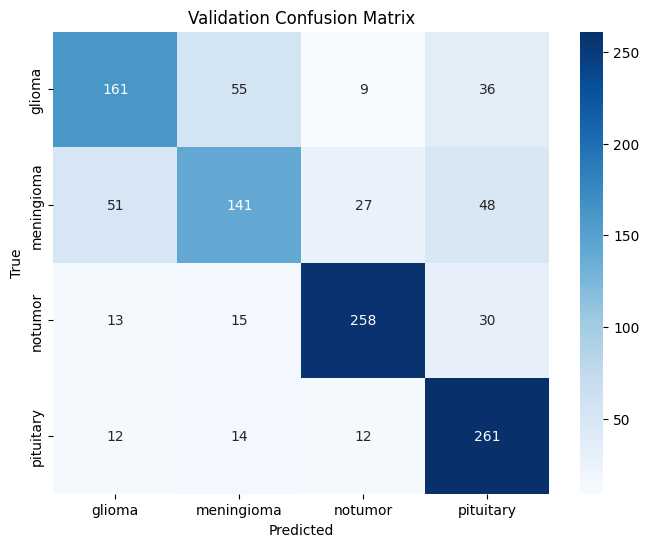

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7409 - loss: 0.6414
Validation Accuracy: 0.7182852029800415
Validation Loss: 0.6955817341804504
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
Test AUC Score: 0.8925


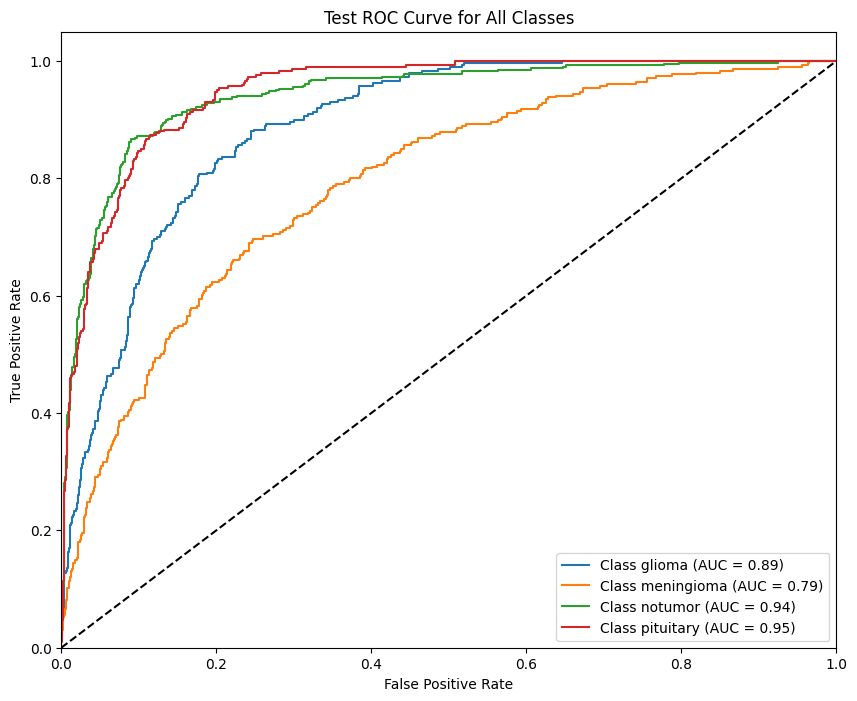

Test Confusion Matrix:
[[181  64   5  50]
 [ 63 129  64  50]
 [ 22  24 341  18]
 [ 16  17   4 263]]
Test Classification Report:
              precision    recall  f1-score   support

      glioma       0.64      0.60      0.62       300
  meningioma       0.55      0.42      0.48       306
     notumor       0.82      0.84      0.83       405
   pituitary       0.69      0.88      0.77       300

    accuracy                           0.70      1311
   macro avg       0.68      0.69      0.68      1311
weighted avg       0.69      0.70      0.69      1311



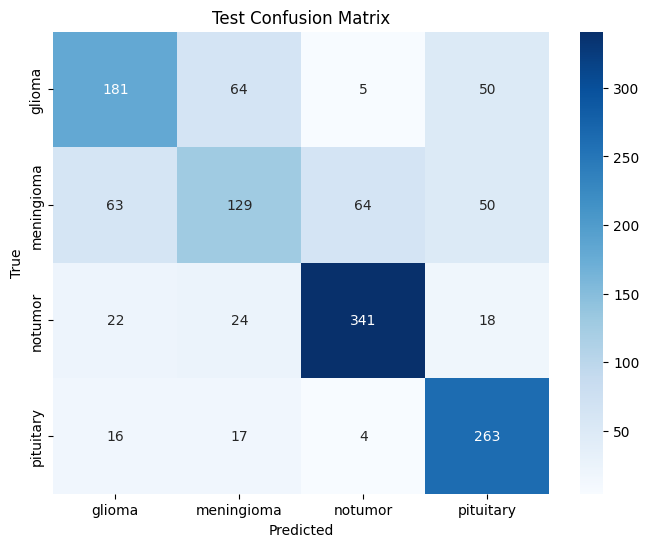

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6199 - loss: 0.9387
Test Accuracy: 0.6971777081489563
Test Loss: 0.771432101726532


In [ ]:
# Hyperparameter tuning
    # - Learning rate
    # - Units of dense layer
    # - Dropout rate
    # - Batch size

def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
    dense_units = trial.suggest_int('dense_units',1024,2048)
    dropout_rate = trial.suggest_float('dropout_rate',0.5,0.6)
    batch_size = trial.suggest_int('batch_size', 16, 32)
    
    # Create pre-trained DenseNet121
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(32, 32, 3))  

    # Freeze all layers until fully connected layers
    for layer in base_model.layers:
        layer.trainable = False

    # Use Sequential model to add custom layers
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())  
    model.add(Dense(dense_units, activation='relu')) 
    model.add(Dropout(dropout_rate))  
    model.add(Dense(4, activation='softmax'))  

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    model.fit(X_train_rgb, y_train, batch_size=batch_size, epochs=10, validation_data=(X_val_rgb, y_val), verbose=0)
    
    # Evaluation
    val_loss, val_acc = model.evaluate(X_val_rgb, y_val, verbose=0)

    return val_acc

# Run the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Print best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Using best hyperparameters to train the model
best_params = study.best_params


base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(32, 32, 3))  

for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())  
model.add(Dense(best_params['dense_units'], activation='relu'))  
model.add(Dropout(best_params['dropout_rate']))  
model.add(Dense(4, activation='softmax')) 

model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train_rgb, y_train, batch_size=best_params['batch_size'], epochs=10, validation_data=(X_val_rgb, y_val))

# Evaluation
val_loss, val_acc = model.evaluate(X_val_rgb, y_val)
print(f"Validation Accuracy: {val_acc}")
print(f"Validation Loss: {val_loss}")

# Using evaluate_and_plot_roc to evaluate the final model
evaluate_and_plot_roc(model, X_val_rgb, y_val, "Validation", classes=['glioma', 'meningioma', 'notumor', 'pituitary'])
evaluate_and_plot_roc(model, X_test_rgb, y_test, "Test", classes=['glioma', 'meningioma', 'notumor', 'pituitary'])